# Univariate Volatility Modeling

### Kevin Sheppard


# Topic Outline

* Visualizing Conditional Volatility
* Testing for Conditional Volatility
* ARCH Models
* GARCH Models
* Asymmetric Extensions
* Model Building
* Specification Checking
* Alternative Distributional Assumptions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mfe

mfe.outputs["pres"]()
from mfe.slides import plot, figsize, pretty, summary, truncated_plot
import arch
from arch import arch_model
from arch.univariate.distribution import StudentsT
from arch.univariate.mean import ZeroMean
from arch.univariate.volatility import GARCH

## Data
SPY
FTSE 100
WTI
GLD
BitCoin


## Outline

1. Visualizing Heteroskedastic Data
2. ARCH model estimation
3. Residual Analysis
4. GARCH Model Estimation
5. EWMA Model Estimation
5. GJR-GARCH Model Estimation
6. TARCH Estimation
6. EGARCH Estimation
7. APARCH Estimation
8. Specification Checking
9. Model Building
10. Forecasting
11. Forecast Eval
  * Absolute
  * GLS
  * Relative
12. Realized Variance
13. RV Succes
14. RV Failure - simulated data
15. Volatility Signature
16. RV Forecasting HAR
17. RV Forecasting Log
18. RV Forecasting ARCH-type
19. HARCH
20. RV volatility model evaluation ??
21. VIX
22. VIX Dynamics
23. Variance Risk Premium

In [2]:
sp500 = (
    100
    * pd.read_csv("data/^GSPC.csv", index_col="Date", parse_dates=True)["Adj Close"]
    .pct_change()
    .dropna()["1980":]
)
gold = pd.read_csv(
    "data/GOLDPMGBD228NLBM.csv", index_col="DATE", parse_dates=True
).iloc[:, 0]["1980":]
wti = pd.read_csv("data/DCOILWTICO.csv", index_col="DATE", parse_dates=True).iloc[:, 0]
btc = pd.read_csv("data/CBBTCUSD.csv", index_col="DATE", parse_dates=True).iloc[:, 0]
eth = pd.read_csv("data/CBETHUSD.csv", index_col="DATE", parse_dates=True).iloc[:, 0]

ftse100 = pd.read_html("data/FTSE100-table.html")
ftse100 = ftse100[0].iloc[:-1].iloc[::-1]
ftse100 = pd.to_numeric(ftse100.set_index("Date")["Adj Close**"], errors="coerce")
ftse100.index = pd.to_datetime(ftse100.index)
ftse100 = 100 * ftse100.dropna().pct_change().dropna()

gold = 100 * pd.to_numeric(gold, errors="coerce").dropna().pct_change().dropna()
btc = 100 * pd.to_numeric(btc, errors="coerce").dropna().pct_change().dropna()
eth = 100 * pd.to_numeric(eth, errors="coerce").dropna().pct_change().dropna()
btc = btc.loc[eth.index[0] :]

wti = pd.to_numeric(wti, errors="coerce")
wti.loc[wti <= 0] = np.nan
wti = 100 * wti.dropna().pct_change().dropna()

rs = np.random.RandomState(20210202)
am = ZeroMean(sp500, volatility=GARCH(), distribution=StudentsT(random_state=rs))
res = am.fit(disp="off")
iid = pd.Series(am.simulate([sp500.var(), 0, 0, res.params.nu], sp500.shape[0]).data)
iid.index = sp500.index

sp500.name = "S&P 500"
ftse100.name = "FTSE 100"
gold.name = "GOLD Fixing"
wti.name = "WTI Crude"
btc.name = "Coinbase BTC"
eth.name = "Coinbase Ethereum"

data = {
    "sp500": sp500,
    "ftse100": ftse100,
    "gold": gold,
    "wti": wti,
    "btc": btc,
    "eth": eth,
    "iid": iid,
}

with pd.HDFStore("univariate-volatility-data.h5", mode="w") as store:
    for key, value in data.items():
        store.put(key, value)

# Data

# S&P 500 Returns

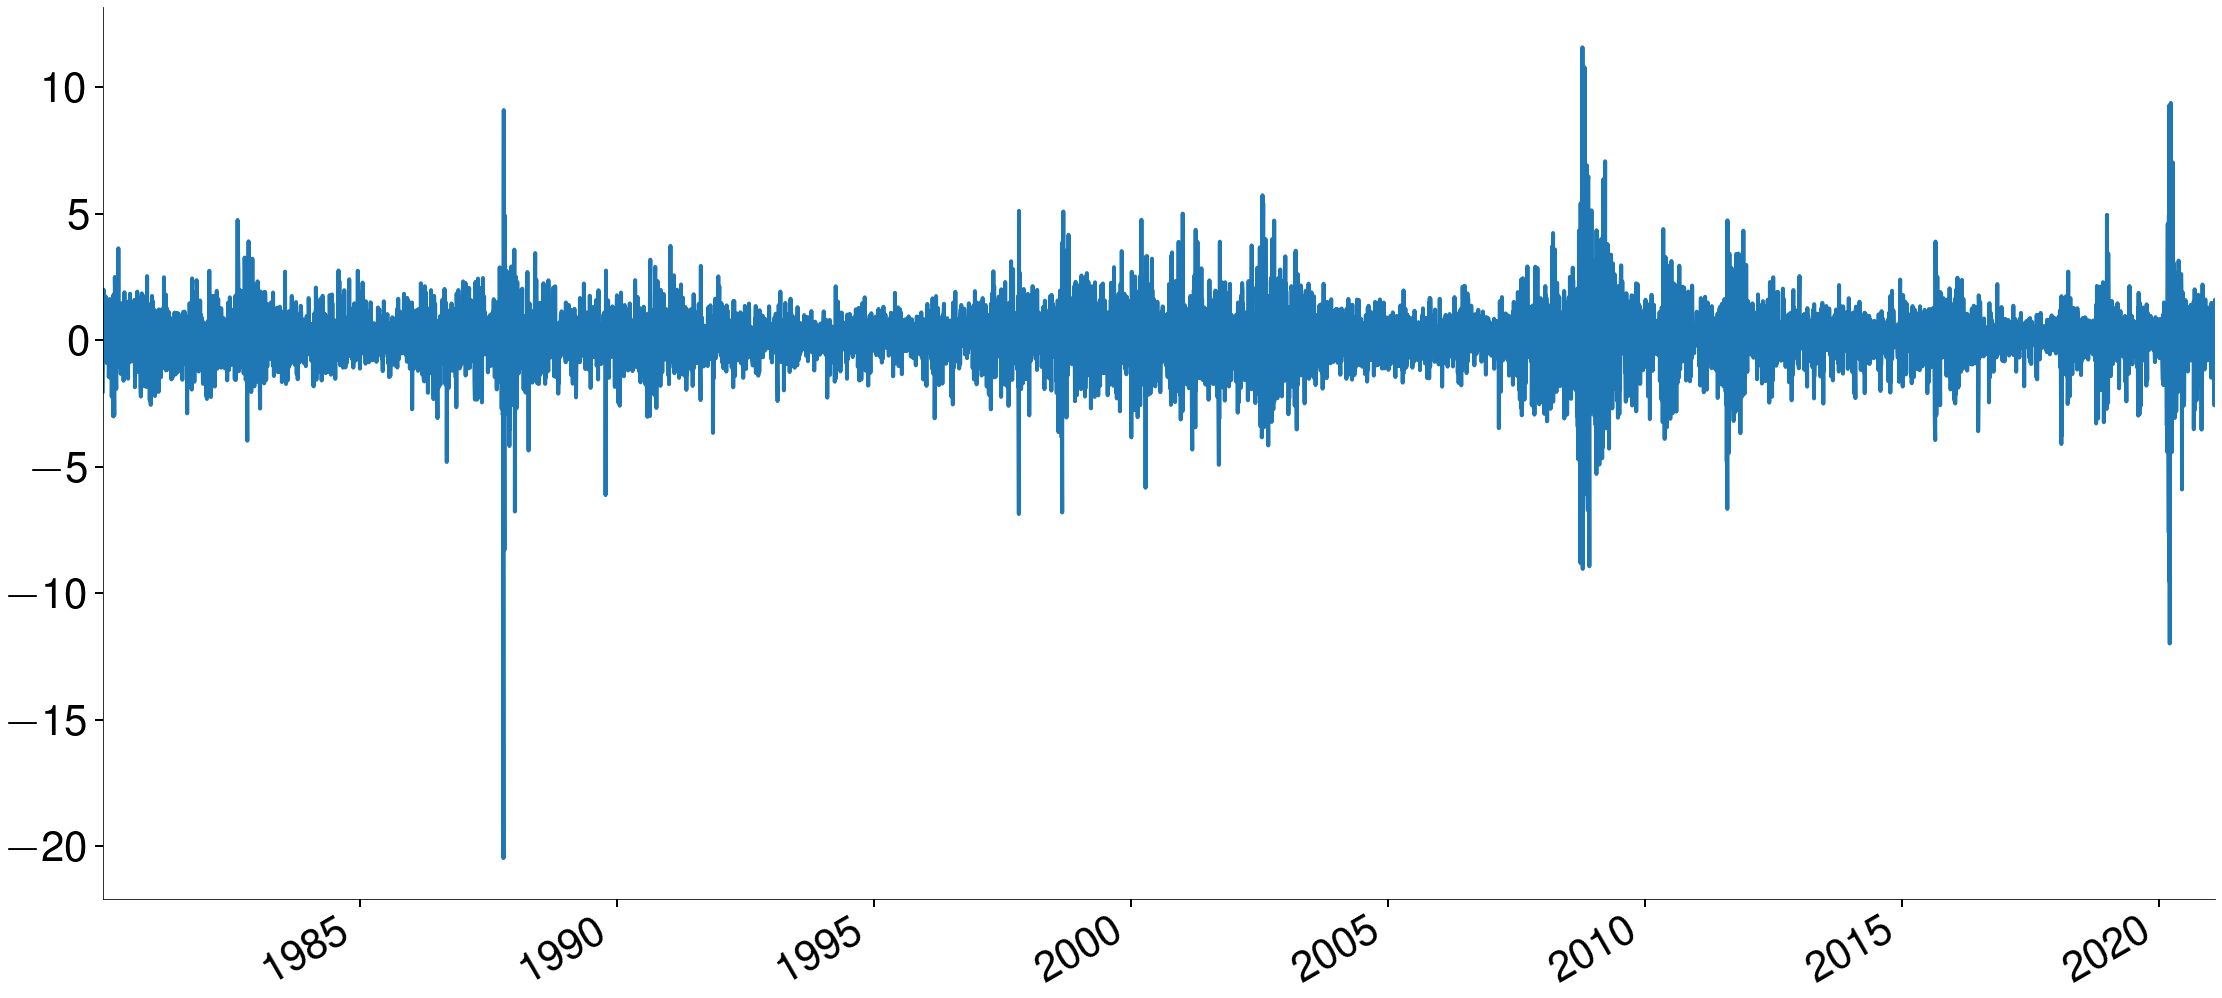

In [3]:
plot(sp500)

# Simulated IID $t_6$ Data

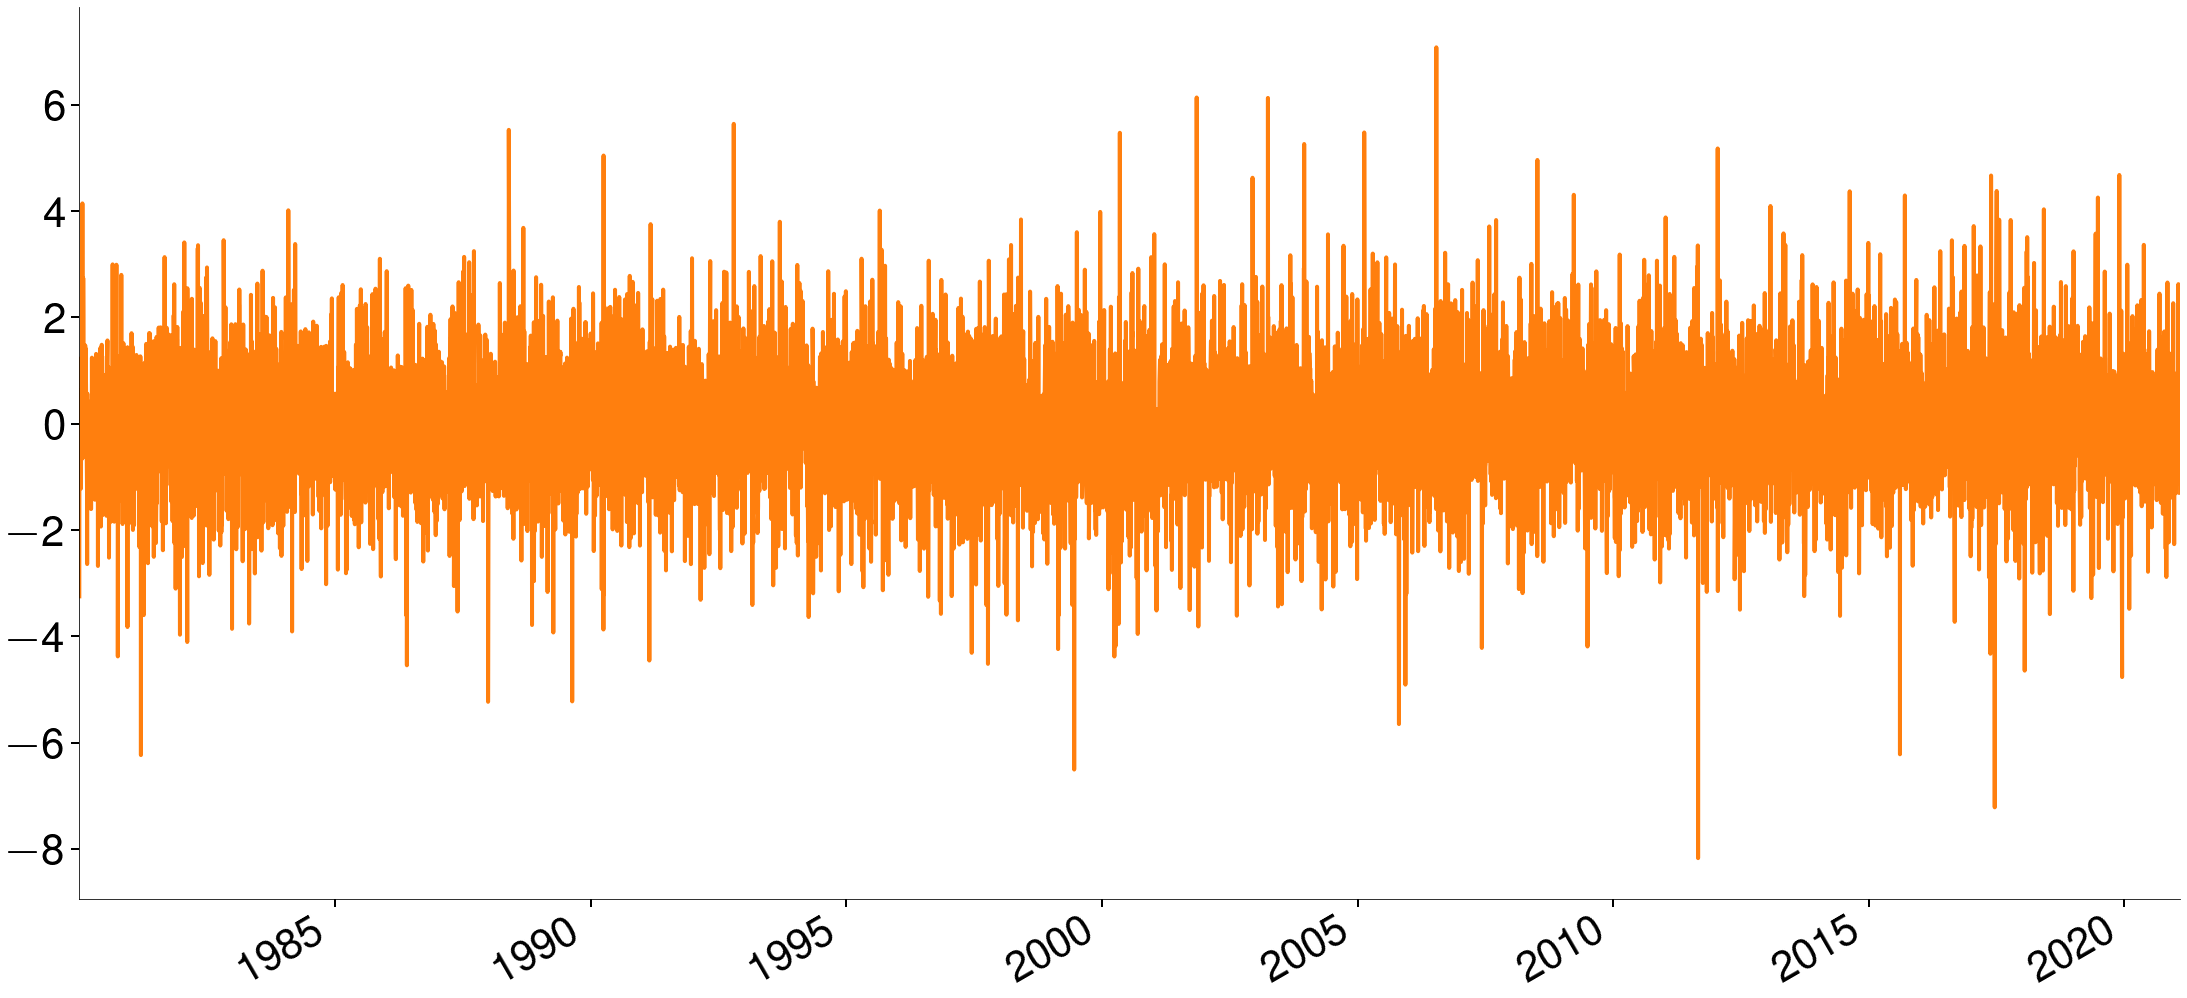

In [4]:
plot(iid)

# FTSE 200

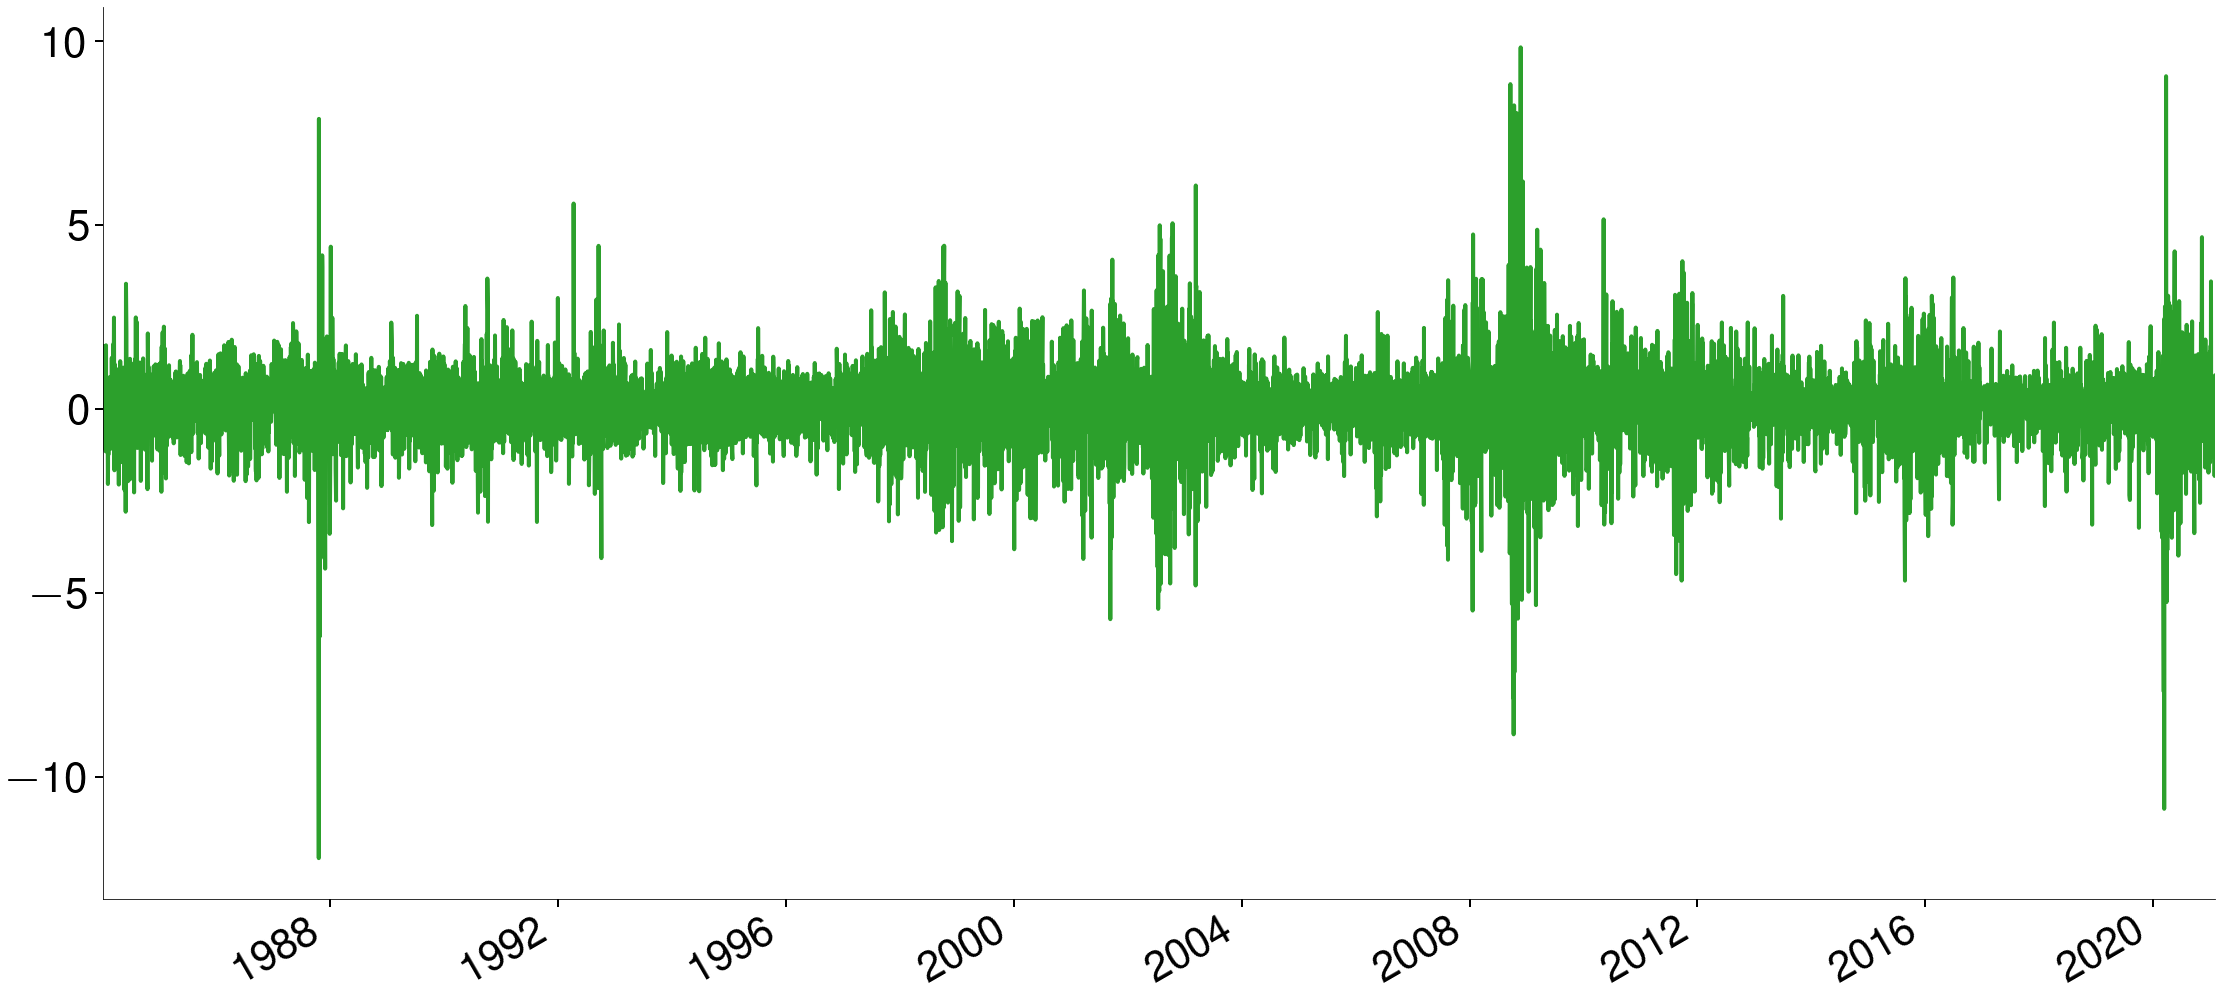

In [5]:
plot(ftse100)

# GOLD Fixing Price

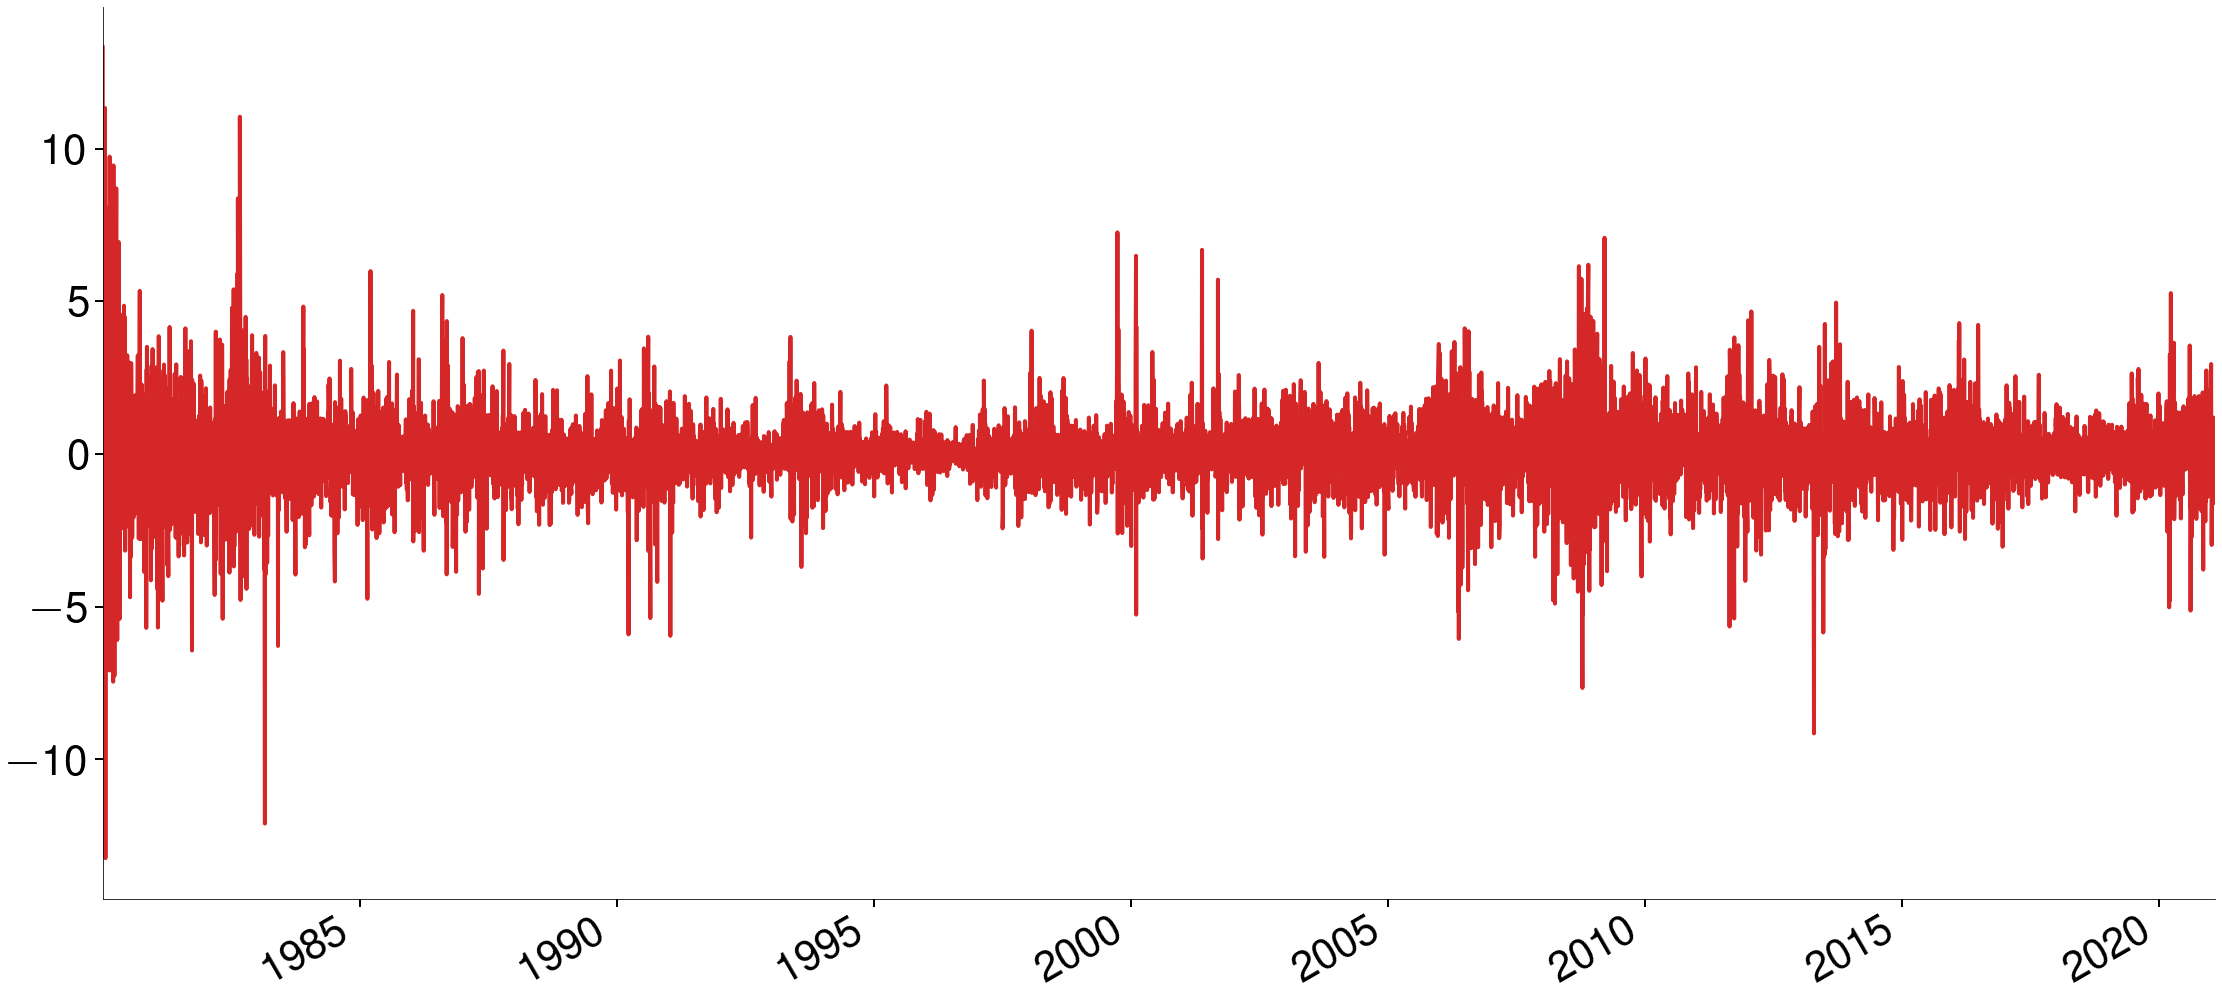

In [6]:
plot(gold)

# West Texas Intermediate Crude 

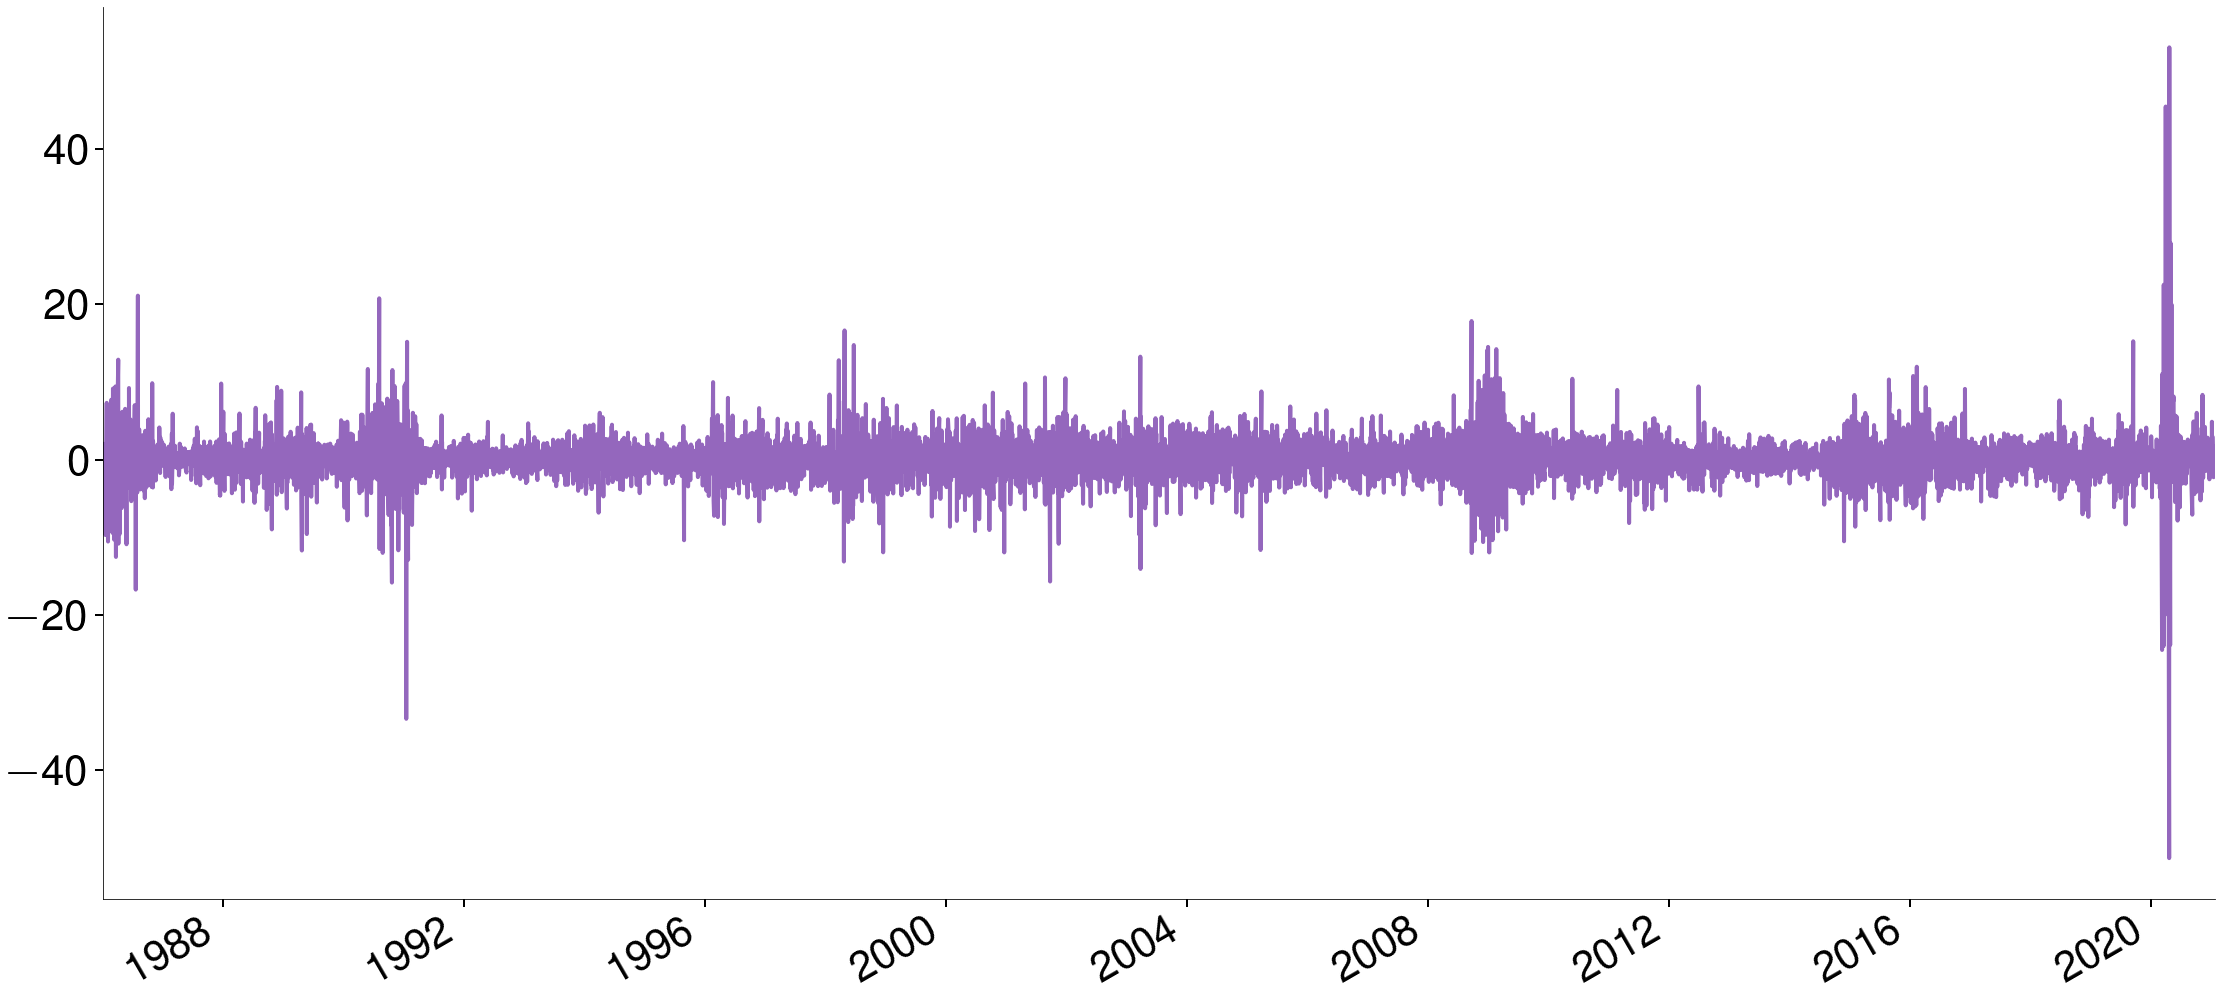

In [7]:
plot(wti)

# Coinbase BitCoin

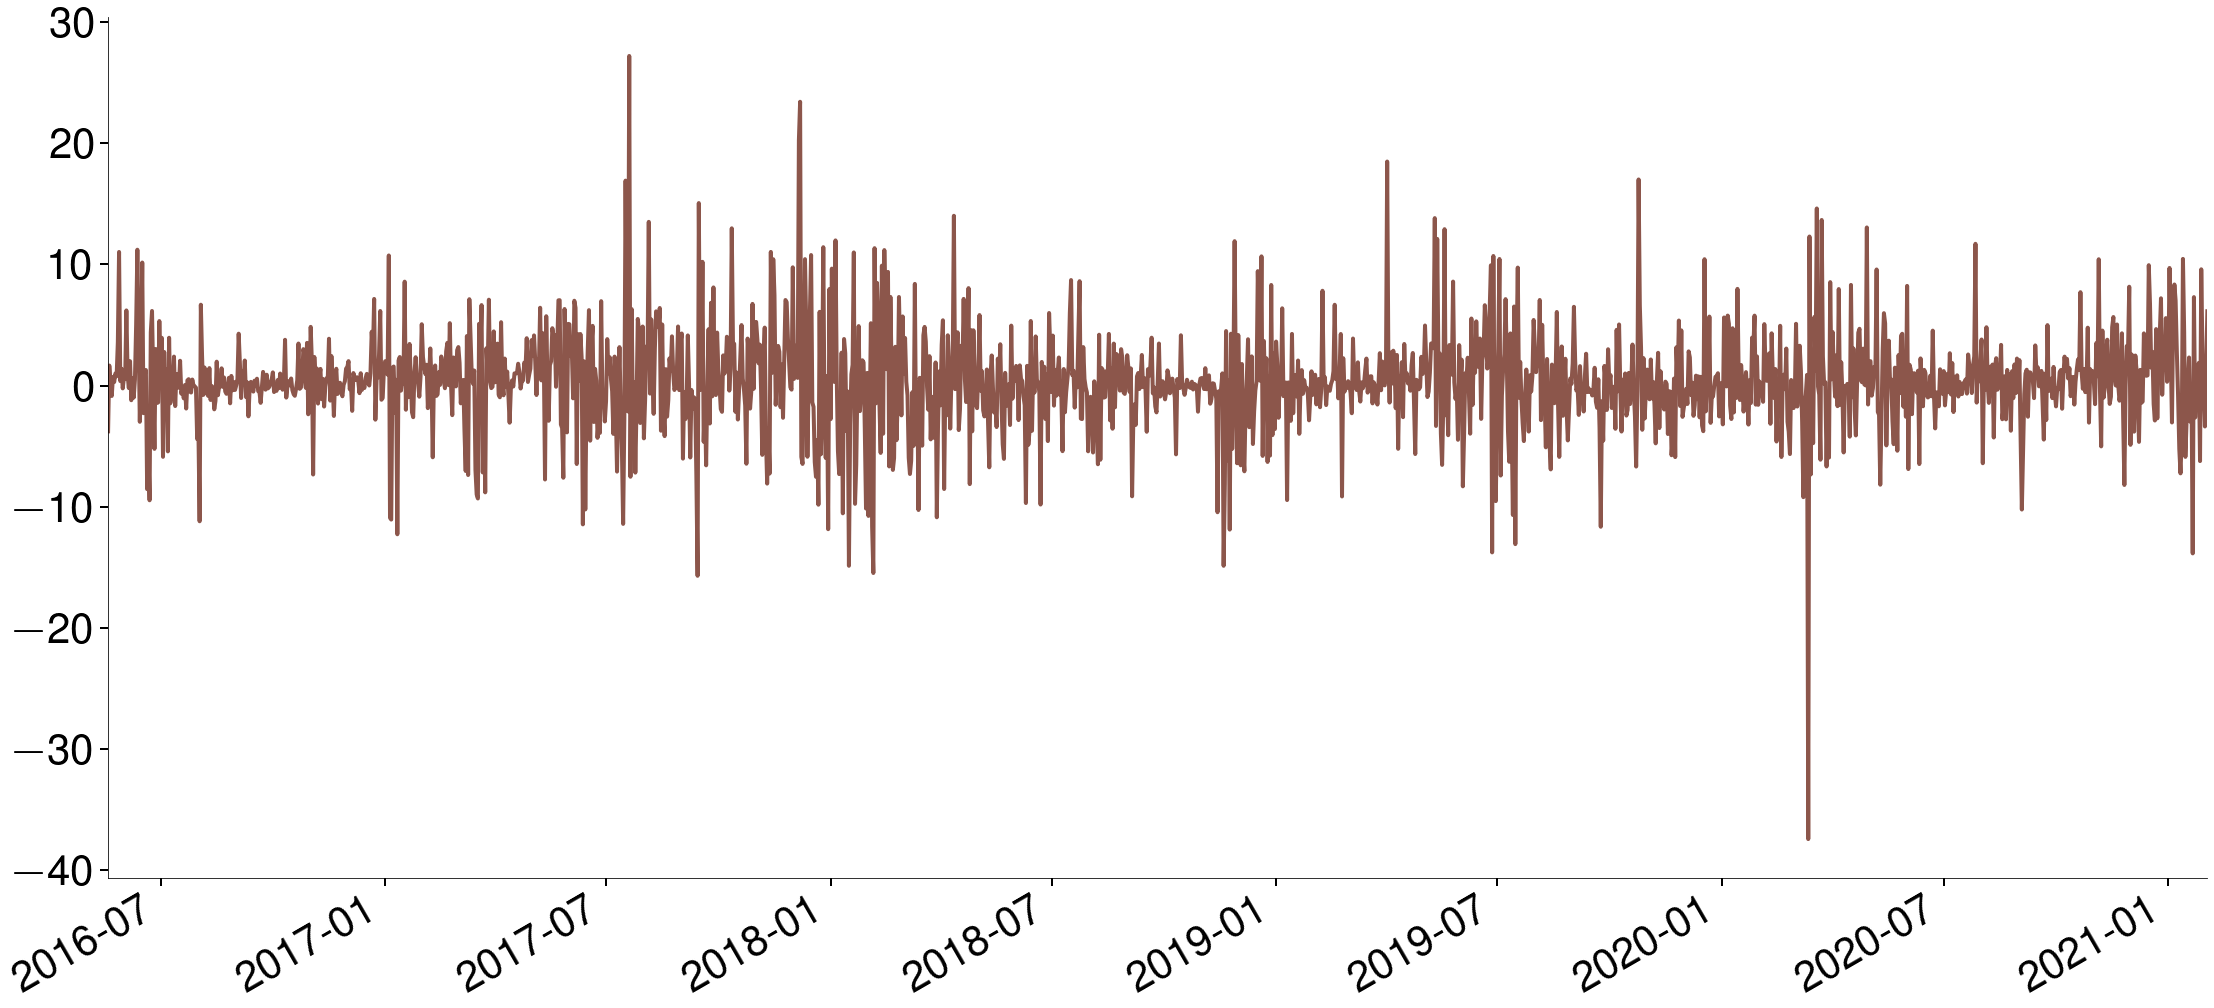

In [8]:
plot(btc)

# Coinbase Etherium

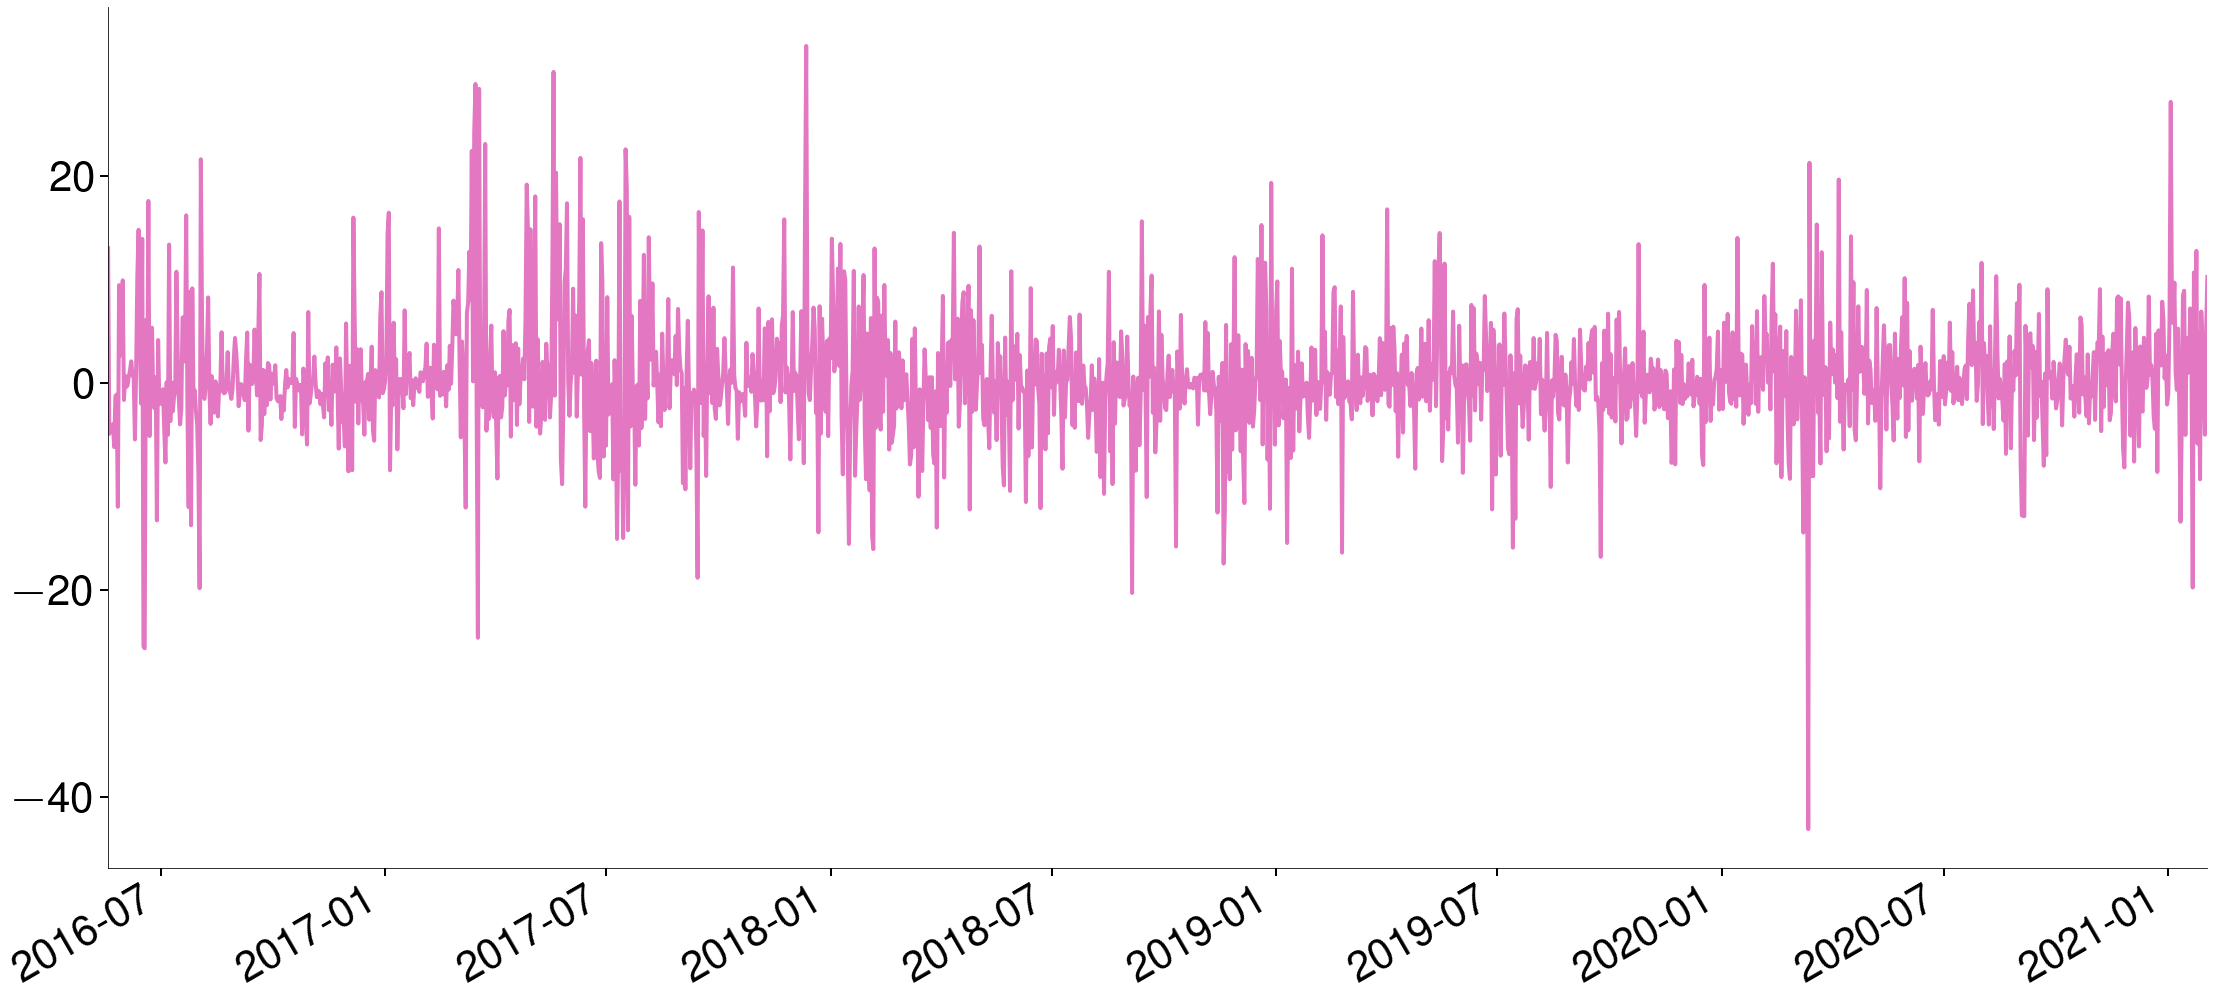

In [9]:
plot(eth)

# Visual Inspections for Volatility

* Often sufficient to inspect return directly
* Natural proxy for _variance_ is $r_t^2$
  * Noisy
  * Squares distort plot (truncate at 99.5%)
* Better proxy $|r_t|$ which is closely related to _volatility_

# S&P 500 Squared Returns

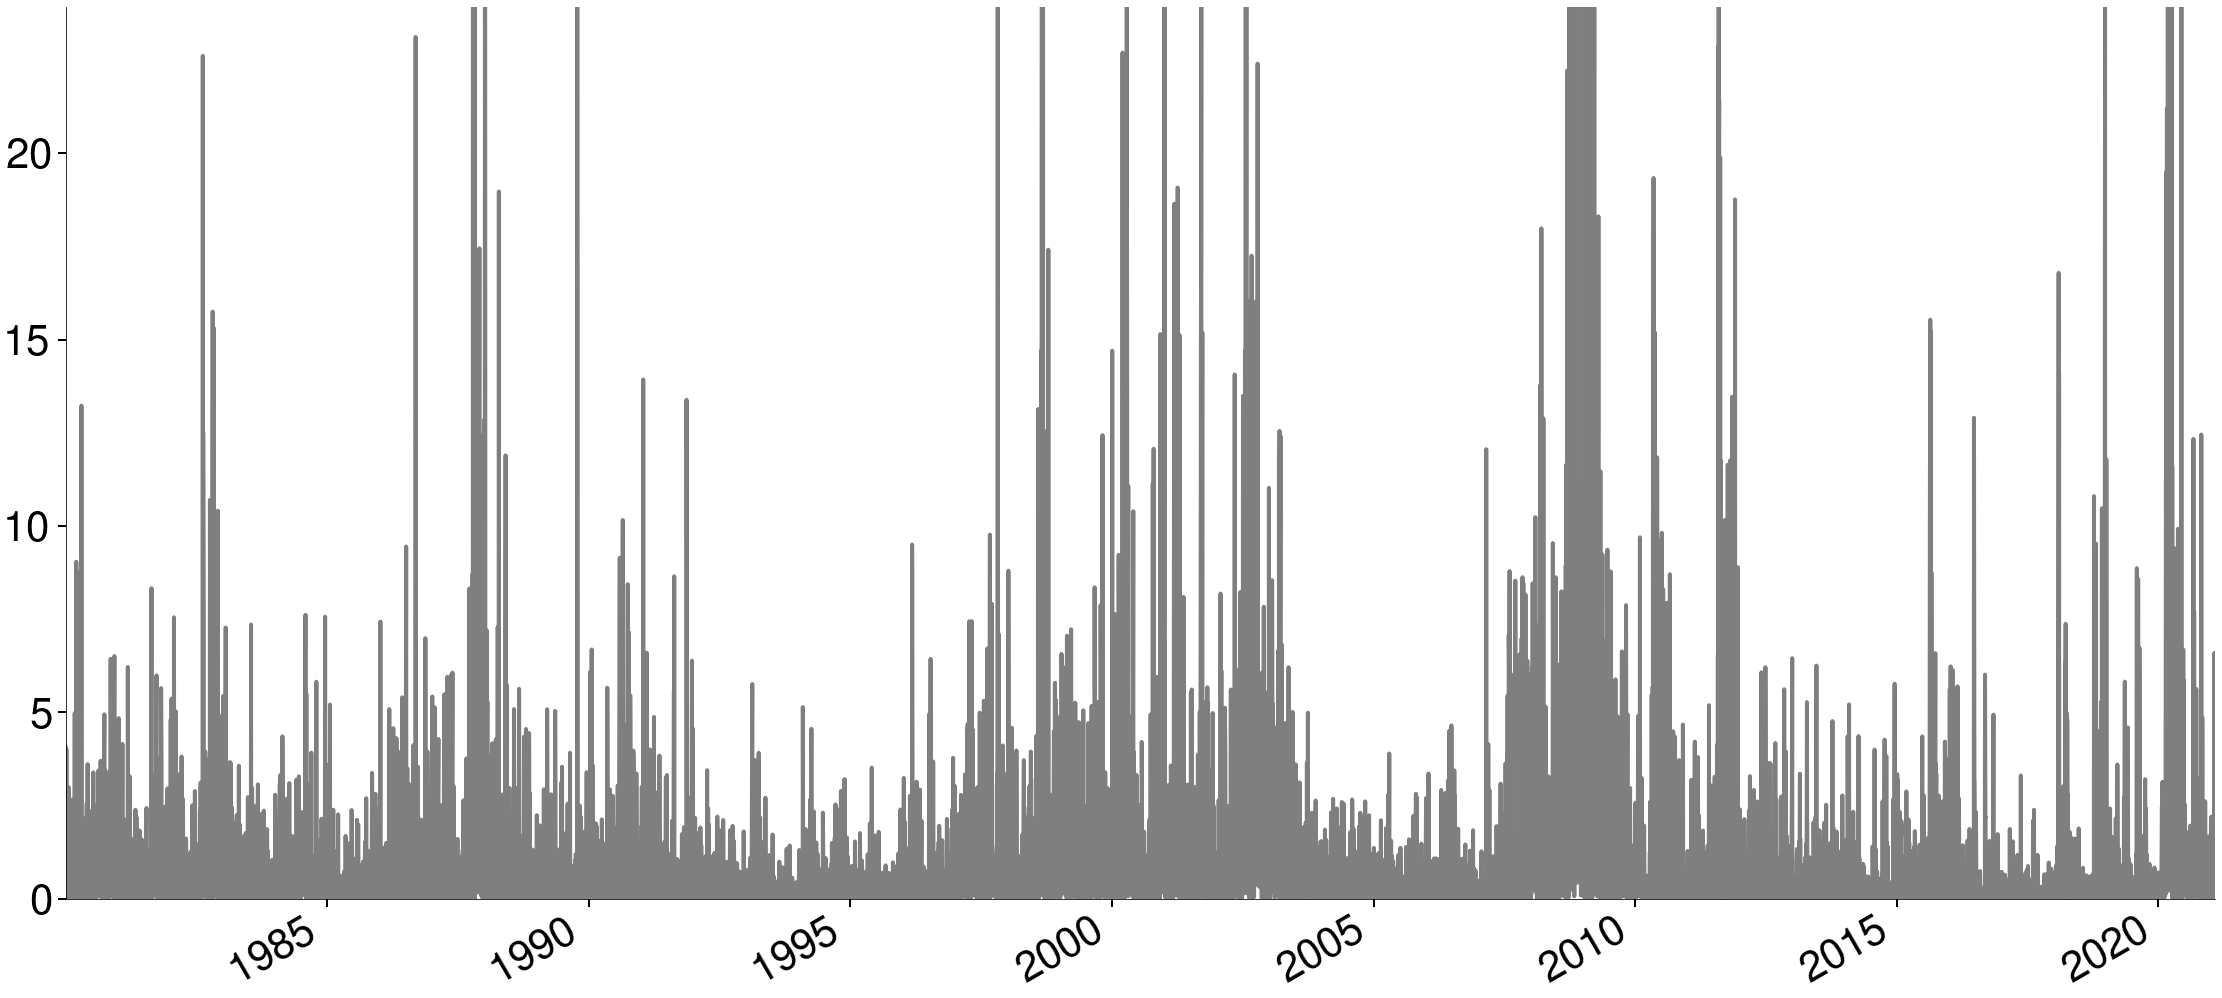

In [10]:
truncated_plot(sp500 ** 2, 99.5)

# $t_6$ IID Simulated Returns Squared

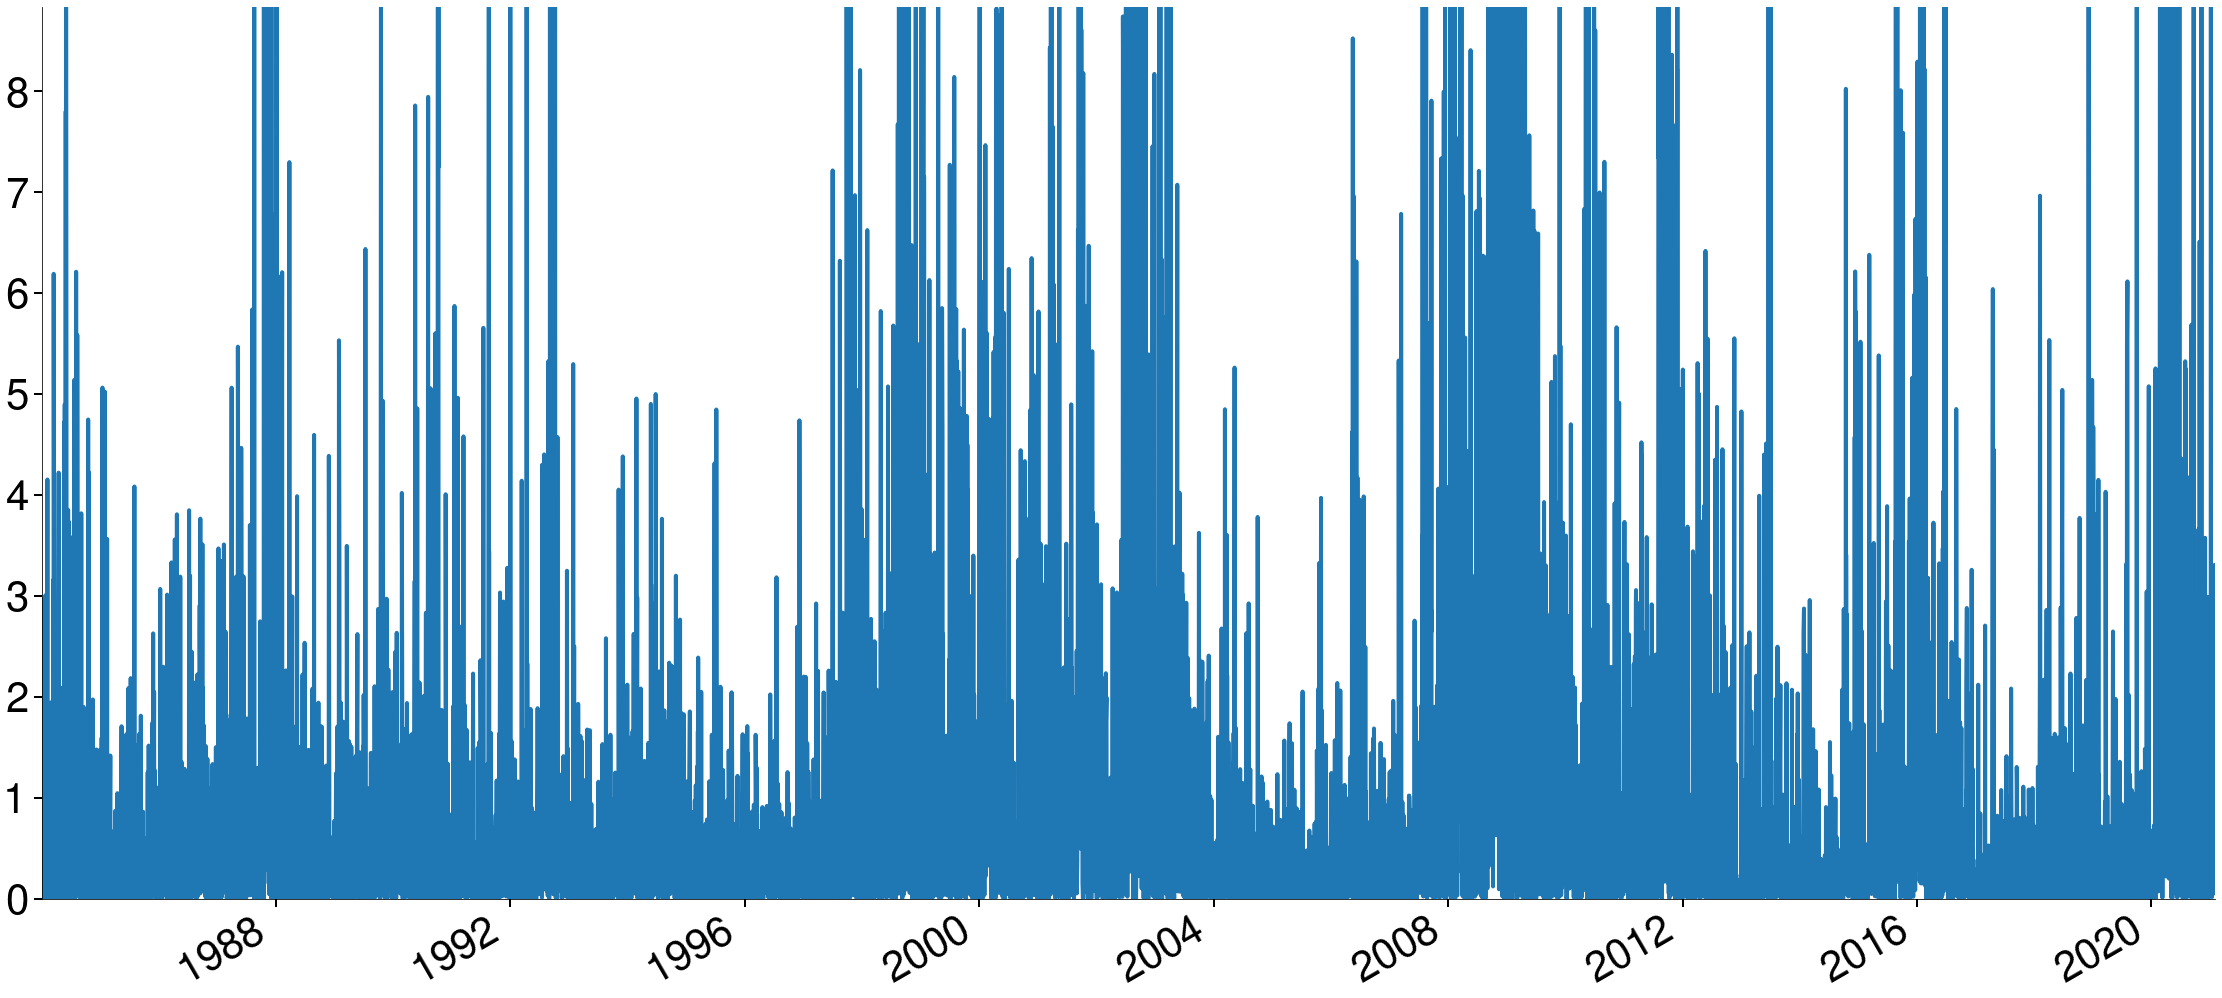

In [11]:
truncated_plot(ftse100 ** 2, 98)

# West Texas Intermediate Crude Squared Returns

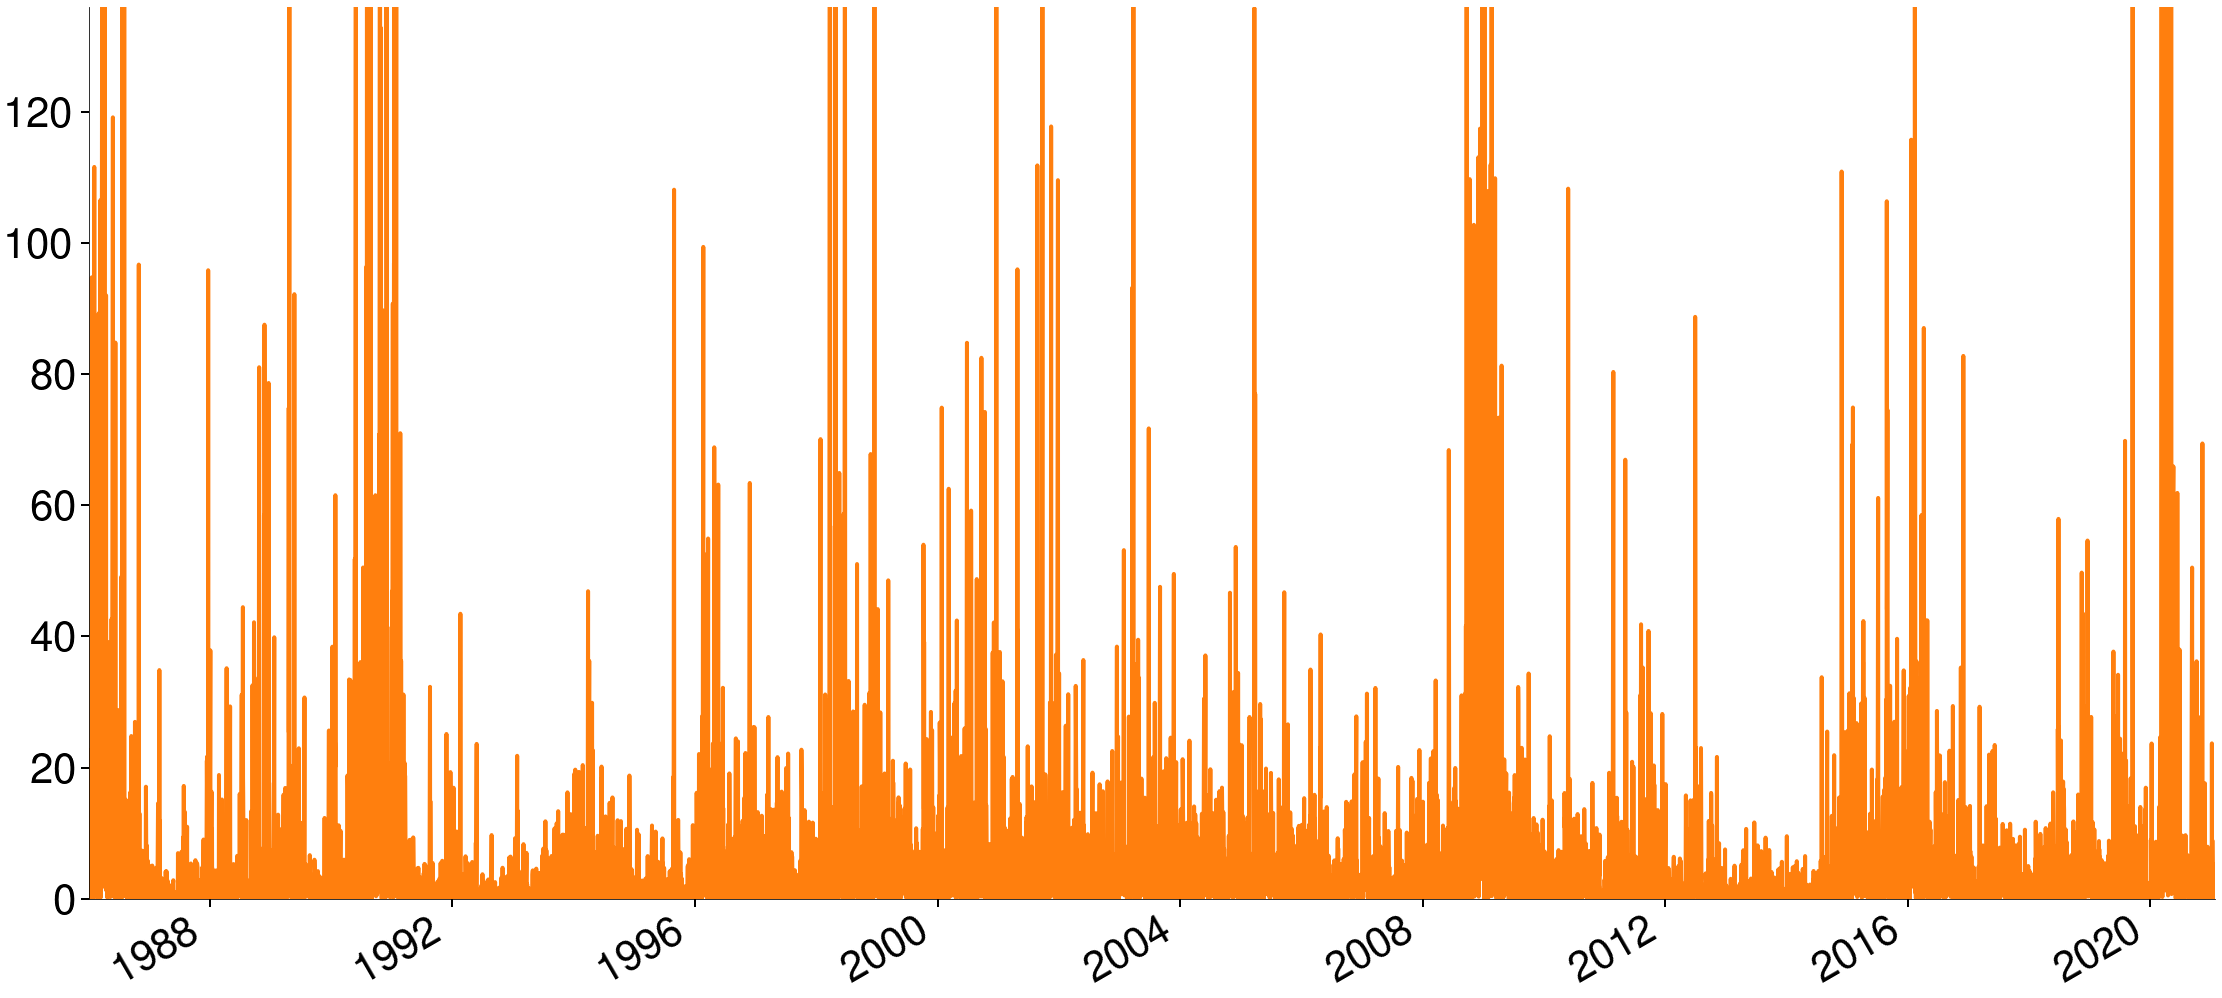

In [12]:
truncated_plot(wti ** 2, 99.5)

# S&P 500 Absolute Values

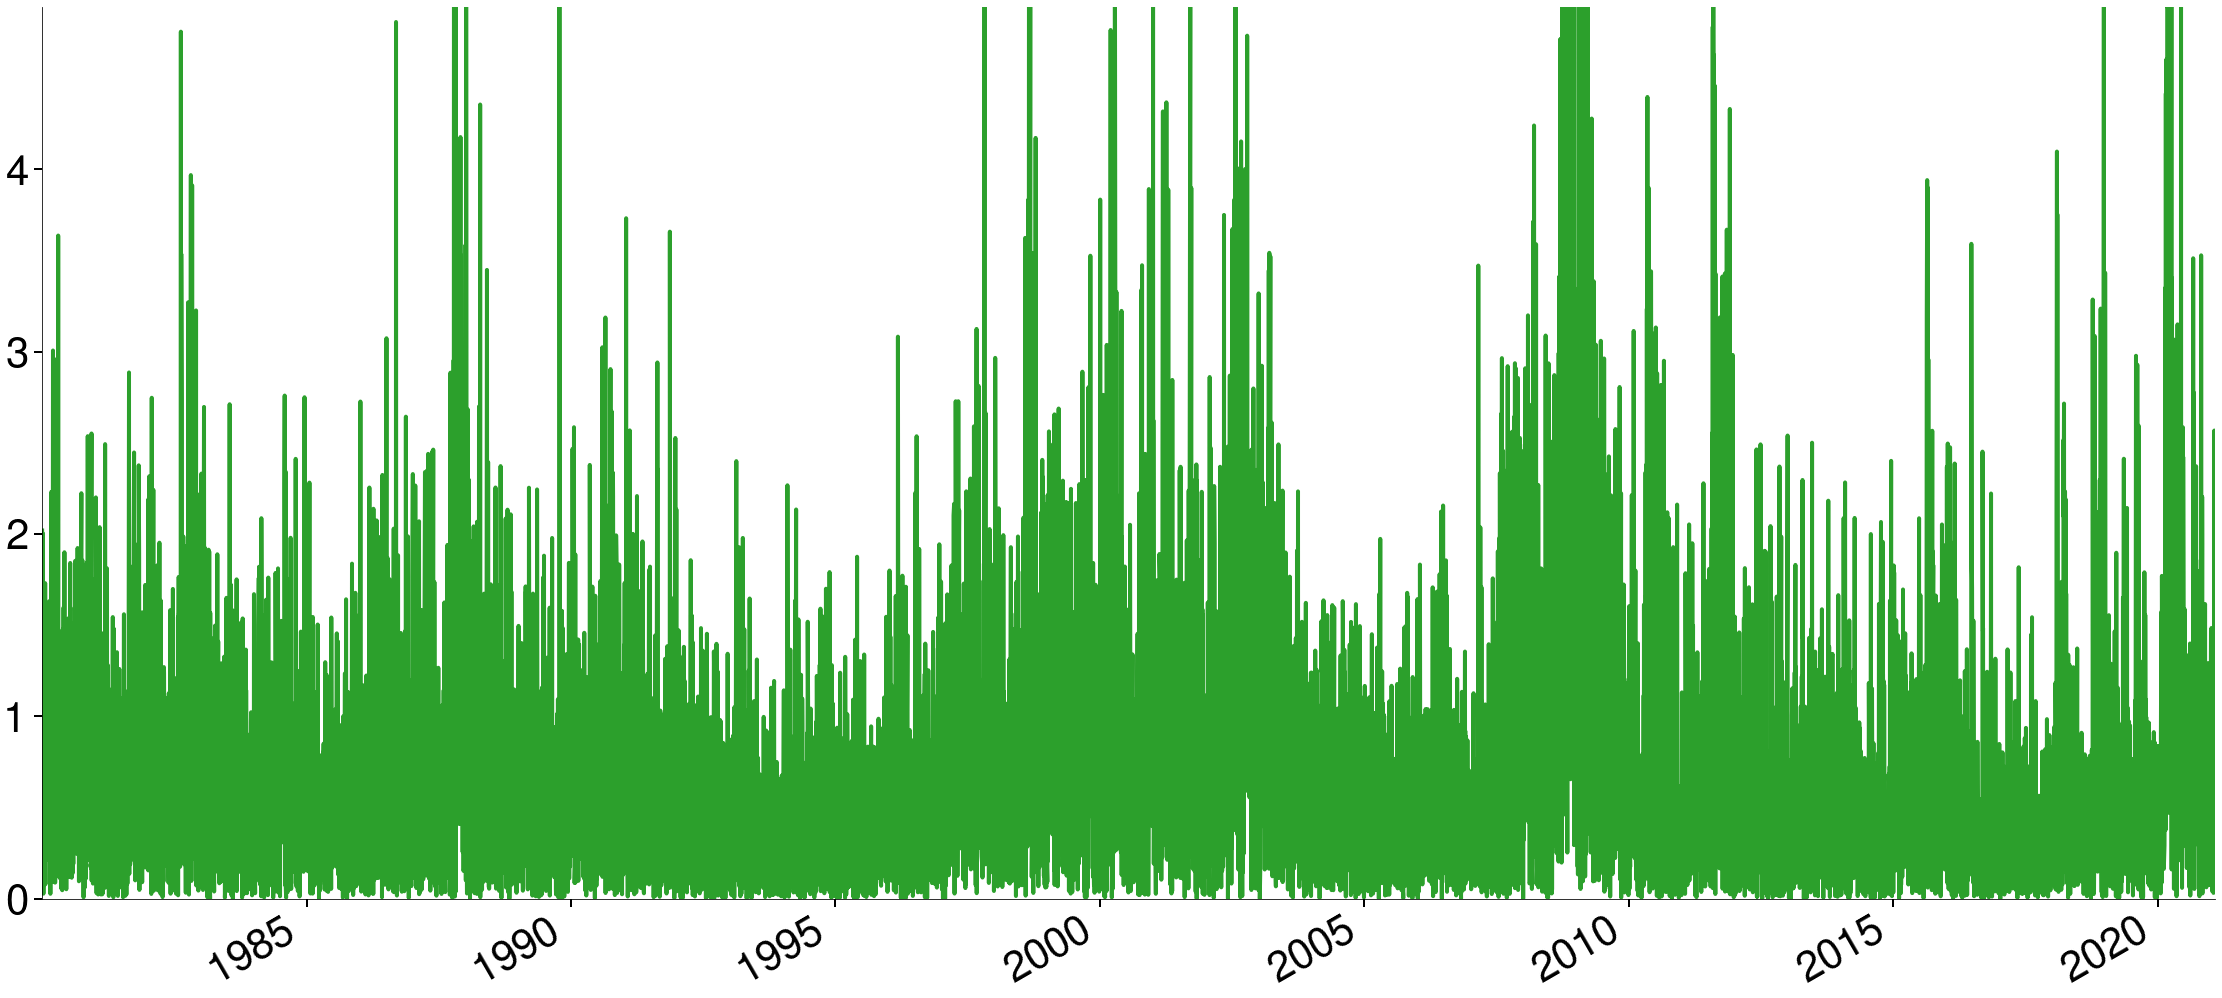

In [13]:
truncated_plot(np.abs(sp500), 99.5)

# $t_6$ IID Simulated Absolute Returns

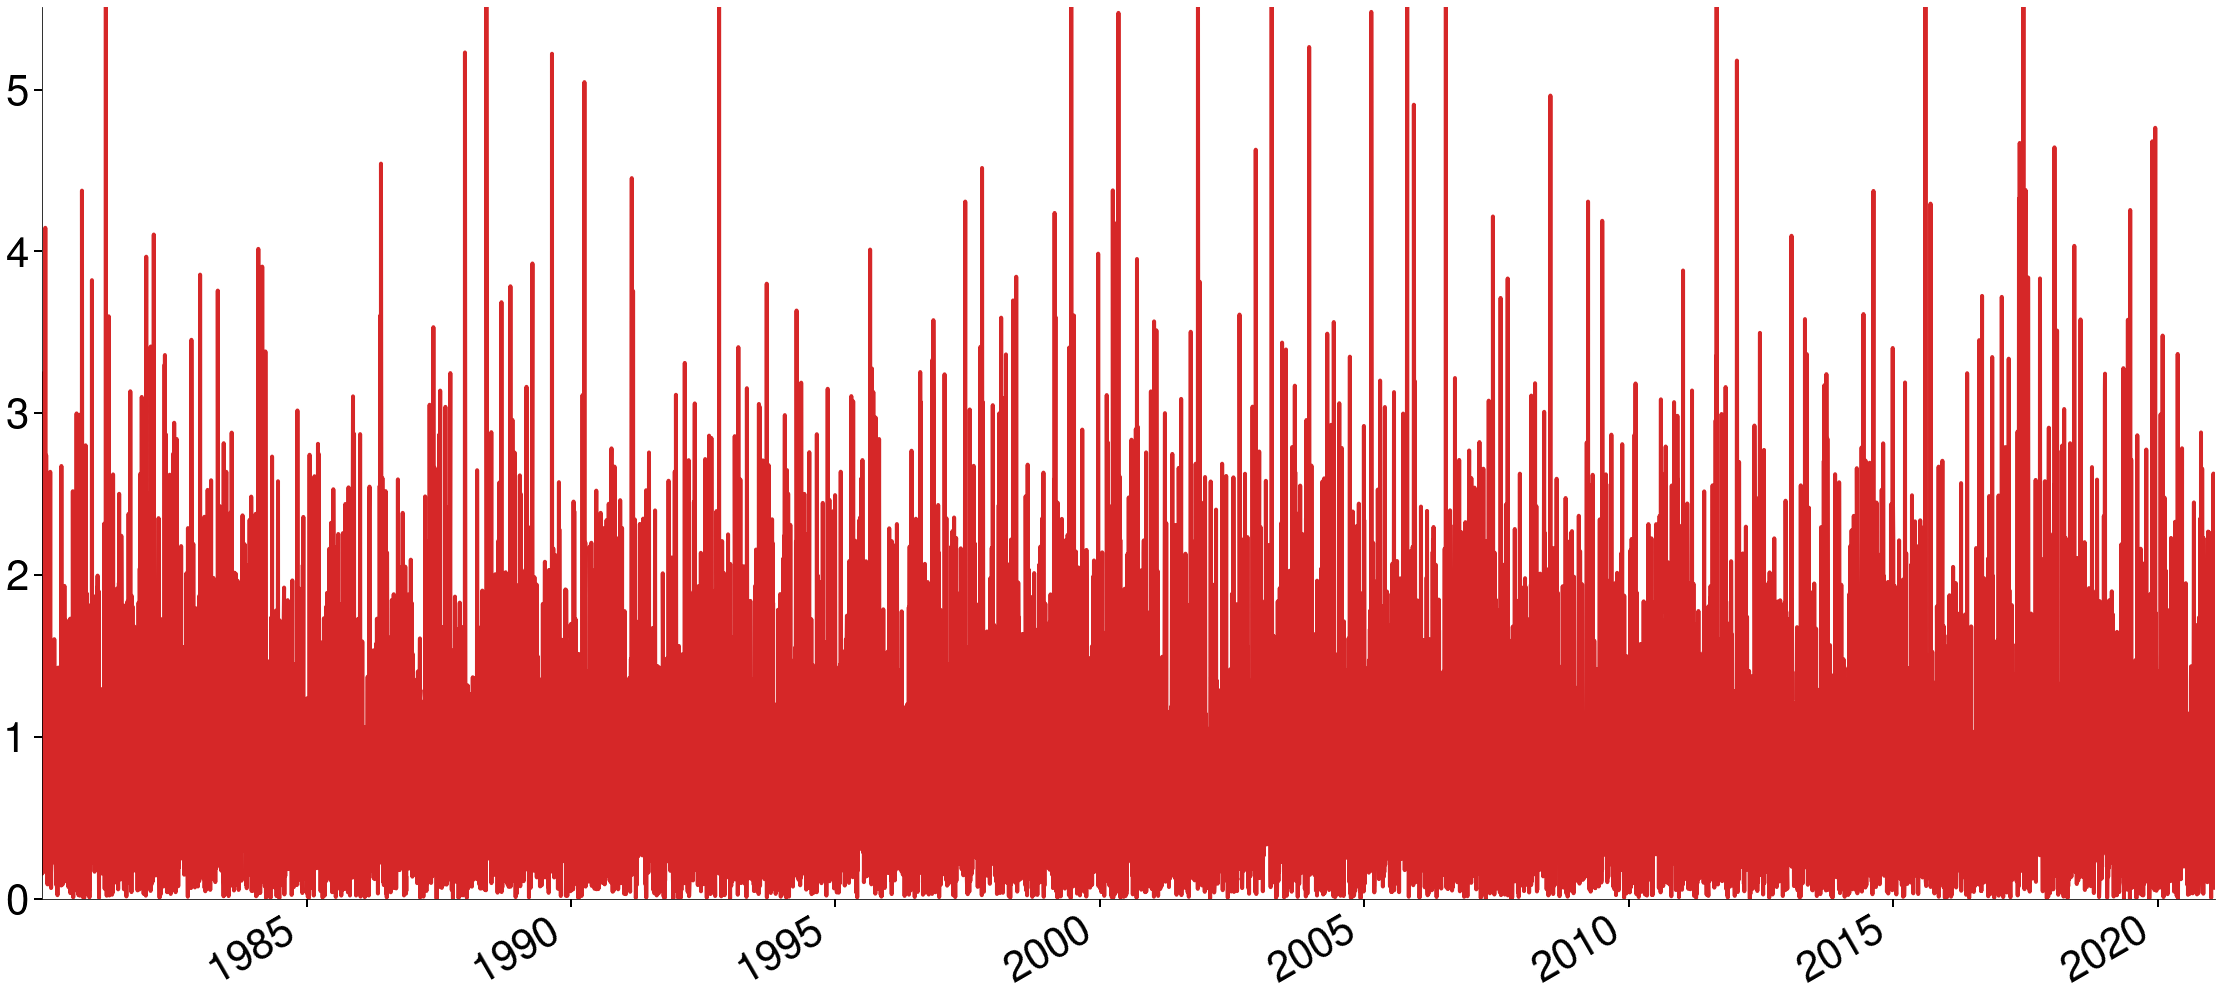

In [14]:
truncated_plot(np.abs(iid), 99.9)

# FTSE 100 Absolute Returns

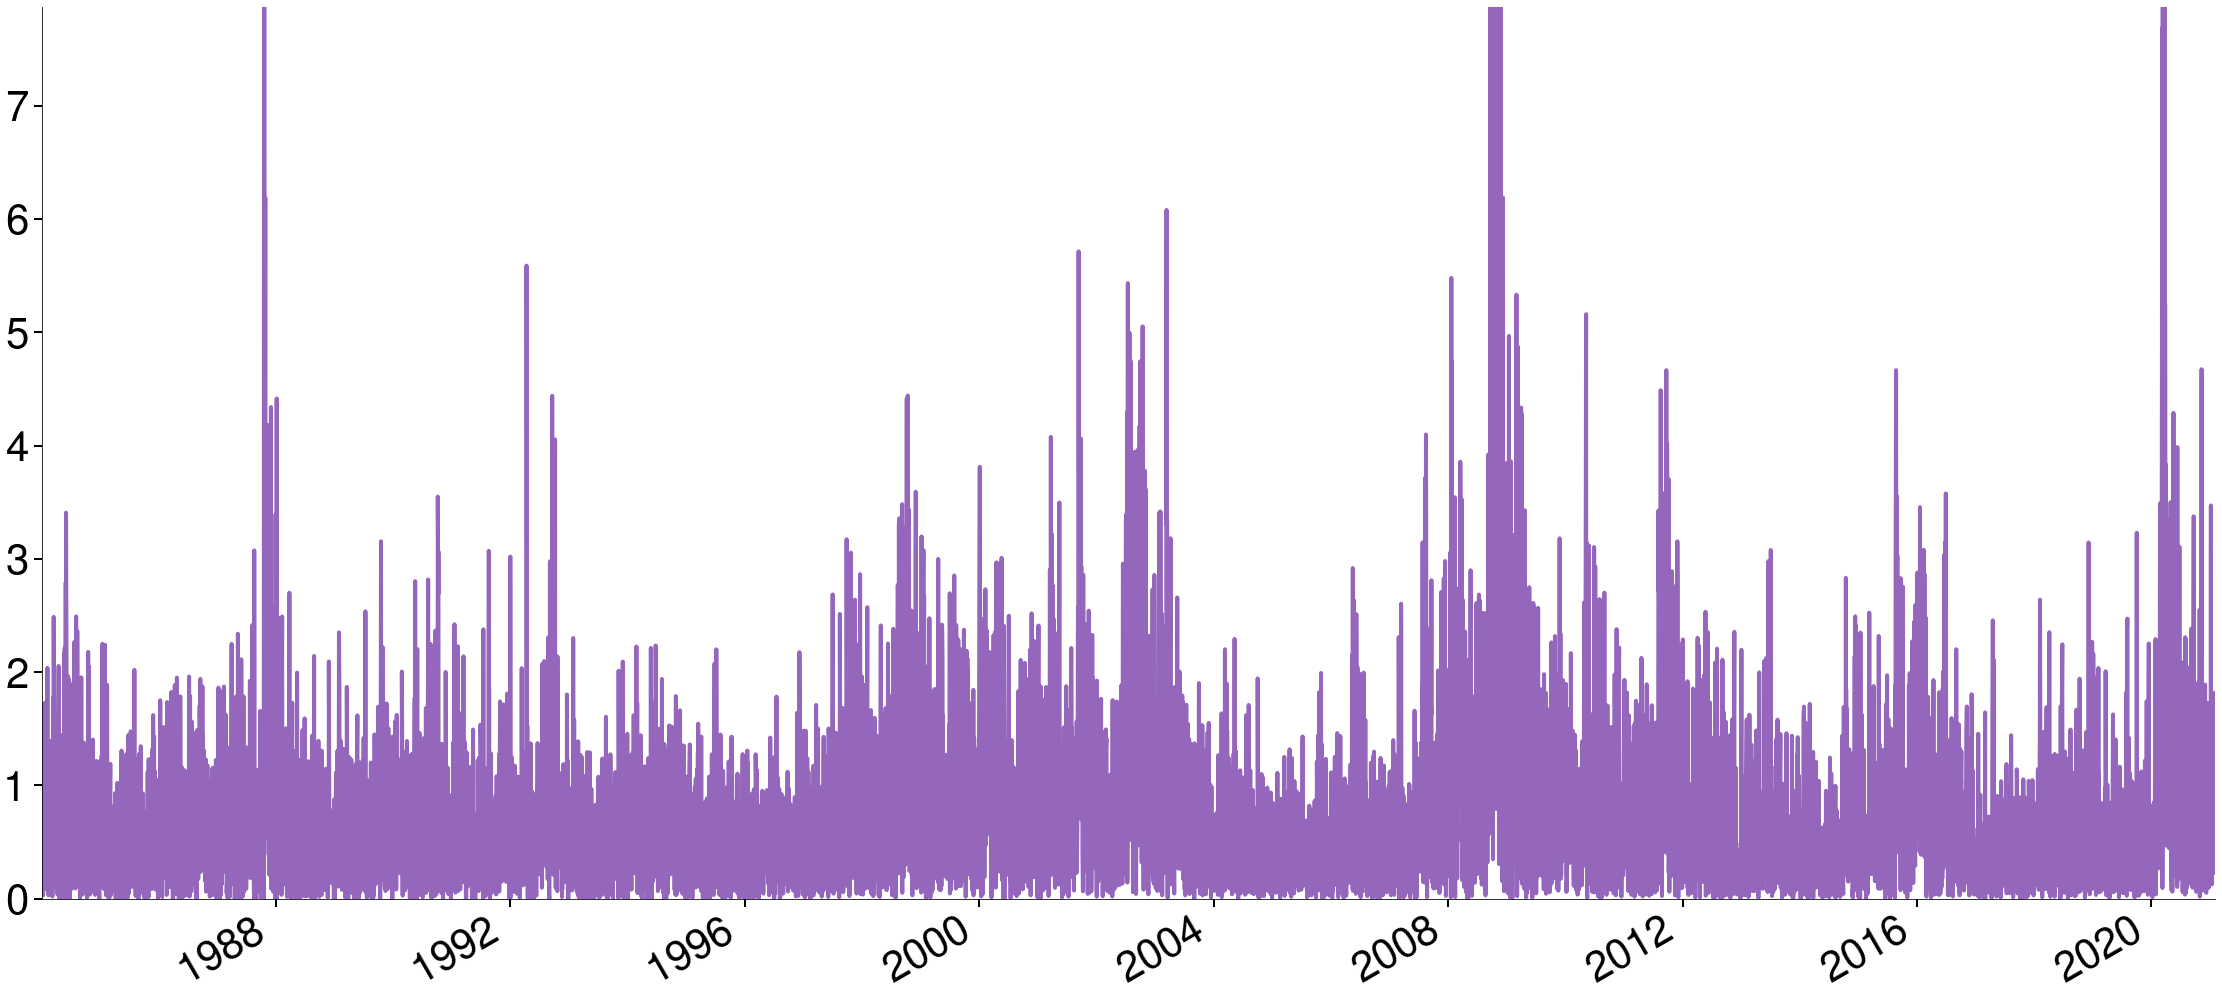

In [15]:
truncated_plot(np.abs(ftse100), 99.9)

# WTI Absolute Returns

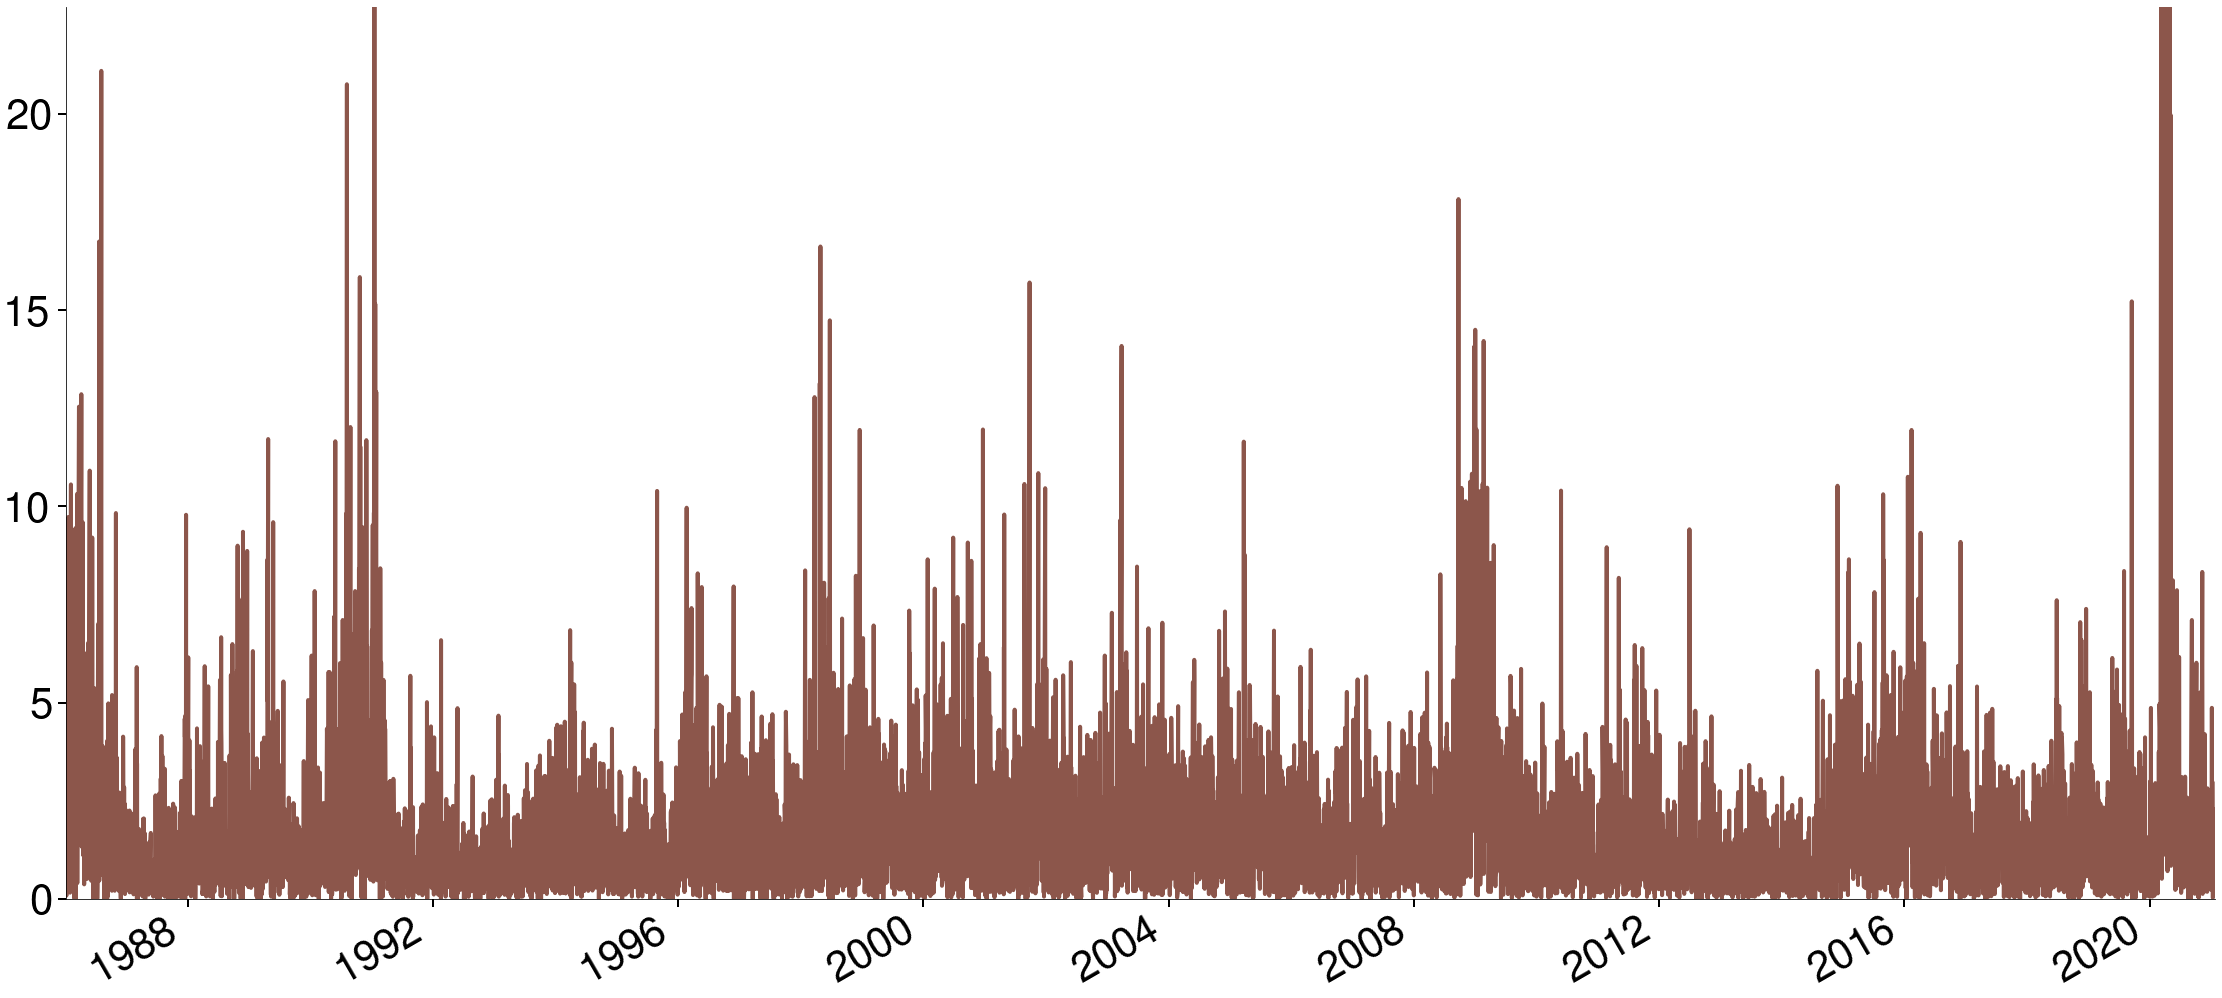

In [16]:
truncated_plot(np.abs(wti), 99.9)

# BitCoin Absolute Returns

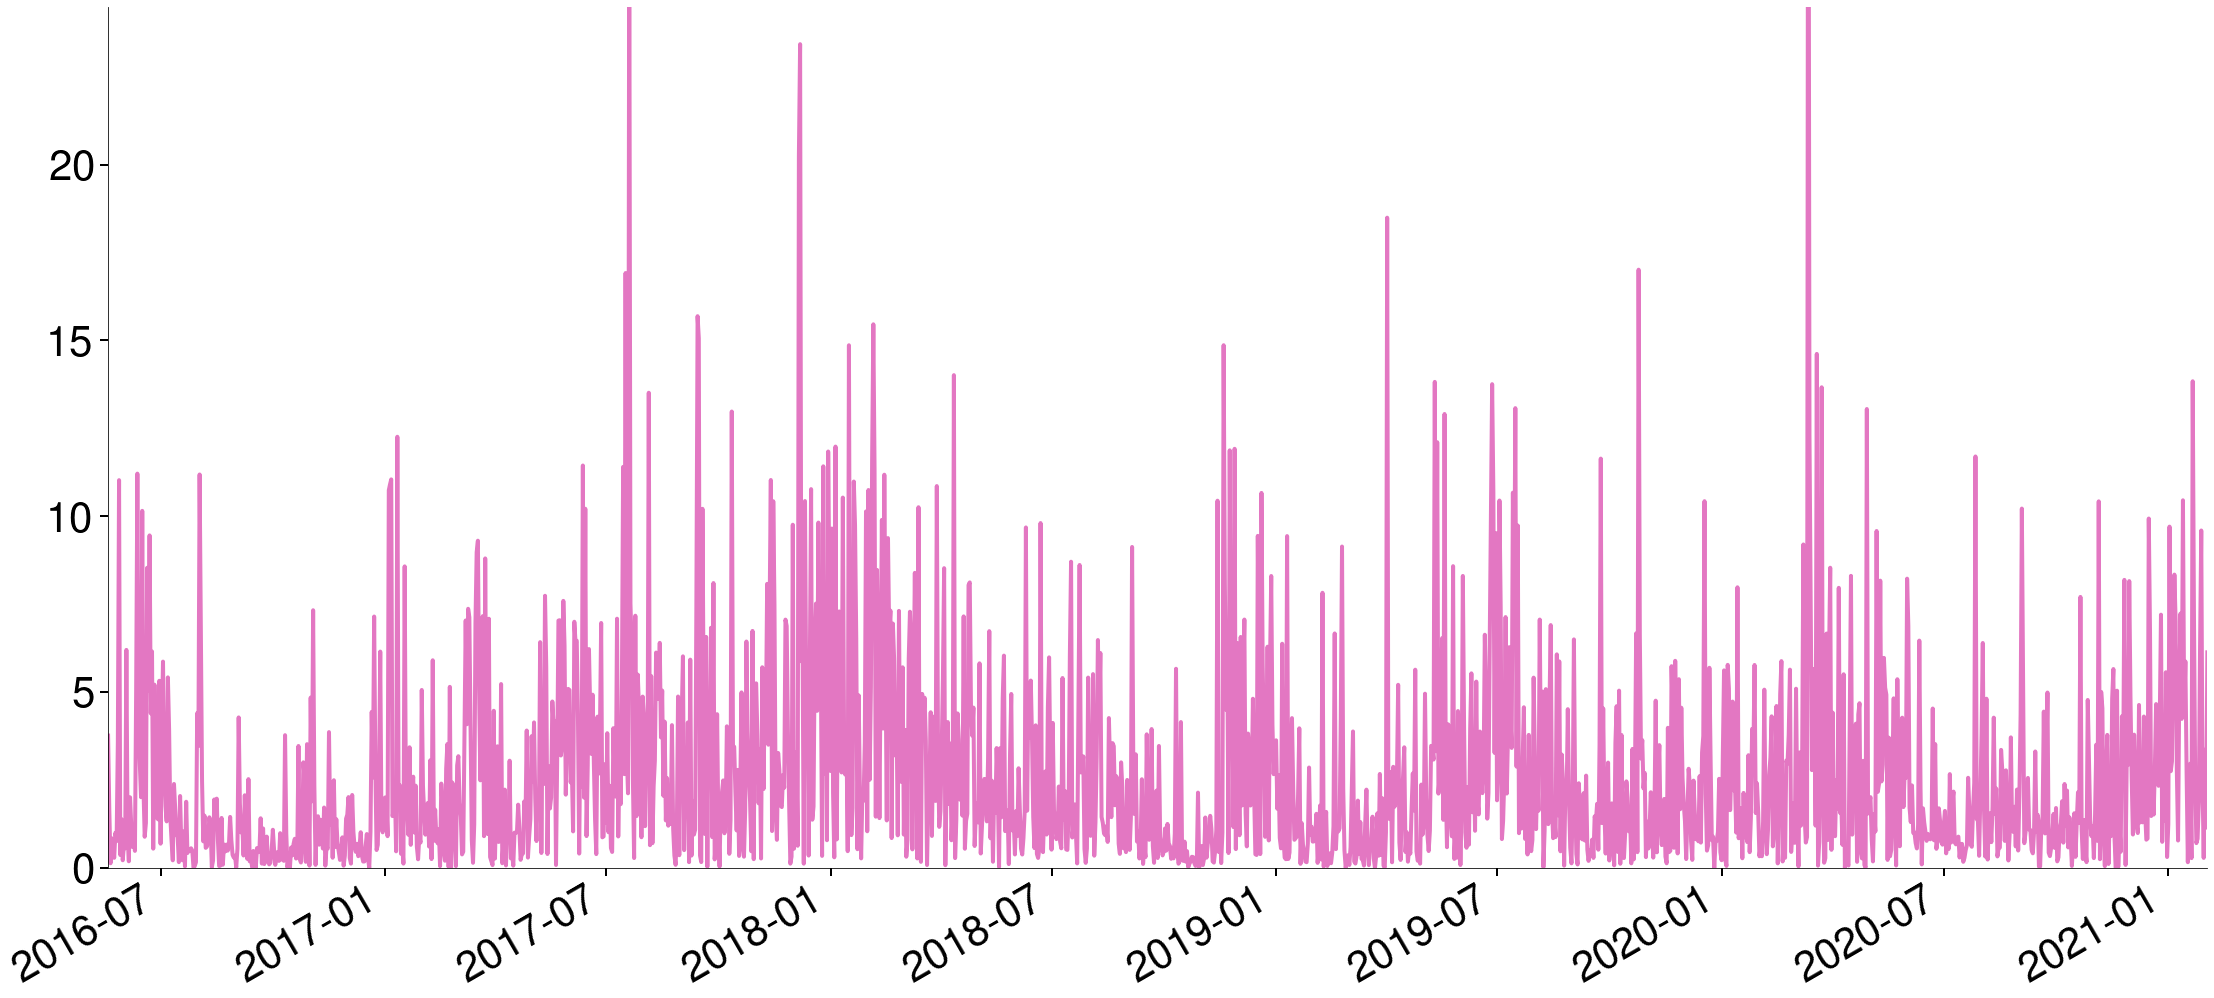

In [17]:
truncated_plot(np.abs(btc), 99.9)

# Formal Testing for Arch

* ARCH-LM test

$$ \hat{\epsilon}_t = r_t - E_{t-1}[r_t] $$

* Constant $E_{t-1}[r_t]=\mu$ here

$$ \hat{\epsilon}^2_t = \omega + \alpha_1 \hat{\epsilon}^2_{t-1}  + \alpha_2 \hat{\epsilon}^2_{t-2}  + \ldots + \alpha_p \hat{\epsilon}^2_{t-p}  + \eta_t $$

* Test statistic is $T\times R^2$
* $\chi^2_p$ distribution
* Virtually identical to White's test


In [18]:
from statsmodels.stats.diagnostic import het_arch
import seaborn as sns
import mfe
from scipy import stats

def arch_lm(rets, lags):
    res = {}
    for lag in range(1, lags+1):
        res[lag] = pd.Series(het_arch(rets - rets.mean(), lag)[:2],index=["ARCH LM","P-value"])
    df = pd.DataFrame(res).T
    fig, ax = plt.subplots(1,2)
    ax[0].bar(np.arange(1,lags+1), df.iloc[:,0])
    yellow = "#ffff00"
    ax[0].plot(np.arange(1,lags+1), stats.chi2.ppf(0.95, np.arange(1,lags+1)), marker="^", linestyle="none", markerfacecolor=yellow, markeredgecolor="k", markersize=48)
    ax[0].set_title("ARCH LM Statistic")
    ax[1].bar(np.arange(1,lags+1), 100*df.iloc[:,1], color=mfe.colors[1])
    ax[1].set_ylim(0,100)
    ax[1].set_yticks([20,40,60,80,100])
    ax[1].set_yticklabels([f"{v}\%" for v in ax[1].get_yticks()])
    ax[1].set_title("ARCH LM P-value")
    sns.despine()
    fig.tight_layout(pad=1.0)
   


# Testing the S&P 500

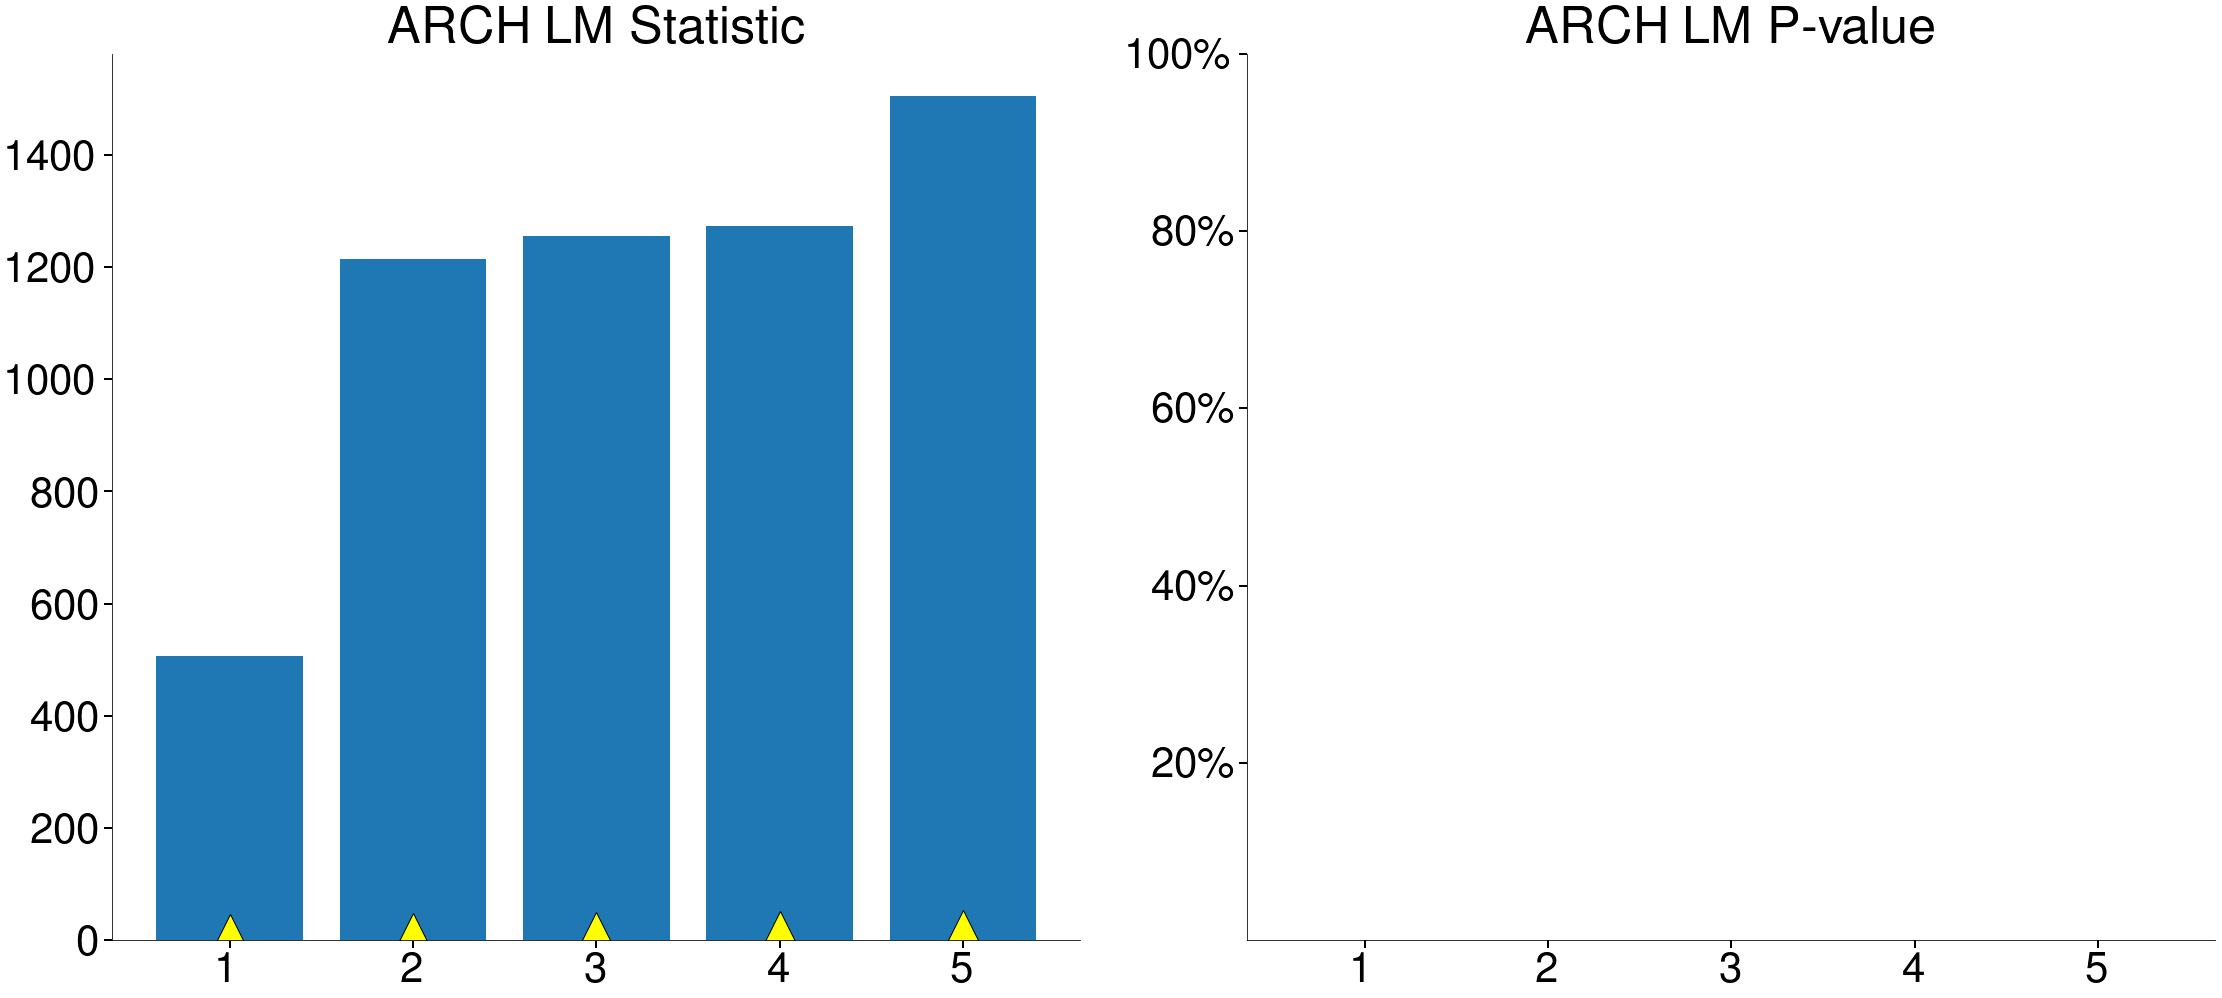

In [19]:
arch_lm(sp500, 5)

# S&P 500 between 2000 and 2009

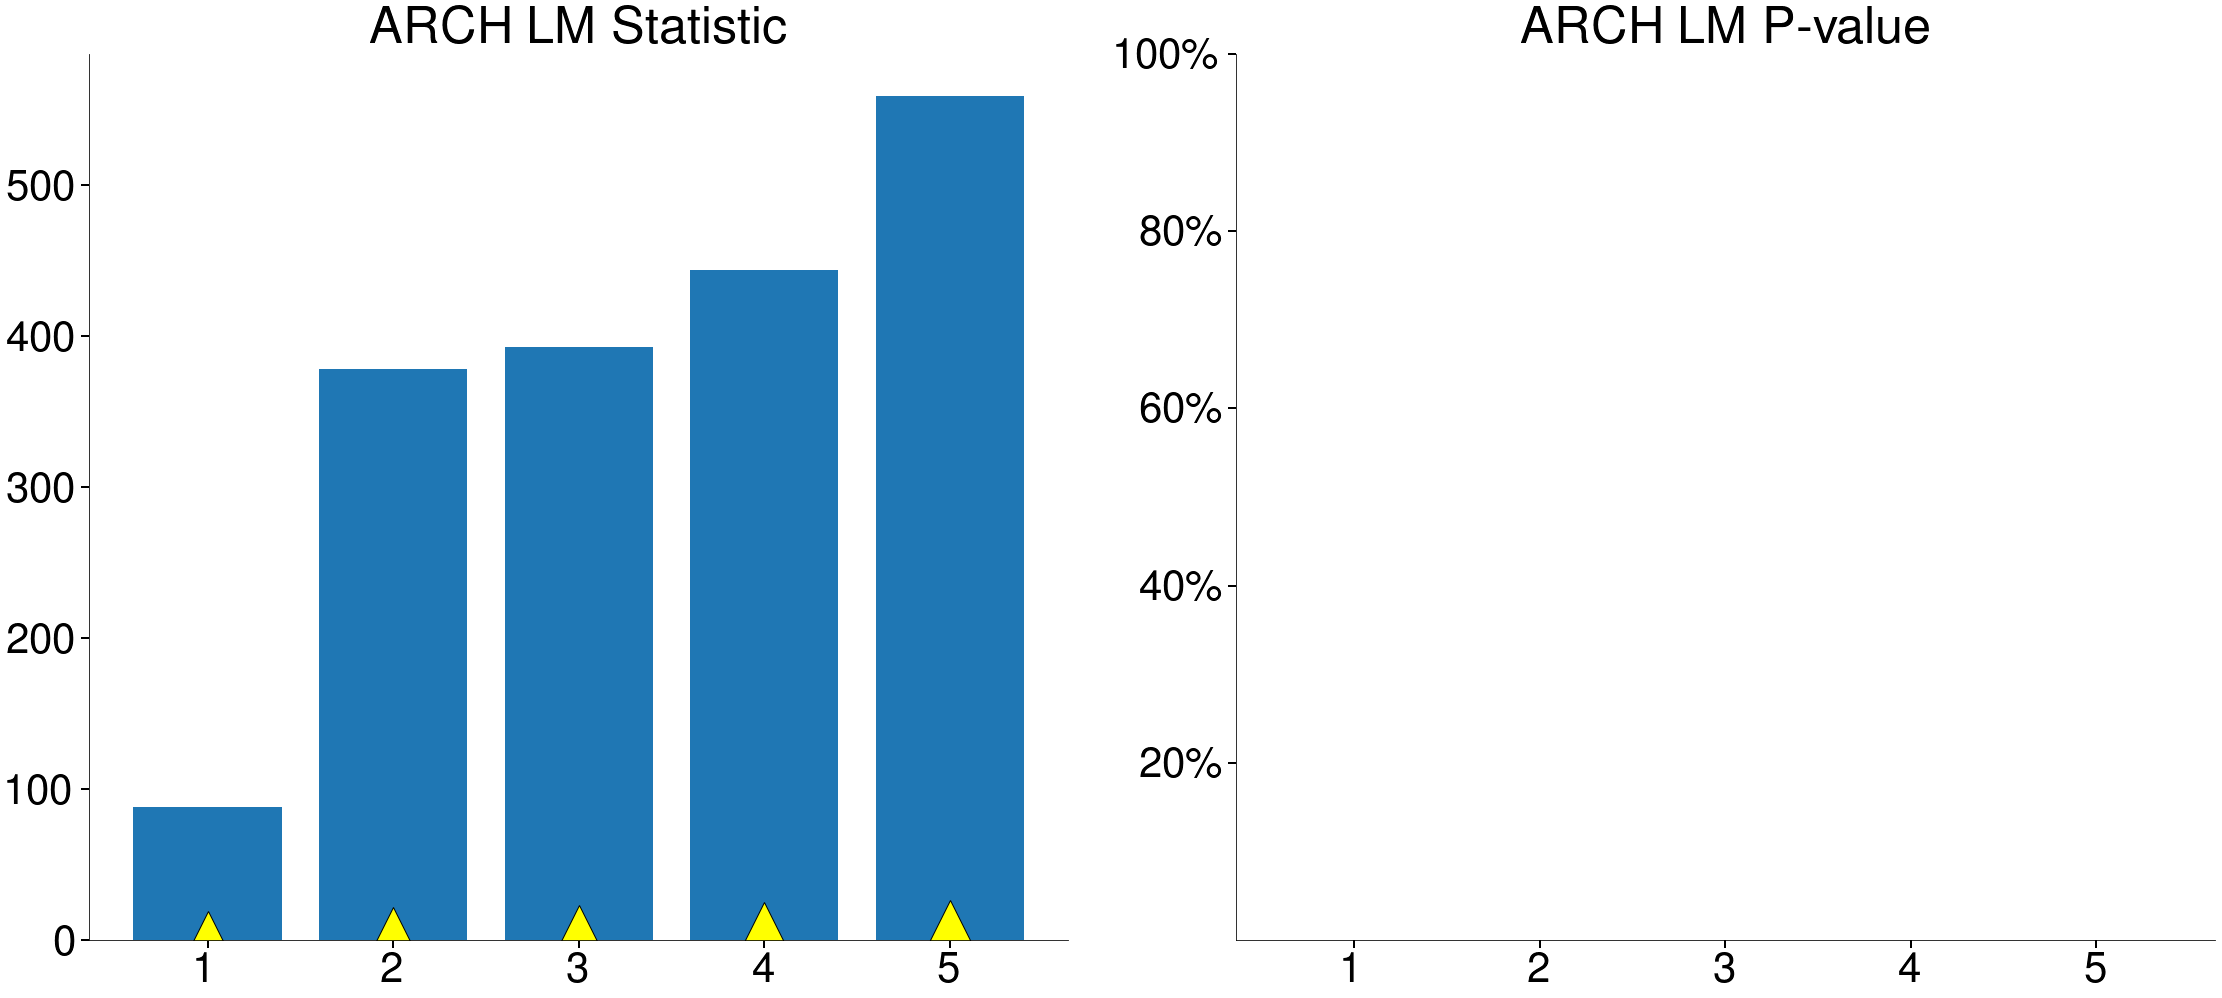

In [20]:
arch_lm(sp500["2000":"2009"], 5)

# Testing the S&P 500 in 2006

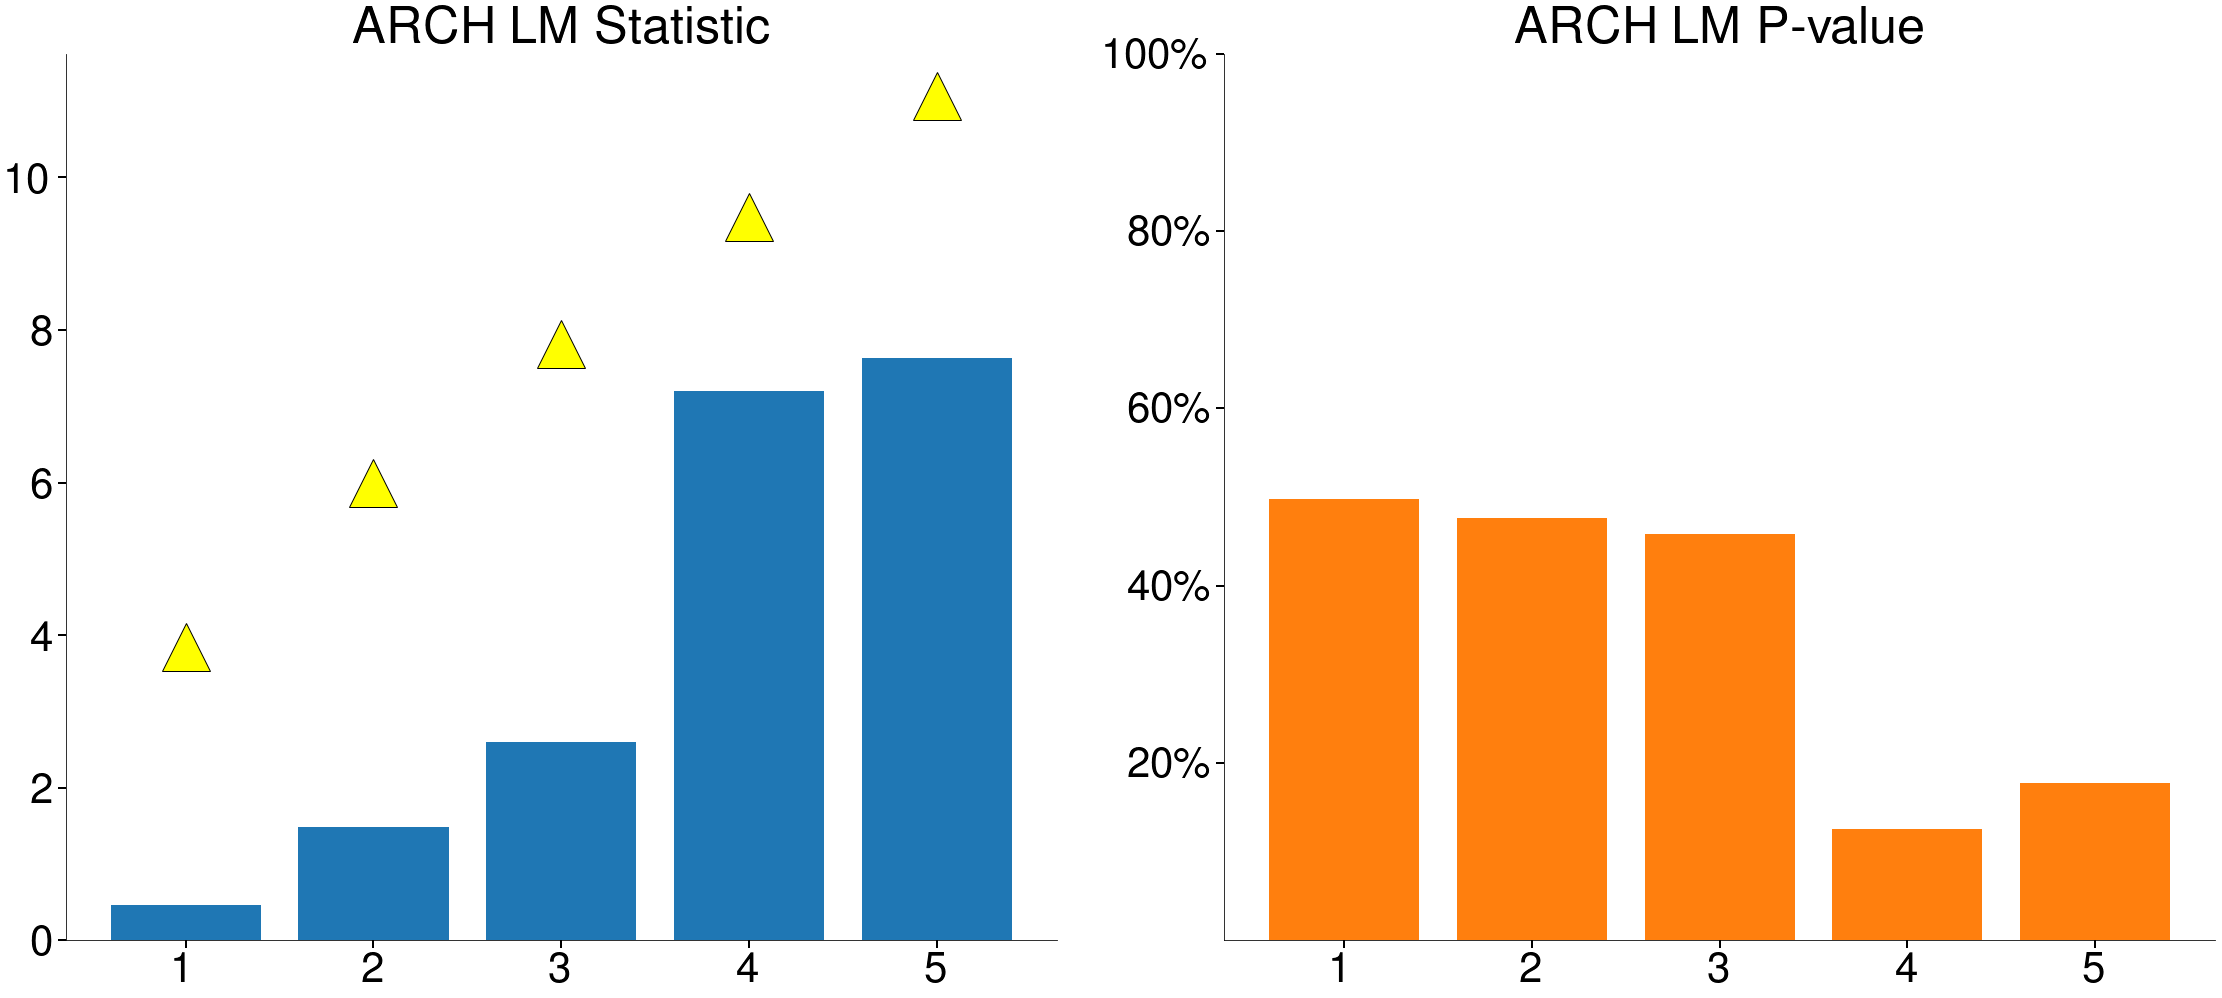

In [21]:
arch_lm(sp500["2006":"2006"], 5)

# S&P 500 in 2006

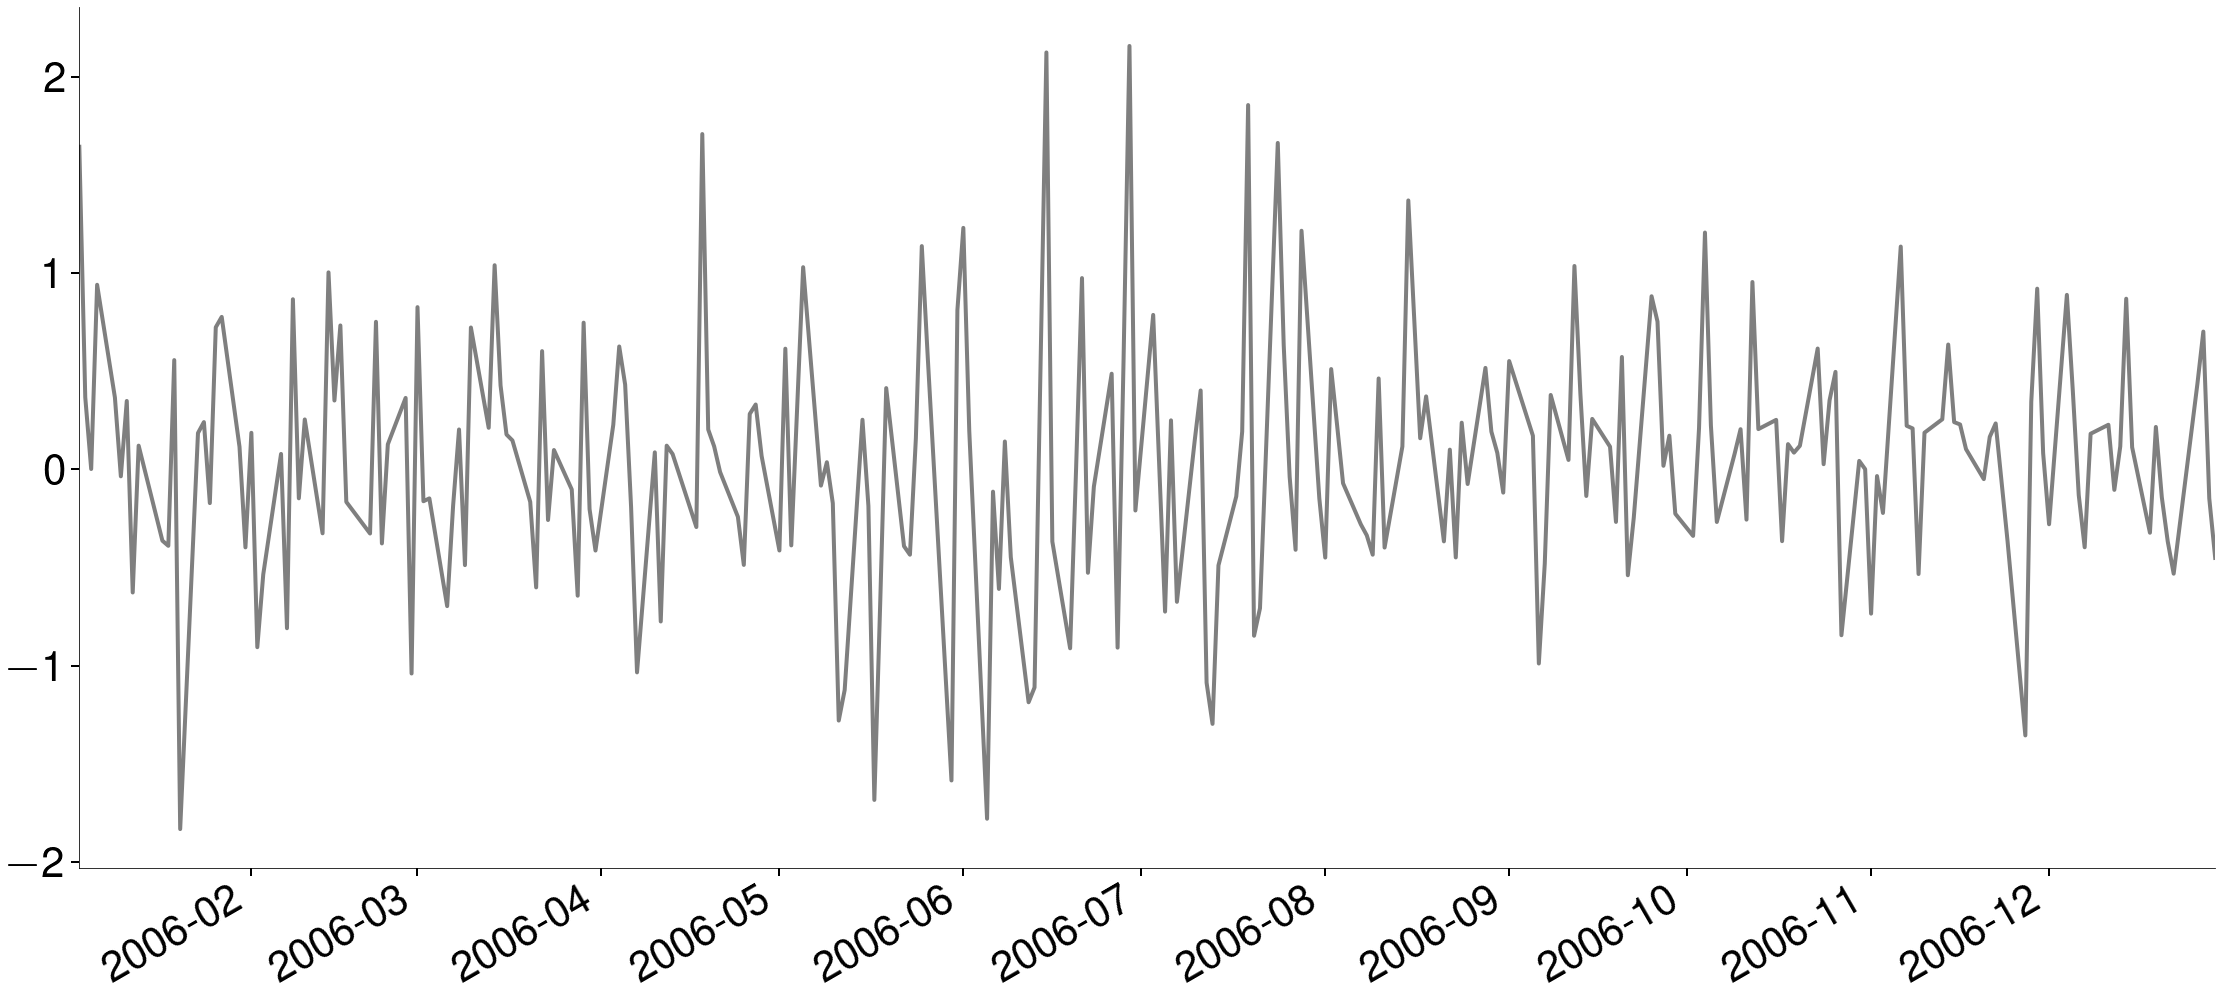

In [22]:
plot(sp500["2006":"2006"])

# BitCoin

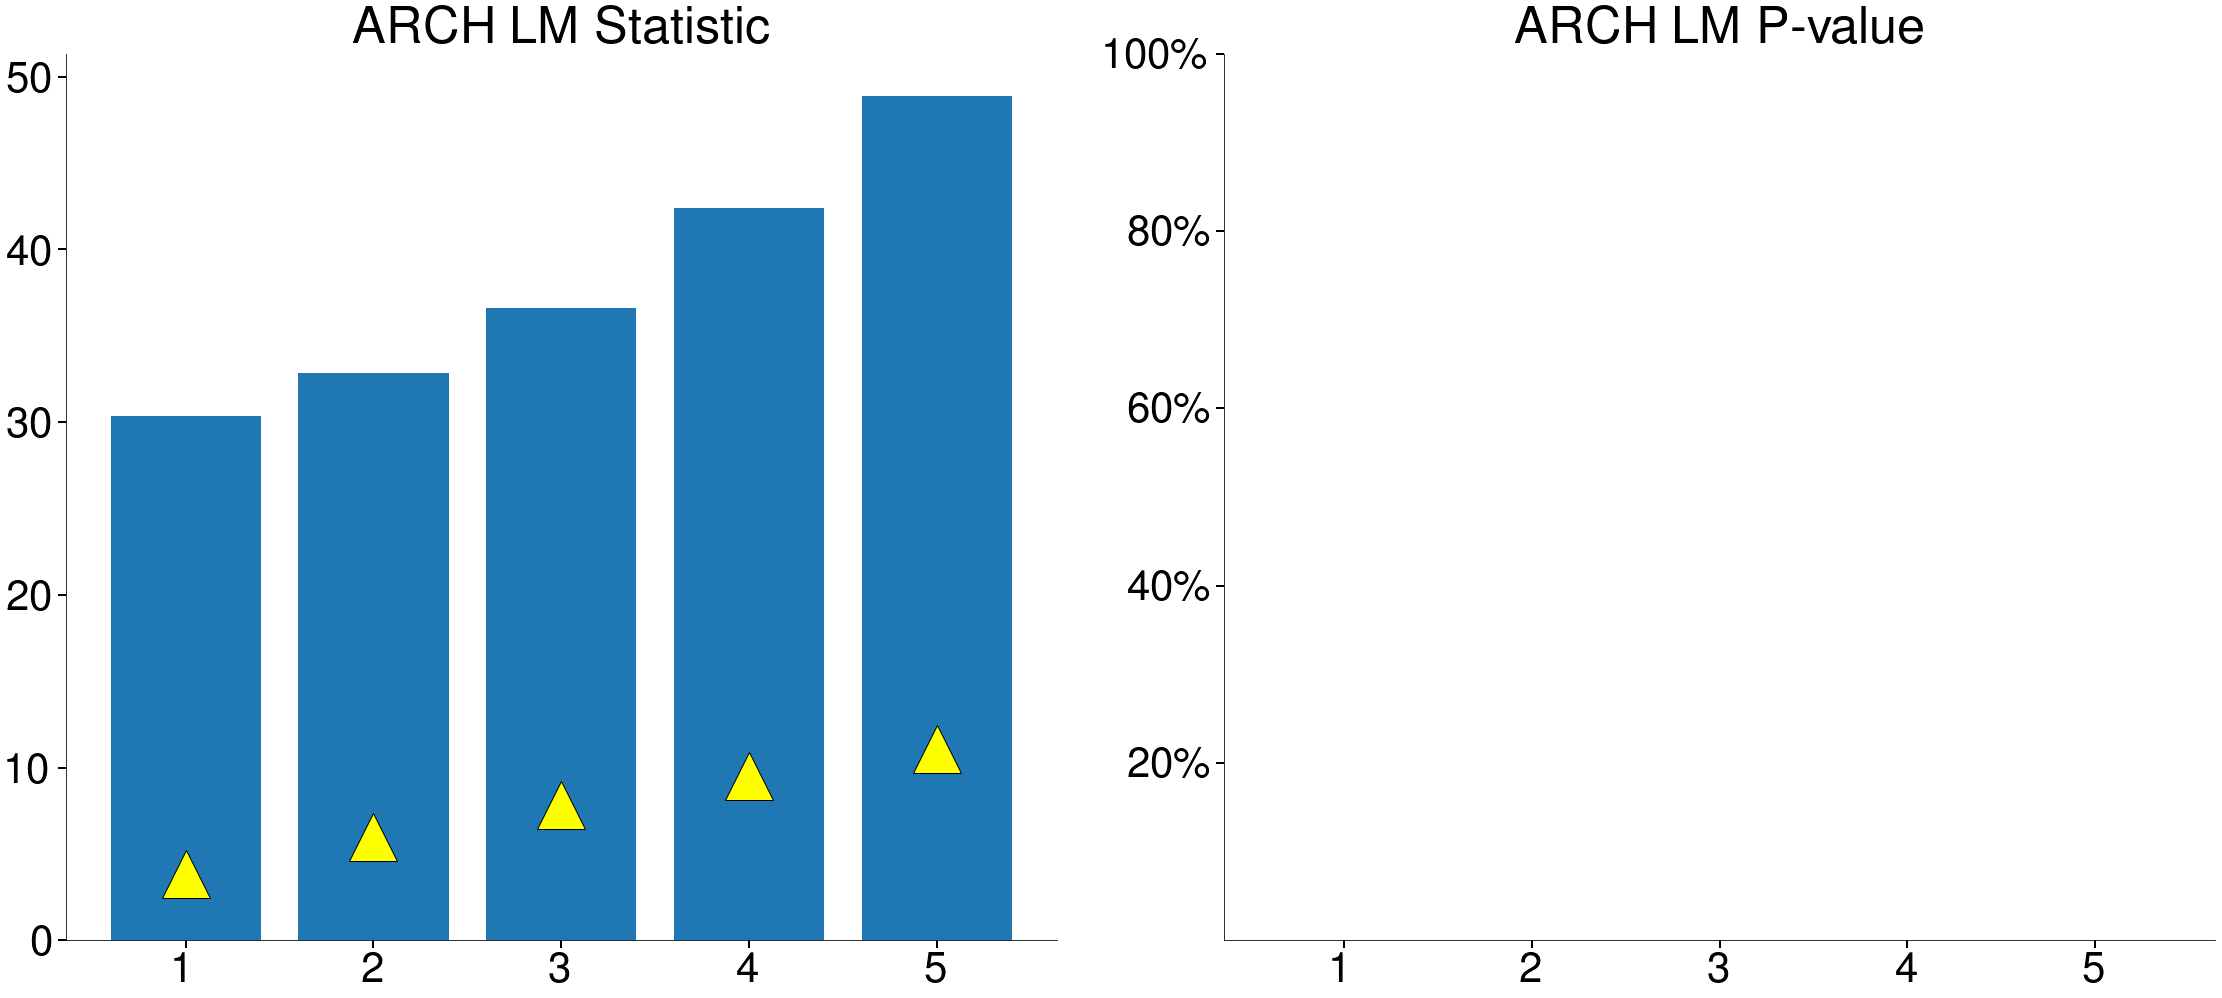

In [23]:
arch_lm(btc, 5)

# ARCH Models

* Initial effort at volatility modeling

* Basic ARCH(1)

$$ 
\begin{align*}
\epsilon_t & = r_t - \mu_t \\
\sigma_t^2 & = \omega + \alpha_1 \epsilon_{t-1}^2 \\
\epsilon_t & = \sigma_t e_t \\
e_t & \stackrel{iid}{\sim} N(0,1) \\
\end{align*}
$$

* $\mu_t$ can be any mean model as long as $\in \mathcal{F}_{t-1}$
  * ARMA(P,Q)
* Complete ARCH(P)

$$ \sigma_t^2 = \omega + \alpha_1 \epsilon_{t-1}^2 + \ldots + \alpha_P \epsilon_{t-P}^2 $$

* In practice needs many lags

In [24]:
from statsmodels.iolib.summary import Summary, fmt_2cols, fmt_params
from statsmodels.iolib import SimpleTable
def summary(res, head=True, mean=True):
    model = res.model
    model_name = model.name + " - " + model.volatility.name
    # Summary Header
    top_left = [
        ("Mean Model:", model.name),
        ("Vol Model:", model.volatility.name),
        ("Distribution:", model.distribution.name),
    ]

    top_right = [
        ("Log-Likelihood:", "%#10.6g" % res.loglikelihood),
        ("AIC:", "%#10.6g" % res.aic),
        ("BIC:", "%#10.6g" % res.bic),
    ]

    title = model_name + " Model Results"
    stubs = []
    vals = []
    for stub, val in top_left:
        stubs.append(stub)
        vals.append([val])
    table = SimpleTable(vals, txt_fmt=fmt_2cols, title=title, stubs=stubs)
    fmt = fmt_2cols
    fmt["data_fmts"][1] = "%18s"

    top_right = [("%-21s" % ("  " + k), v) for k, v in top_right]
    stubs = []
    vals = []
    for stub, val in top_right:
        stubs.append(stub)
        vals.append([val])
    table.extend_right(SimpleTable(vals, stubs=stubs))
    
    s = Summary()
    if head:
        s.tables.append(table)
    if mean:
        s.tables.extend(res.summary().tables[1:])
    else:
        s.tables.extend(res.summary().tables[2:])
    return s

# ARCH(1)

In [25]:
summary(arch_model(ftse100, vol="arch", p=1).fit(disp="off"))

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Mean Model:             Constant Mean   Log-Likelihood:               -13702.5
Vol Model:                       ARCH   AIC:                           27411.0
Distribution:                  Normal   BIC:                           27432.4
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0419  1.094e-02      3.825  1.306e-04 [2.041e-02,6.330e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.8039  3.470e-02     23.172 8.785e-119 [  0.736,  0.872]
alpha[1]       0.3505  3.970e-02      8.828  1.066e-18 [  0.273,  0.428]
========================================================================
"""

# ARCH(5)

In [26]:
summary(arch_model(ftse100, vol="arch", p=5).fit(disp="off"))

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Mean Model:             Constant Mean   Log-Likelihood:               -12834.2
Vol Model:                       ARCH   AIC:                           25682.4
Distribution:                  Normal   BIC:                           25732.4
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0511  9.097e-03      5.614  1.971e-08 [3.325e-02,6.891e-02]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.3335  1.650e-02     20.219  6.670e-91   [  0.301,  0.366]
alpha[1]       0.1202  1.927e-02      6.241  4.362e-10 [8.248e-02,  0.158]
alpha[2]       0.1685  1.788e-02      9.426  4.275e-21   [  0.133,  0.204]
alpha[3]       0.1683  2.238e-02      7.519  5.504e-14   [  0.124,  0.212]
alpha[4]       0.1429  1.717e-02      8.319  8.888e-17   [  0.109,  0.177]
alpha[5]       0.1314  2.069e-02      6.349  2.173e-10 [9.082e-02,  0.172]
==========================================================================
"""

# ARCH(15)

In [27]:
def plot_arch(lags):
    res = arch_model(ftse100, vol="arch", p=lags).fit(disp="off")
    fig,ax = plt.subplots(2,1)
    ax[0].bar(np.arange(1,lags+1), res.params.iloc[2:])
    ax[1].bar(np.arange(1,lags+1), res.pvalues.iloc[2:], color=mfe.colors[1])
    ax[0].set_xlim(0.5,lags+0.5)
    ax[0].set_ylim(0,ax[0].get_ylim()[1])
    ax[1].plot([0,lags+1],[0.05,0.05],"k:",zorder=2)
    ax[1].set_xlim(0.5,lags+0.5)
    ax[1].set_ylim(0,1)
    ax[1].set_xticks(np.arange(1,lags+1))
    ax[1].set_title("P-value")
    ax[0].set_title(r"$\hat{\alpha}$")
    ax[0].set_xticks(np.arange(1,lags+1))
    sns.despine()
    fig.tight_layout(pad=1.0)

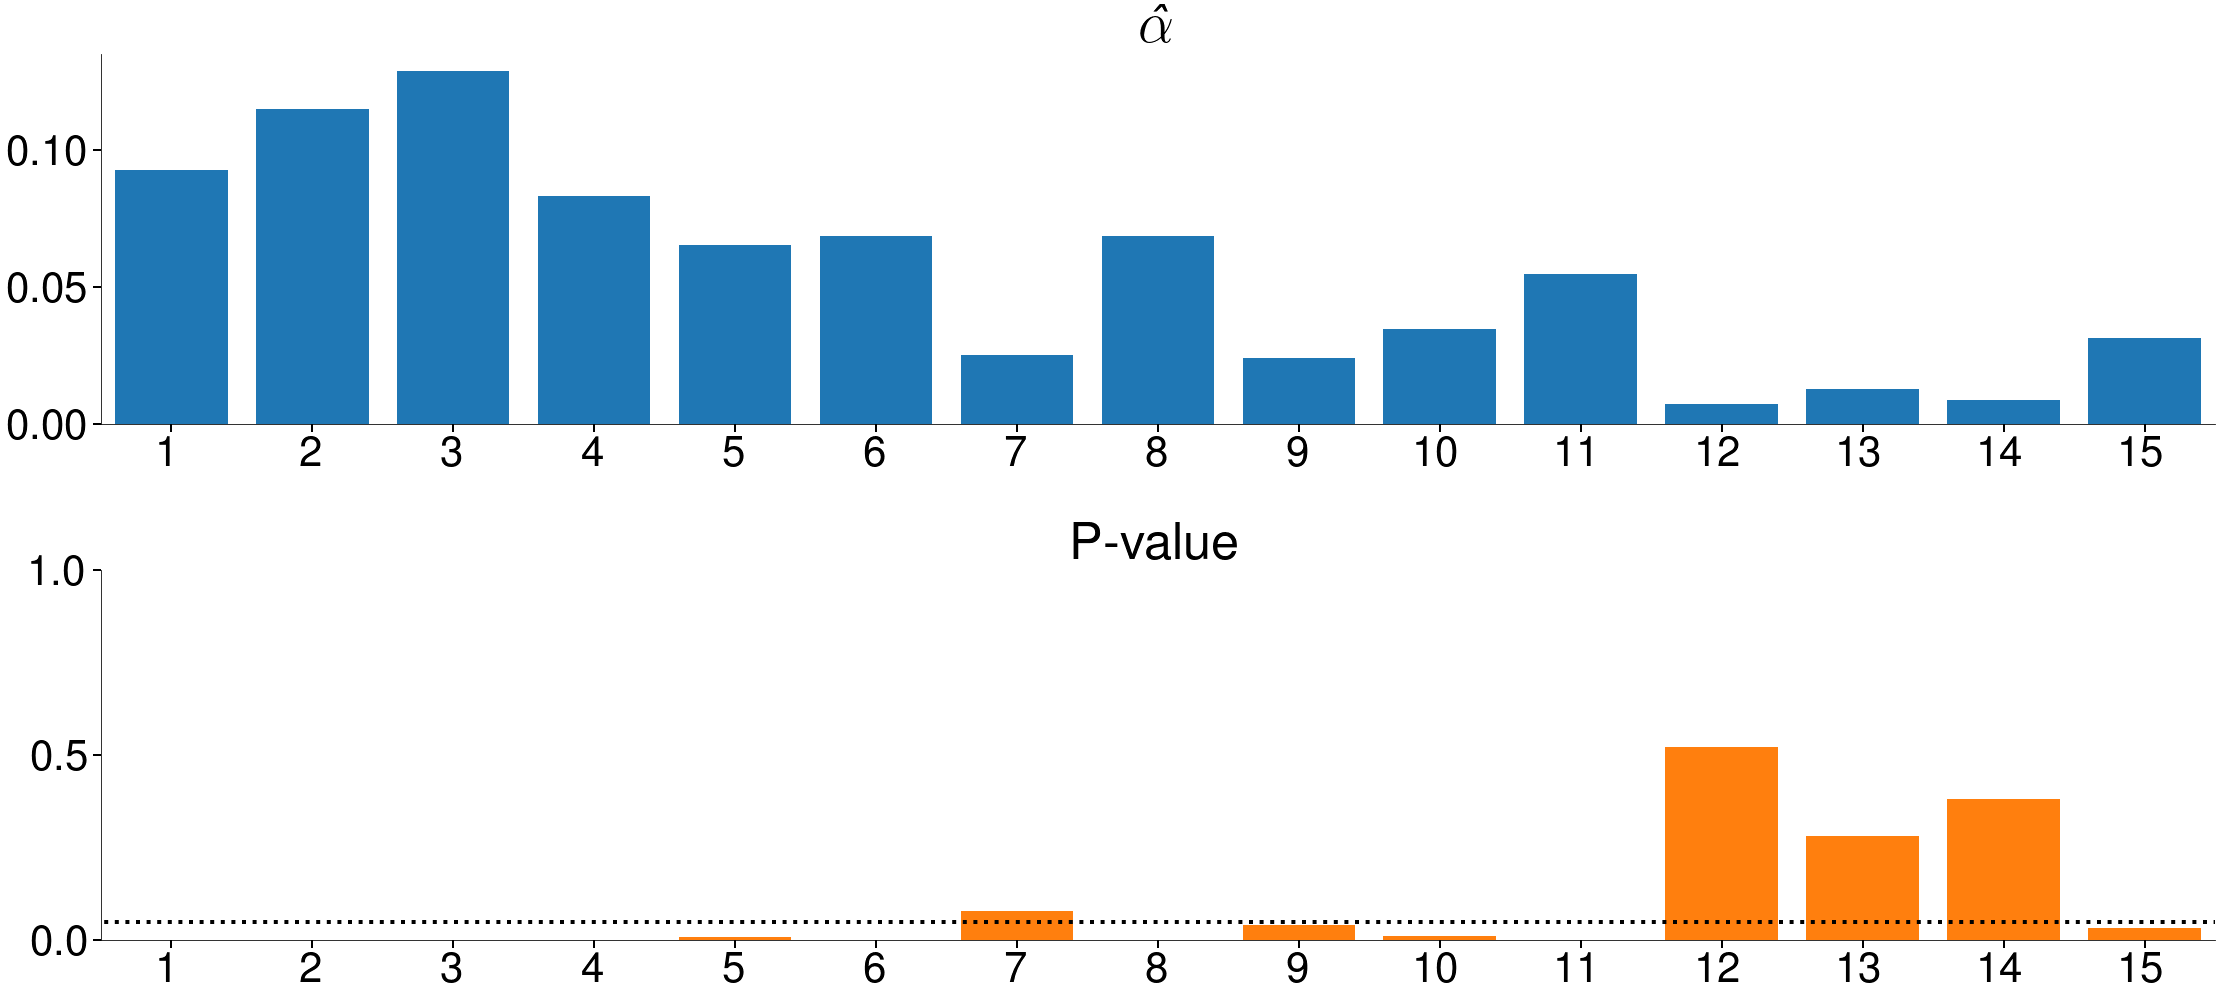

In [28]:
plot_arch(15)

# HARCH Model

* Compact parameterization of long-lag ARCH
* Define 

$$ \overline{r^2_{t-1:j}} = j^{-1} \sum_{i=1}^j r_{t-i}^2 $$

* HARCH is parameterized in terms of $\overline{r^2_{t-1:j}}$
* Standard model: HARCH(1,5,22)

$$ \sigma^2_t = \omega + \alpha_1 r_{t-1}^2 + \alpha_5 \overline{r^2_{t-1:5}}  + \alpha_{22} \overline{r^2_{t-1:22}}  $$

* Compute effective coefficient by expanding

# HARCH(1, 5, 22) Model

In [29]:
summary(arch_model(ftse100, vol="harch",p=[1,5,22]).fit(disp="off"))

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - HARCH Model Results                      
==============================================================================
Mean Model:             Constant Mean   Log-Likelihood:               -12679.1
Vol Model:                      HARCH   AIC:                           25368.1
Distribution:                  Normal   BIC:                           25403.9
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0459  8.614e-03      5.329  9.880e-08 [2.902e-02,6.278e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.1870  1.860e-02     10.052  8.957e-24      [  0.151,  0.223]
alpha[1]       0.0000  2.450e-02      0.000      1.000 [-4.802e-02,4.802e-02]
alpha[5]       0.3609  6.262e-02      5.764  8.232e-09      [  0.238,  0.484]
alpha[22]      0.4859  4.299e-02     11.302  1.282e-29      [  0.402,  0.570]
=============================================================================
"""

# Extended HARCH Model

In [30]:
summary(arch_model(ftse100, vol="harch",p=[1,5,22, 66]).fit(disp="off"))

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - HARCH Model Results                      
==============================================================================
Mean Model:             Constant Mean   Log-Likelihood:               -12654.9
Vol Model:                      HARCH   AIC:                           25321.8
Distribution:                  Normal   BIC:                           25364.8
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0473  8.620e-03      5.487  4.081e-08 [3.041e-02,6.420e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.1482  1.930e-02      7.678  1.615e-14      [  0.110,  0.186]
alpha[1]   1.0355e-03  2.369e-02  4.372e-02      0.965 [-4.539e-02,4.746e-02]
alpha[5]       0.3830  6.023e-02      6.358  2.038e-10      [  0.265,  0.501]
alpha[22]      0.2765  6.112e-02      4.524  6.058e-06      [  0.157,  0.396]
alpha[66]      0.2122  4.437e-02      4.781  1.741e-06      [  0.125,  0.299]
=============================================================================
"""

In [31]:
def harch_weights():
    res = arch_model(ftse100, vol="harch",p=[1,5,22, 66]).fit(disp="off")
    a = np.zeros(66)
    for i in (1,5,22,66):
        a[:i] += res.params[f"alpha[{i}]"] / i
    fig,ax = plt.subplots(1,1)
    ax.plot(np.arange(1,67), a)
    ax.set_xlim(1,66)
    sns.despine()
    fig.tight_layout(pad=1.0)


# HARCH(1,5,22,66) expanded coefficients

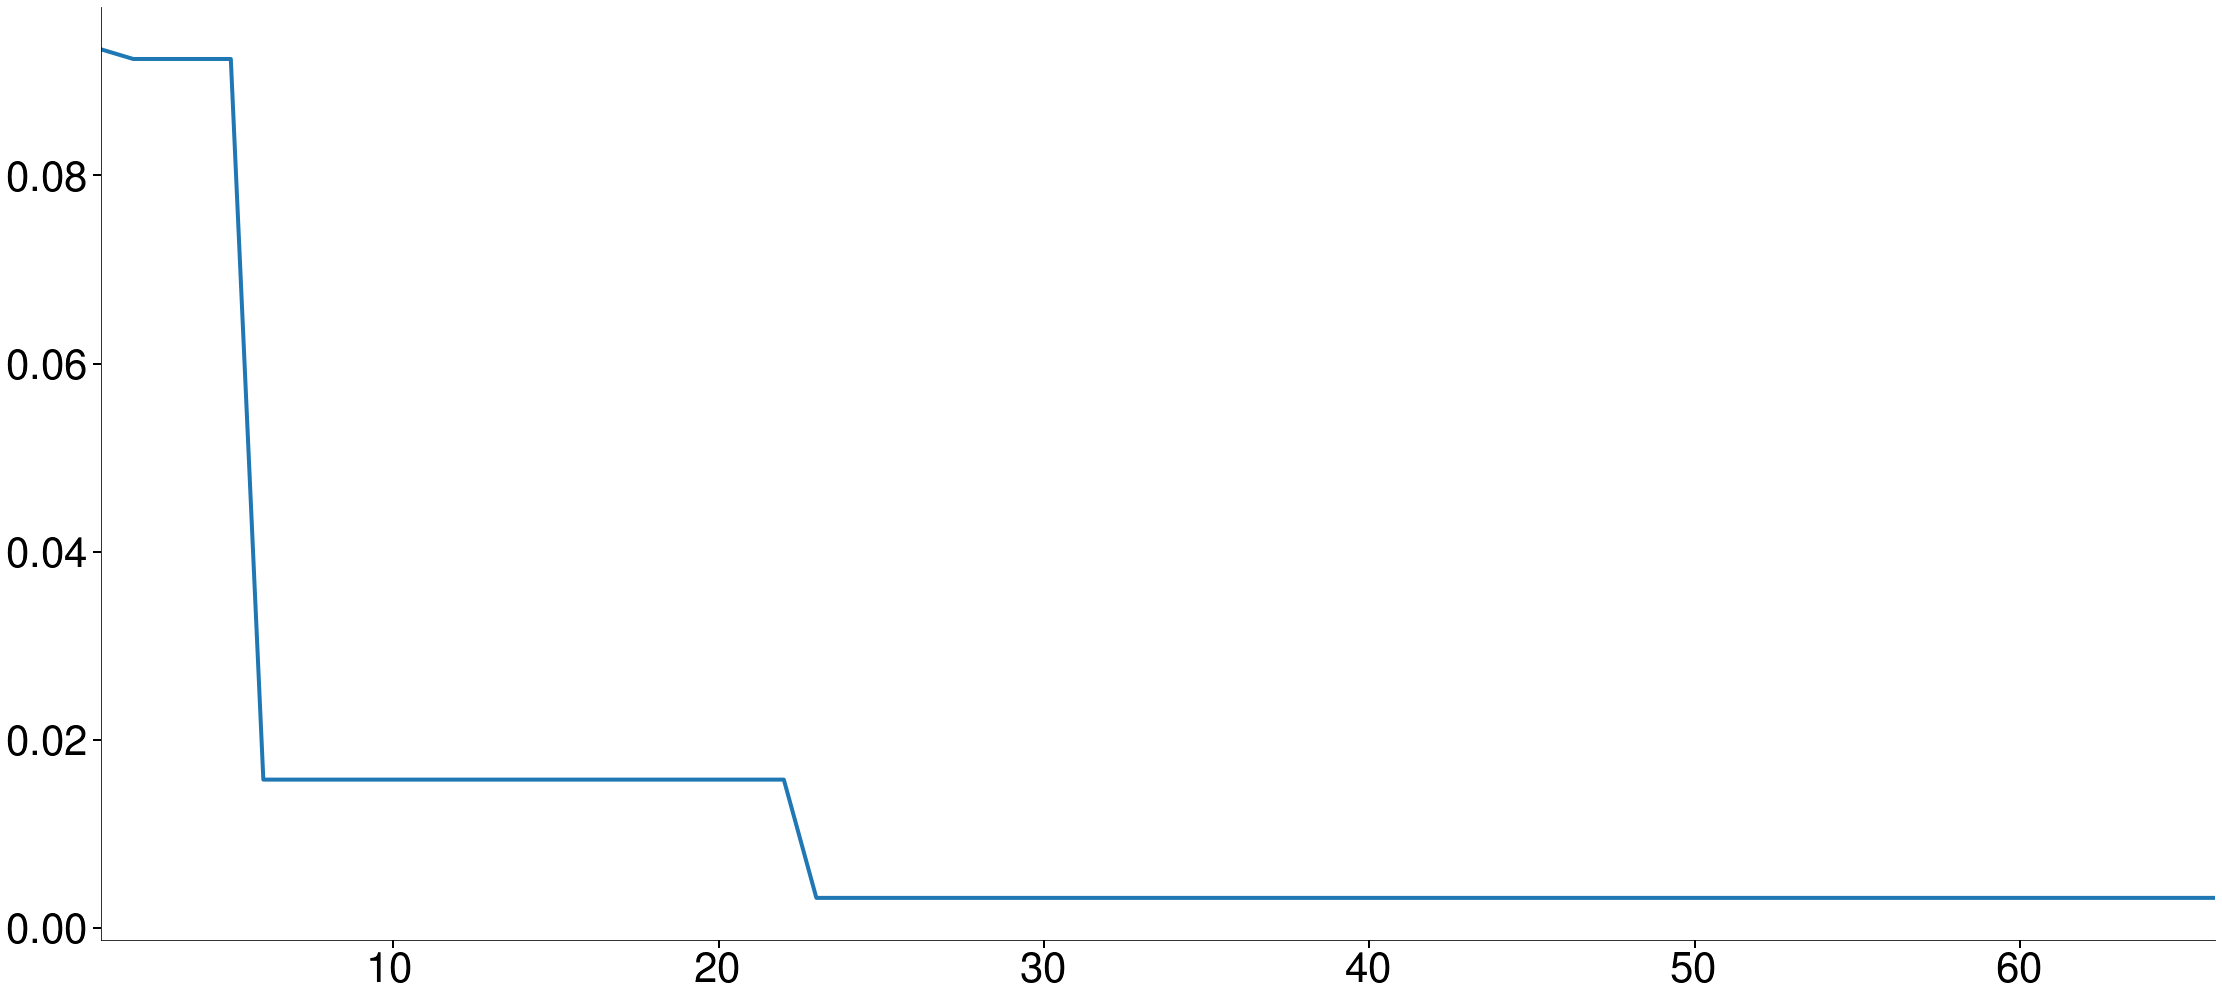

In [32]:
harch_weights()

# The GARCH Model

* Simple but effective generalization of ARCH

$$ \sigma^2_t = \omega + \alpha_1 \epsilon_{t-1}^2 + \beta_1 \sigma^2_{t-1} $$

* ARCH($\infty$) in disguise

$$ \sigma_t^2 = \frac{\omega}{1-\beta} + \alpha_1 \sum_{i=1}^\infty \beta_1^{i-1} \epsilon_{t-i}^2 $$

* Similar to ARMA(1,1)
  * $\alpha+\beta$ is the AR coefficient
  * $-\beta$ is the MA coefficient


# GARCH Model Results

In [33]:
garch = arch_model(ftse100, vol="garch").fit(disp="off")
summary(garch)

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Mean Model:             Constant Mean   Log-Likelihood:               -12665.8
Vol Model:                      GARCH   AIC:                           25339.7
Distribution:                  Normal   BIC:                           25368.3
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0483  8.961e-03      5.395  6.854e-08 [3.078e-02,6.591e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0203  4.160e-03      4.868  1.126e-06 [1.210e-02,2.840e-02]
alpha[1]       0.1008  1.198e-02      8.418  3.821e-17   [7.736e-02,  0.124]
beta[1]        0.8824  1.324e-02     66.656      0.000     [  0.856,  0.908]
============================================================================
"""

# The Conditional Mean

* All models have used a constant mean $\mu_t = \mu$
* Plausible for liquid financial assets
* For high-frequency data, mean makes little difference
* Can instead use $\mu_t = 0$

# Zero mean

In [34]:
zero = arch_model(ftse100, vol="garch", mean="zero").fit(disp="off")
summary(zero)

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Mean Model:                 Zero Mean   Log-Likelihood:               -12682.3
Vol Model:                      GARCH   AIC:                           25370.7
Distribution:                  Normal   BIC:                           25392.1
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0196  3.966e-03      4.929  8.244e-07 [1.178e-02,2.733e-02]
alpha[1]       0.0977  1.111e-02      8.793  1.456e-18   [7.589e-02,  0.119]
beta[1]        0.8861  1.250e-02     70.883      0.000     [  0.862,  0.911]
============================================================================
"""

# Zero vs. Non-zero Mean

In [35]:
def compare_mean_models():
    df = pd.concat([garch.conditional_volatility, zero.conditional_volatility], axis=1)
    df.columns=["Constant","Zero Mean"]
    plot(df, y=13)

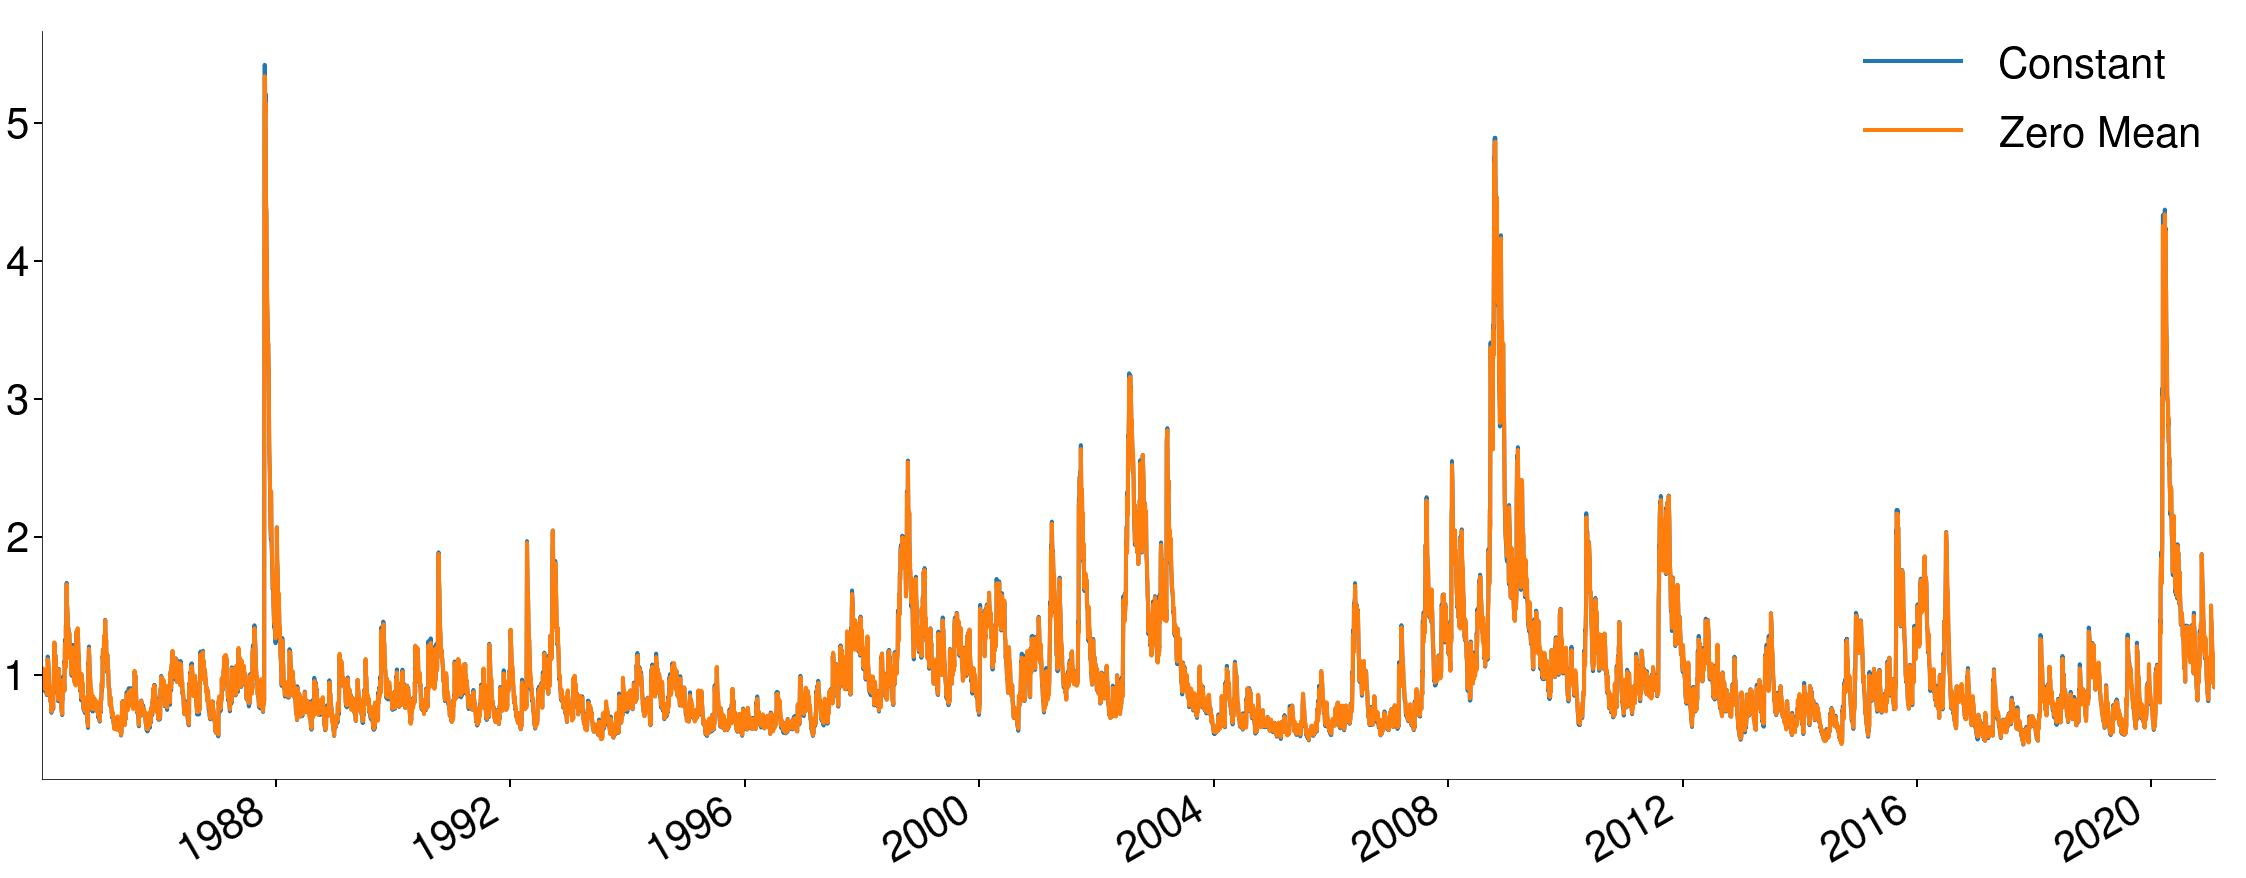

In [36]:
compare_mean_models()

# Exponentially Weighted Moving Average (EWMA) Variance

* Restricted version of GARCH

$$
\begin{align*}
\omega & = 0 \\
\alpha+\beta& =1 \Rightarrow \alpha = 1-\beta
\end{align*}
$$


* Usually parameterize with $\lambda$

$$ \sigma_t^2 = (1-\lambda)\epsilon_{t-1}^2 + \lambda \sigma^2_{t-1} $$

* Simpler if $\mu_t=0$

$$ \sigma_t^2 = (1-\lambda)r_{t-1}^2 + \lambda \sigma^2_{t-1} $$

* Common to fix $\lambda$
  * Daily: 0.94
  * Weekly: 0.97
  * Monthly: 0.99

# EWMA Results

In [37]:
ewma_var = arch.univariate.volatility.EWMAVariance(0.94)
summary(arch.univariate.ConstantMean(ftse100, volatility=ewma_var).fit(disp="off"))

<class 'statsmodels.iolib.summary.Summary'>
"""
                Constant Mean - EWMA/RiskMetrics Model Results                
==============================================================================
Mean Model:             Constant Mean   Log-Likelihood:               -12757.7
Vol Model:           EWMA/RiskMetrics   AIC:                           25517.4
Distribution:                  Normal   BIC:                           25524.6
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0426  1.015e-02      4.196  2.721e-05 [2.269e-02,6.247e-02]
============================================================================
"""

# Asymmetries in Conditional Variance

# GJR-GARCH

* Adds asymmetry to GARCH model

$$ \sigma^2_t = \omega + \alpha_1 \epsilon_{t-1}^2 + \gamma_1 I_{[\epsilon_t-1<0]} \epsilon_{t-1}^2 + \beta_1 \sigma^2_{t-1} $$


# GJR-GARCH(1,1,) Model

In [38]:
summary(arch_model(ftse100, vol="garch", o=1).fit(disp="off"))

<class 'statsmodels.iolib.summary.Summary'>
"""
                   Constant Mean - GJR-GARCH Model Results                    
==============================================================================
Mean Model:             Constant Mean   Log-Likelihood:               -12574.3
Vol Model:                  GJR-GARCH   AIC:                           25158.6
Distribution:                  Normal   BIC:                           25194.4
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0245  8.442e-03      2.907  3.646e-03 [7.997e-03,4.109e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0207  3.938e-03      5.262  1.424e-07 [1.300e-02,2.844e-02]
alpha[1]       0.0263  6.720e-03      3.910  9.234e-05 [1.310e-02,3.945e-02]
gamma[1]       0.1126  1.802e-02      6.246  4.216e-10   [7.724e-02,  0.148]
beta[1]        0.8973  1.184e-02     75.758      0.000     [  0.874,  0.921]
============================================================================
"""

# The TARCH Model

* Changes model from variance to volatility

$$ \sigma_t = \omega + \alpha_1 |\epsilon_{t-1}| + \gamma_1 I_{[\epsilon_t-1<0]} |\epsilon_{t-1}| + \beta_1 \sigma_{t-1} $$


# TARCH(1,1,1)


In [39]:
summary(arch_model(ftse100, vol="garch", o=1, power=1).fit(disp="off"))

<class 'statsmodels.iolib.summary.Summary'>
"""
                  Constant Mean - TARCH/ZARCH Model Results                   
==============================================================================
Mean Model:             Constant Mean   Log-Likelihood:               -12566.9
Vol Model:                TARCH/ZARCH   AIC:                           25143.9
Distribution:                  Normal   BIC:                           25179.6
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0204  8.517e-03      2.401  1.637e-02 [3.753e-03,3.714e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0230  4.398e-03      5.223  1.763e-07 [1.435e-02,3.159e-02]
alpha[1]       0.0409  7.306e-03      5.602  2.122e-08 [2.661e-02,5.525e-02]
gamma[1]       0.0980  1.332e-02      7.359  1.851e-13   [7.192e-02,  0.124]
beta[1]        0.9070  1.098e-02     82.581      0.000     [  0.885,  0.929]
============================================================================
"""

# Exponential GARCH

$$ \ln \sigma^2_t = \omega + \alpha_1 \left| \frac{\epsilon_{t-1}}{\sigma_{t-1}}  - \sqrt{\frac{2}{\pi}} \right| + \gamma_1 \frac{\epsilon_{t-1}}{\sigma_{t-1}} + \beta_1 \ln \sigma^2_{t-1} $$


# EGARCH(1,1,1)

In [40]:
summary(arch_model(ftse100, vol="egarch", o=1).fit(disp="off"))

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - EGARCH Model Results                     
==============================================================================
Mean Model:             Constant Mean   Log-Likelihood:               -12565.9
Vol Model:                     EGARCH   AIC:                           25141.8
Distribution:                  Normal   BIC:                           25177.5
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0214  5.550e-03      3.863  1.121e-04 [1.056e-02,3.232e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      7.3006e-04  1.948e-03      0.375      0.708 [-3.089e-03,4.549e-03]
alpha[1]       0.1605  1.612e-02      9.953  2.447e-23      [  0.129,  0.192]
gamma[1]      -0.0817  9.921e-03     -8.238  1.748e-16   [ -0.101,-6.229e-02]
beta[1]        0.9794  3.723e-03    263.034      0.000      [  0.972,  0.987]
=============================================================================
"""

# Asymmetric Power ARCH

* Parameterizes power in model

$$ \sigma^\delta_t = \omega + \alpha_1 \left(|\epsilon_{t-1}| + \gamma_1 \epsilon_{t-1}\right)^\delta + \beta_1 \sigma^\delta_{t-1} $$


# APARCH(1,1,1) Model

In [41]:
from arch.univariate import ConstantMean, APARCH
summary(ConstantMean(ftse100, volatility=APARCH()).fit(disp="off"))

C:\Anaconda\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - APARCH Model Results                     
==============================================================================
Mean Model:             Constant Mean   Log-Likelihood:               -12559.6
Vol Model:                     APARCH   AIC:                           25131.3
Distribution:                  Normal   BIC:                           25174.2
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0216  8.536e-03      2.527  1.151e-02 [4.838e-03,3.830e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0220  4.132e-03      5.325  1.009e-07 [1.391e-02,3.010e-02]
alpha[1]       0.0854  9.696e-03      8.805  1.314e-18   [6.637e-02,  0.104]
gamma[1]       0.4937  6.798e-02      7.262  3.816e-13     [  0.360,  0.627]
beta[1]        0.9048  1.096e-02     82.593      0.000     [  0.883,  0.926]
delta          1.3226      0.158      8.384  5.123e-17     [  1.013,  1.632]
============================================================================
"""

# ACF and PACF of $\epsilon^{2}_{t}$

* Time-varying volatility appears through persistence in $\epsilon^{2}_{t}$
  * Square is essential
* Standard tool is to plot ACF and PACF of $\hat{\epsilon}^{2}_{t}$
  * Estimate mean without time-varying volatility
* ACF indicates ARCH-like terms needed
* PACF indicates GARCH-like terms needed

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import acf, pacf

DEFAULT_FIGSIZE = mfe.DEFAULT_FIGSIZE

def acf_pacf_plot(y, lags, correct=False, title=None, size=DEFAULT_FIGSIZE[1]):
    figsize(y=size)
    a = acf(y, nlags=lags, fft=True)
    p = pacf(y, nlags=lags)
    fig, ax = plt.subplots(1, 2)
    x = np.arange(1, lags + 1)
    t = y.shape[0]
    ax[0].bar(x, a[1:])
    ax[1].bar(x, p[1:], color=mfe.colors[1])
    a_ci = p_ci = 1.96 * np.ones_like(a[1:]) / np.sqrt(t)
    if correct:
        a_ci = 1.96 * (1 + np.cumsum(a[:-1] ** 2)) / np.sqrt(t)
    x[0] = 0.5
    x[-1] = lags + 0.5
    ax[0].plot(x, a_ci, "k--", x, -a_ci, "k--")
    ax[1].plot(x, p_ci, "k--", x, -p_ci, "k--")
    ax[0].set_xlim(0.5, lags + 0.5)
    ax[1].set_xlim(0.5, lags + 0.5)
    ax[0].set_title("Autocorrelation")
    ax[1].set_title("Partial Autocorrelation")
    if title:
        plt.suptitle(title)
    sns.despine()
    fig.tight_layout(pad=1.0)
    figsize()

# S&P 500

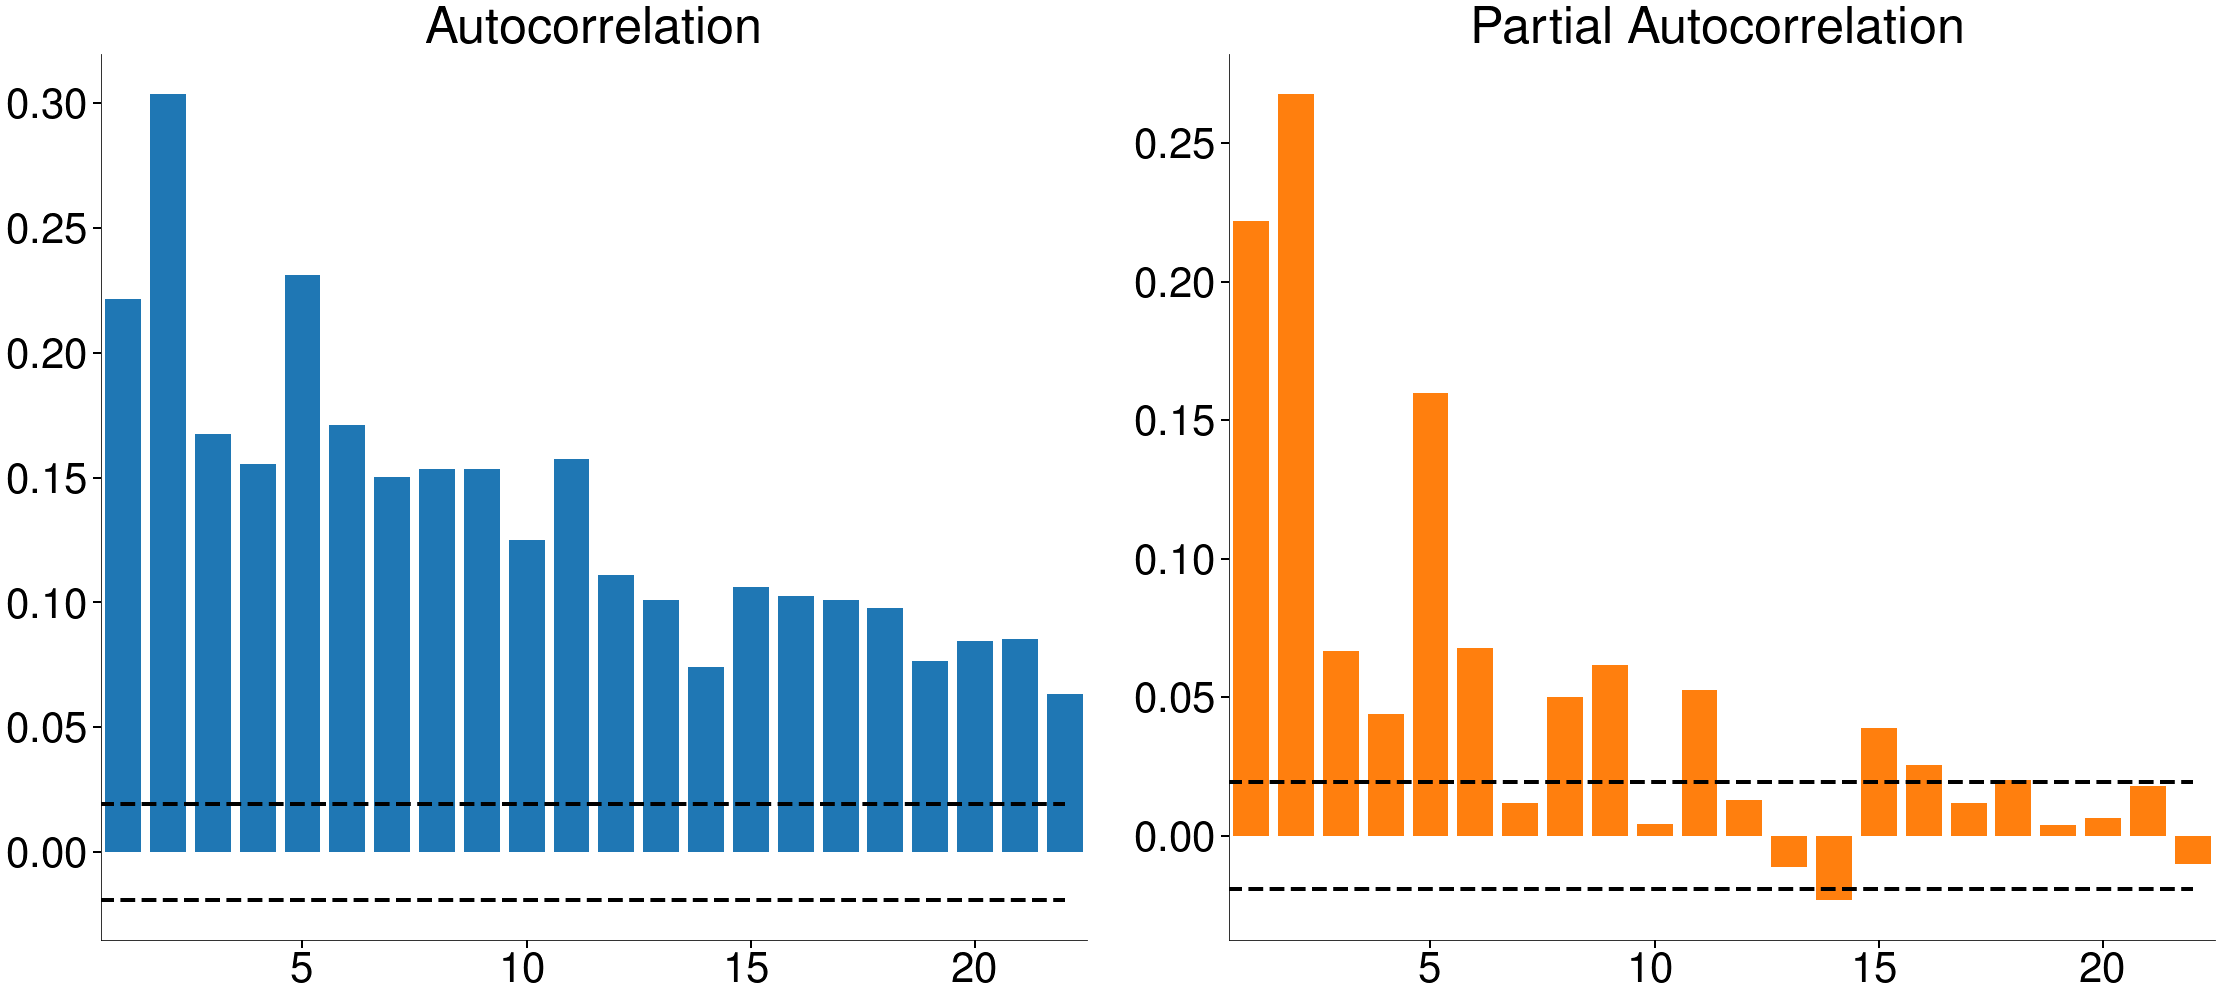

In [43]:
acf_pacf_plot(sp500**2, 22)

# West Texas Internediate Crude

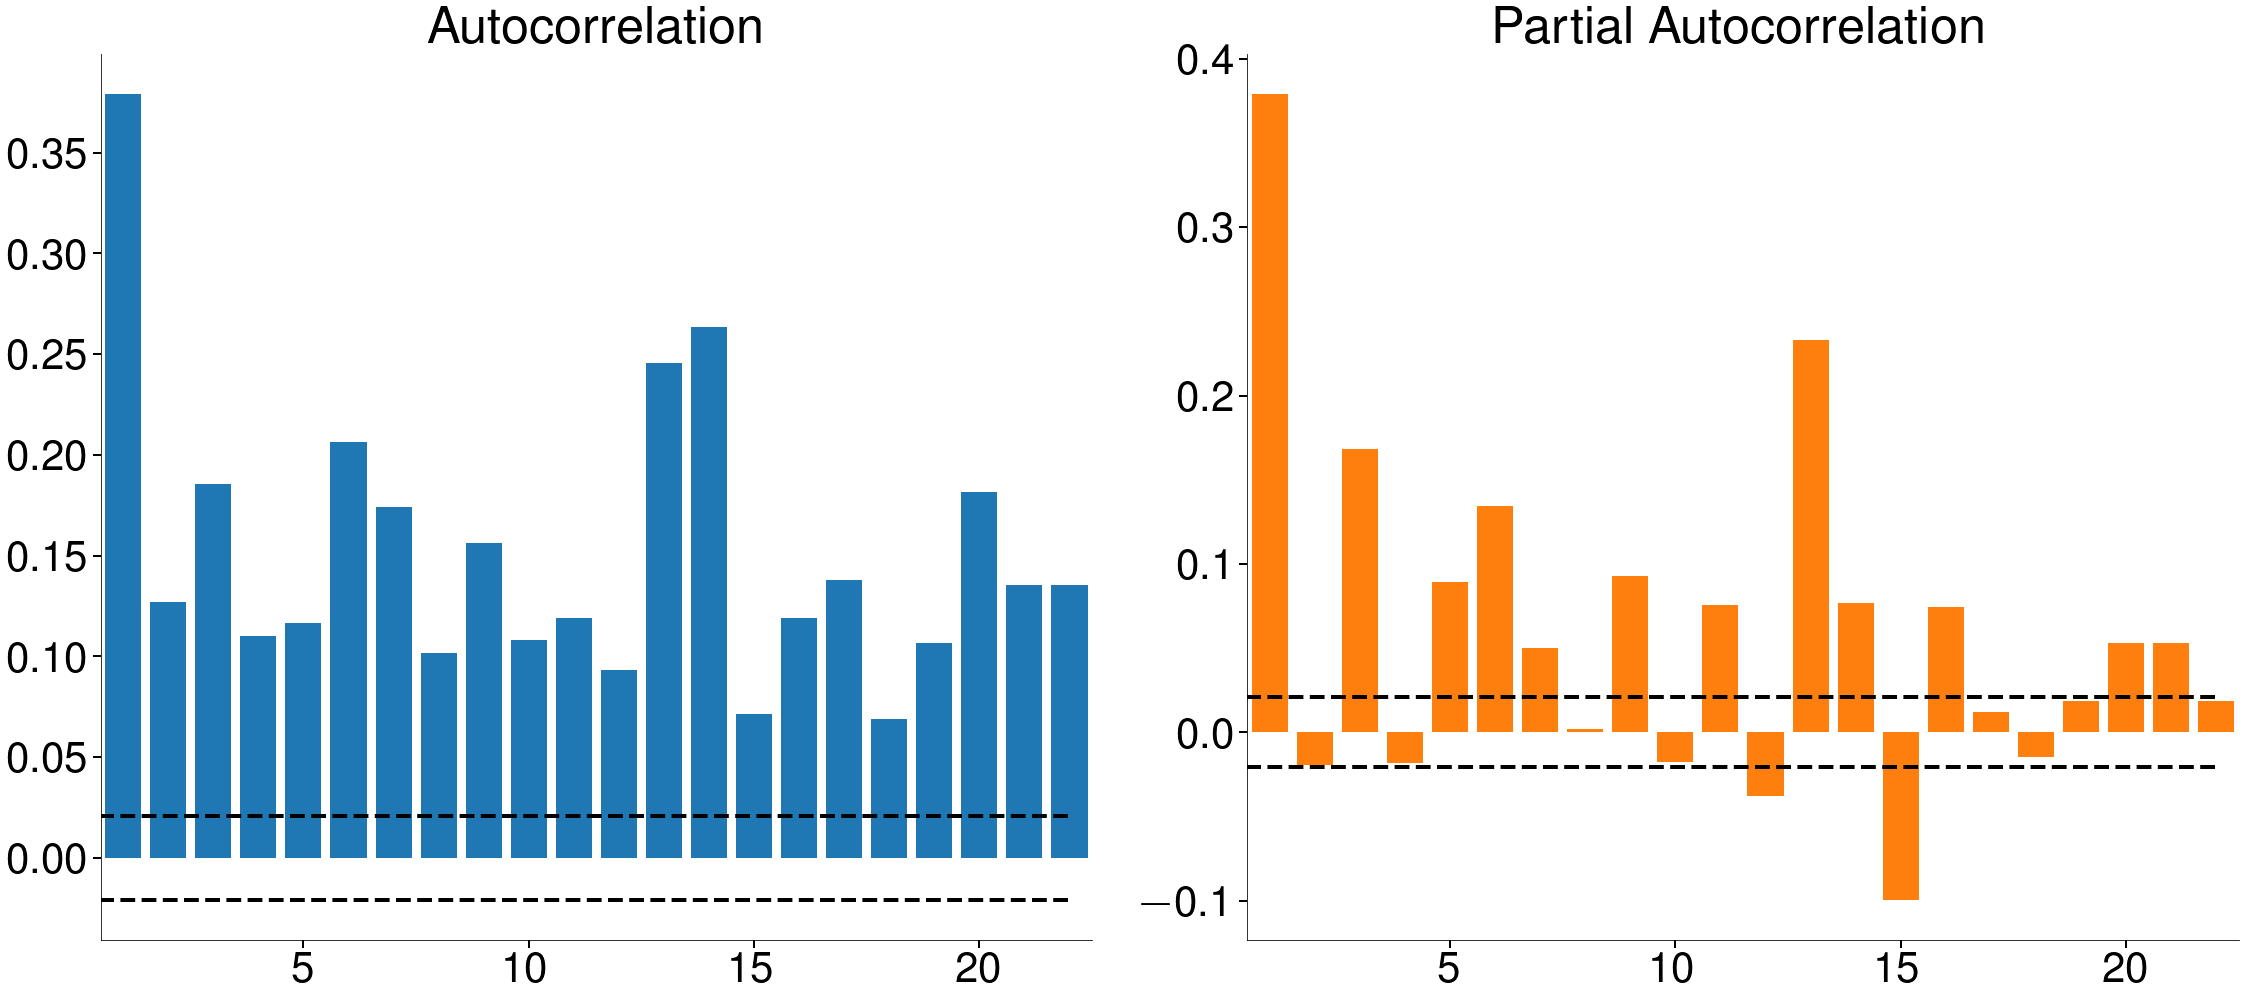

In [44]:
acf_pacf_plot(wti**2, 22)

# Bitcoin

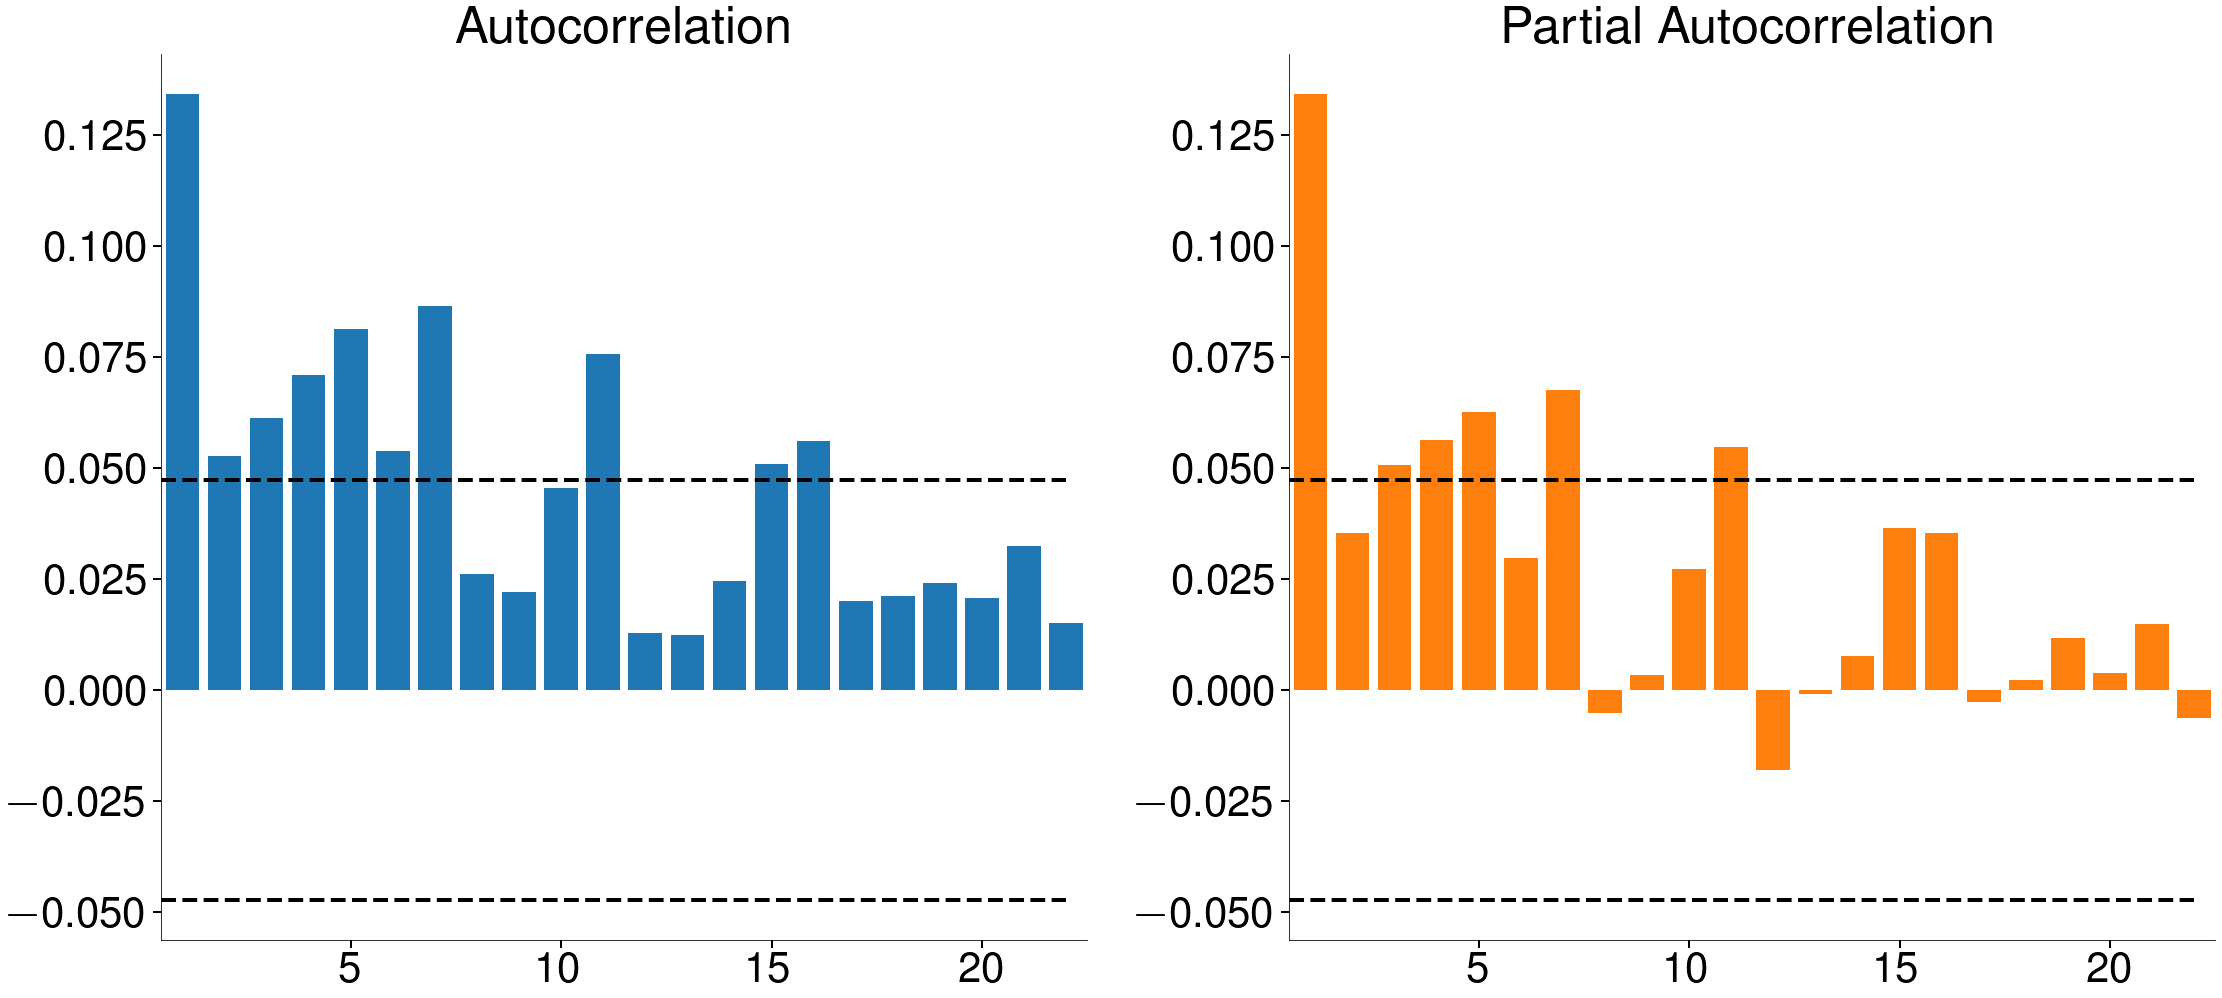

In [45]:
acf_pacf_plot(btc**2, 22)

# Etherium

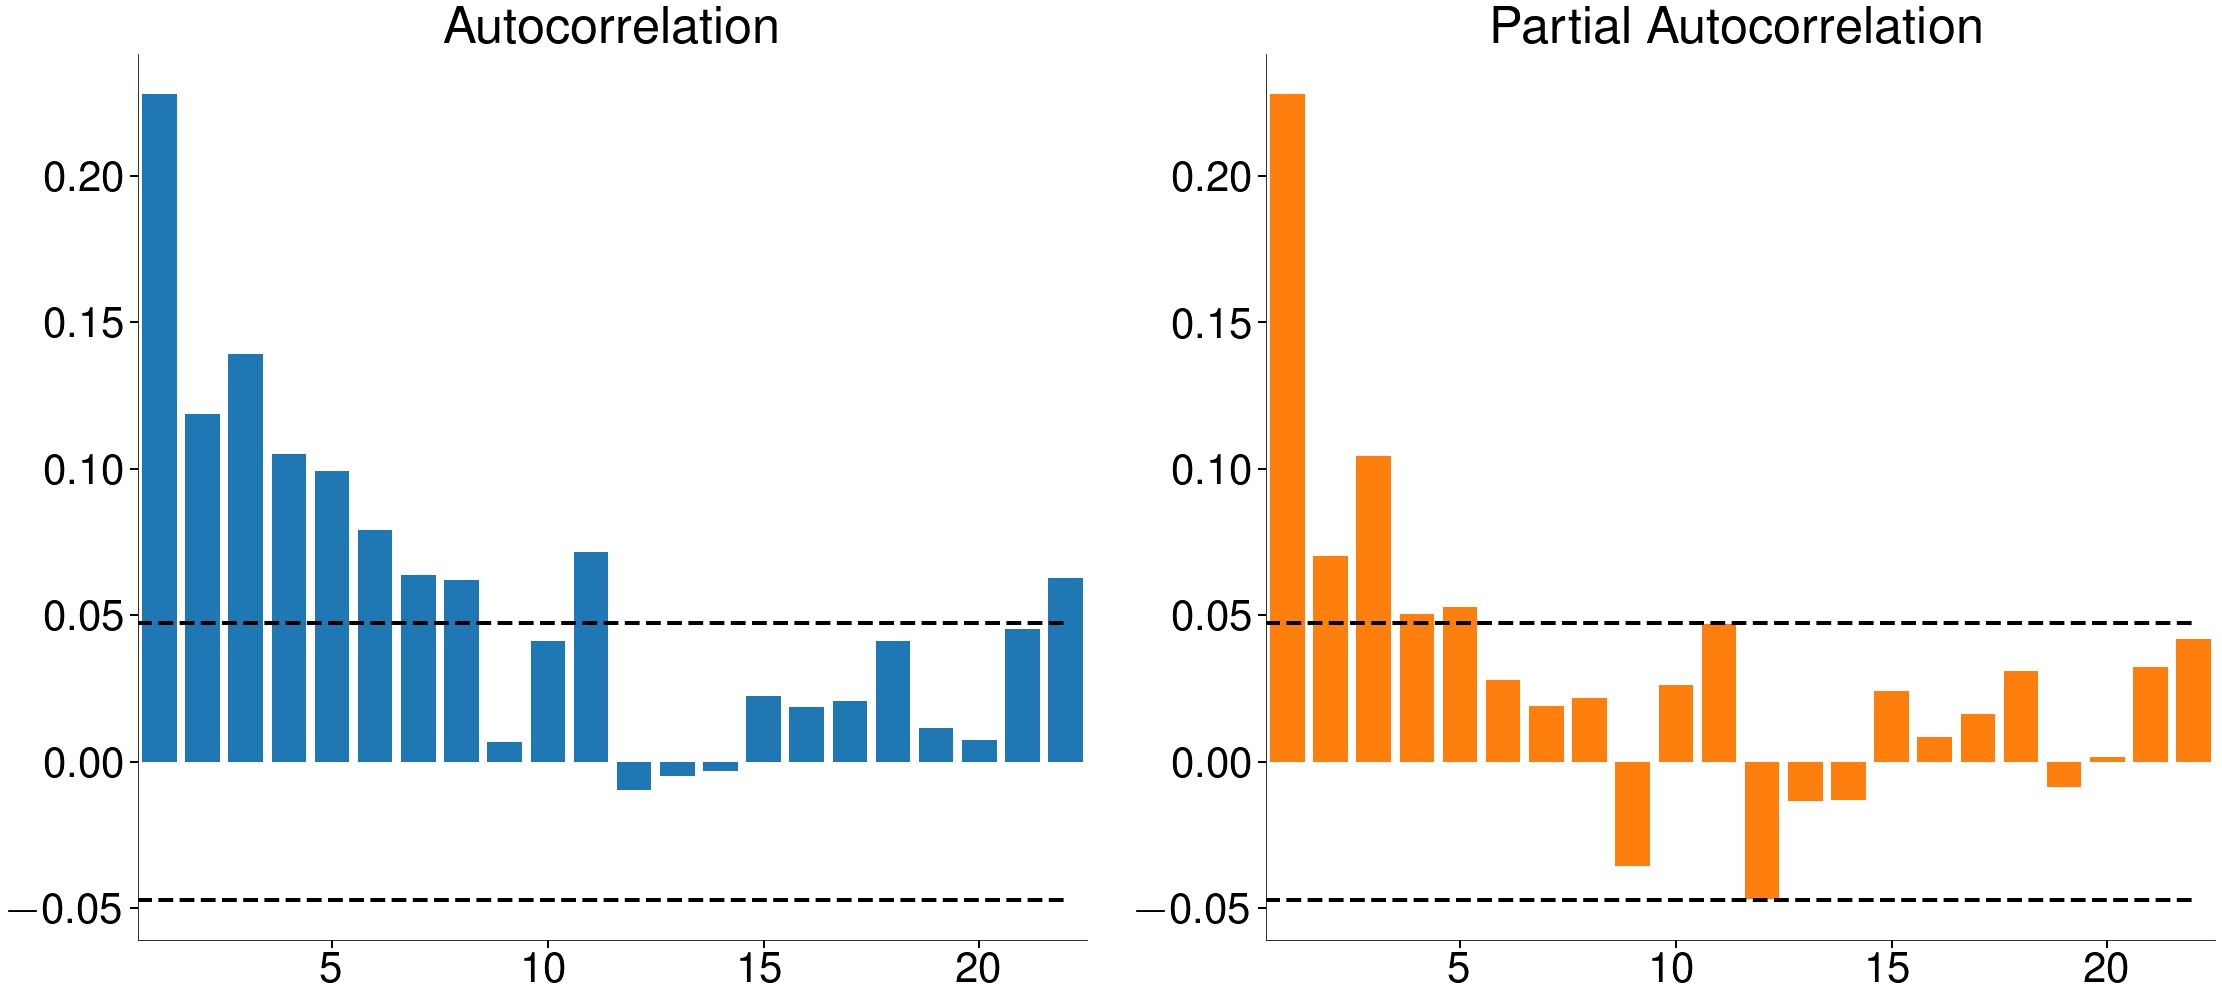

In [46]:
acf_pacf_plot(eth**2, 22)

# Model Building

* Usually begin with GARCH
* Check lag specification using StG
* Check for asymmetries using GJR-GARCH
* Check for functional form using TARCH and EGARCH

In [47]:
garch11 = arch_model(eth).fit(disp="off")
summary(garch11)

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Mean Model:             Constant Mean   Log-Likelihood:               -5315.65
Vol Model:                      GARCH   AIC:                           10639.3
Distribution:                  Normal   BIC:                           10661.1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.2984      0.113      2.643  8.227e-03 [7.709e-02,  0.520]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          3.3878      1.542      2.197  2.804e-02   [  0.365,  6.410]
alpha[1]       0.1739  4.966e-02      3.503  4.606e-04 [7.661e-02,  0.271]
beta[1]        0.7337  8.177e-02      8.973  2.895e-19   [  0.573,  0.894]
==========================================================================
"""

In [48]:
garch21 = arch_model(eth, p=2).fit(disp="off")
summary(garch21)

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Mean Model:             Constant Mean   Log-Likelihood:               -5315.65
Vol Model:                      GARCH   AIC:                           10641.3
Distribution:                  Normal   BIC:                           10668.6
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.2984      0.114      2.623  8.708e-03 [7.546e-02,  0.521]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          3.3877      1.974      1.716  8.614e-02   [ -0.481,  7.257]
alpha[1]       0.1740  5.461e-02      3.185  1.445e-03 [6.692e-02,  0.281]
alpha[2]       0.0000  7.523e-02      0.000      1.000   [ -0.147,  0.147]
beta[1]        0.7337      0.114      6.441  1.186e-10   [  0.510,  0.957]
==========================================================================
"""

In [49]:
garch12 = arch_model(eth, q=2).fit(disp="off")
summary(garch12)

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Mean Model:             Constant Mean   Log-Likelihood:               -5312.01
Vol Model:                      GARCH   AIC:                           10634.0
Distribution:                  Normal   BIC:                           10661.3
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.2985      0.112      2.657  7.890e-03 [7.828e-02,  0.519]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          3.8956      1.679      2.320  2.036e-02 [  0.604,  7.187]
alpha[1]       0.2135  5.746e-02      3.715  2.031e-04 [  0.101,  0.326]
beta[1]        0.4137      0.109      3.812  1.380e-04 [  0.201,  0.626]
beta[2]        0.2677  8.408e-02      3.184  1.451e-03 [  0.103,  0.433]
========================================================================
"""

In [50]:
garch22 = arch_model(eth, p=2, q=2).fit(disp="off")
summary(garch22)

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Mean Model:             Constant Mean   Log-Likelihood:               -5312.01
Vol Model:                      GARCH   AIC:                           10636.0
Distribution:                  Normal   BIC:                           10668.7
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.2985      0.113      2.644  8.186e-03 [7.724e-02,  0.520]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          3.8949      3.776      1.032      0.302   [ -3.506, 11.296]
alpha[1]       0.2135  7.039e-02      3.033  2.422e-03 [7.552e-02,  0.351]
alpha[2]       0.0000      0.190      0.000      1.000   [ -0.373,  0.373]
beta[1]        0.4137      0.530      0.780      0.435   [ -0.625,  1.453]
beta[2]        0.2678      0.286      0.935      0.350   [ -0.294,  0.829]
==========================================================================
"""

In [51]:
gjrgarch112 = arch_model(eth, q=2, o=1).fit(disp="off")
summary(gjrgarch112)

<class 'statsmodels.iolib.summary.Summary'>
"""
                   Constant Mean - GJR-GARCH Model Results                    
==============================================================================
Mean Model:             Constant Mean   Log-Likelihood:               -5311.95
Vol Model:                  GJR-GARCH   AIC:                           10635.9
Distribution:                  Normal   BIC:                           10668.6
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.2892      0.115      2.520  1.174e-02 [6.427e-02,  0.514]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          3.9218      1.660      2.362  1.818e-02   [  0.667,  7.176]
alpha[1]       0.2087  6.364e-02      3.279  1.041e-03 [8.396e-02,  0.333]
gamma[1]       0.0142  7.067e-02      0.201      0.841   [ -0.124,  0.153]
beta[1]        0.4136      0.108      3.827  1.295e-04   [  0.202,  0.625]
beta[2]        0.2657  8.858e-02      3.000  2.703e-03 [9.210e-02,  0.439]
==========================================================================
"""

In [52]:
tarch112 = arch_model(eth, q=2, o=1, power=1.0).fit(disp="off")
summary(tarch112)

<class 'statsmodels.iolib.summary.Summary'>
"""
                  Constant Mean - TARCH/ZARCH Model Results                   
==============================================================================
Mean Model:             Constant Mean   Log-Likelihood:               -5311.64
Vol Model:                TARCH/ZARCH   AIC:                           10635.3
Distribution:                  Normal   BIC:                           10668.0
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.3063      0.128      2.401  1.634e-02 [5.629e-02,  0.556]
                               Volatility Model                               
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
omega           0.5484      0.247      2.216  2.671e-02    [6.330e-02,  1.033]
alpha[1]        0.1965  4.514e-02      4.353  1.344e-05      [  0.108,  0.285]
gamma[1]   -4.9817e-03  4.319e-02     -0.115      0.908 [-8.964e-02,7.967e-02]
beta[1]         0.4471  9.875e-02      4.528  5.958e-06      [  0.254,  0.641]
beta[2]         0.3178  9.509e-02      3.342  8.324e-04      [  0.131,  0.504]
==============================================================================
"""

In [53]:
egarch112 = arch_model(eth, vol="EGARCH", q=2).fit(disp="off")
summary(egarch112)

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - EGARCH Model Results                     
==============================================================================
Mean Model:             Constant Mean   Log-Likelihood:               -5308.34
Vol Model:                     EGARCH   AIC:                           10626.7
Distribution:                  Normal   BIC:                           10653.9
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.3003      0.121      2.482  1.305e-02 [6.319e-02,  0.537]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.3951      0.149      2.658  7.863e-03 [  0.104,  0.686]
alpha[1]       0.3671  7.099e-02      5.171  2.325e-07 [  0.228,  0.506]
beta[1]        0.5440  8.495e-02      6.404  1.514e-10 [  0.377,  0.710]
beta[2]        0.3488  8.511e-02      4.098  4.170e-05 [  0.182,  0.516]
========================================================================
"""

In [54]:
egarch102 = arch_model(eth, vol="EGARCH", o=0, q=2).fit(disp="off")
summary(egarch102)

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - EGARCH Model Results                     
==============================================================================
Mean Model:             Constant Mean   Log-Likelihood:               -5308.34
Vol Model:                     EGARCH   AIC:                           10626.7
Distribution:                  Normal   BIC:                           10653.9
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.3003      0.121      2.482  1.305e-02 [6.319e-02,  0.537]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.3951      0.149      2.658  7.863e-03 [  0.104,  0.686]
alpha[1]       0.3671  7.099e-02      5.171  2.325e-07 [  0.228,  0.506]
beta[1]        0.5440  8.495e-02      6.404  1.514e-10 [  0.377,  0.710]
beta[2]        0.3488  8.511e-02      4.098  4.170e-05 [  0.182,  0.516]
========================================================================
"""

# Specification Checking

* Conceptually similar to mean modeling
* Emphasis of different form of residual

$$ \hat{e}_t^2 = \frac{\hat{\epsilon}_t^2}{\hat{\sigma}_t^2}$$

* Check ACF/PACF for White Noise appearance

# ACF and PACF of $\hat{e}^2_t$

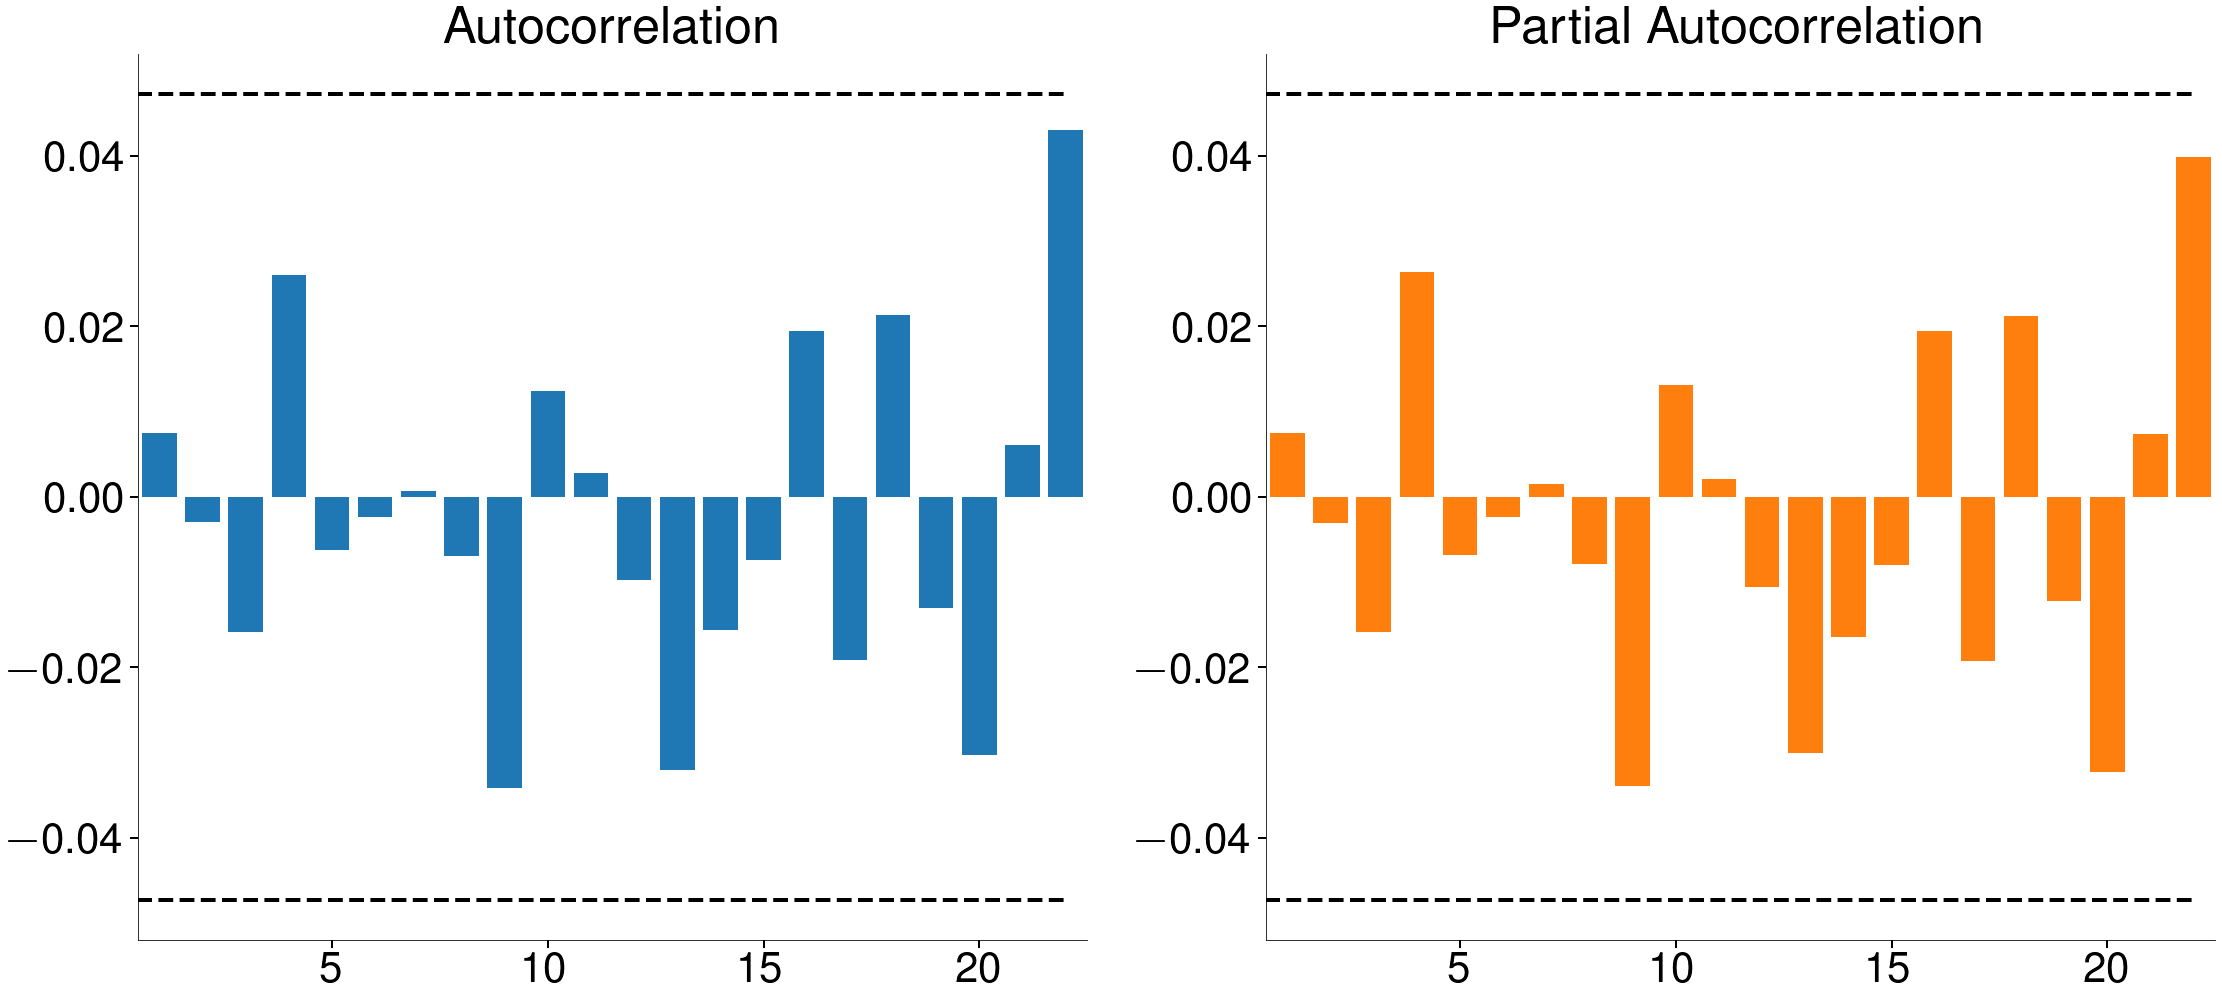

In [55]:
acf_pacf_plot(egarch102.std_resid ** 2, 22)

# ARCH-LM test

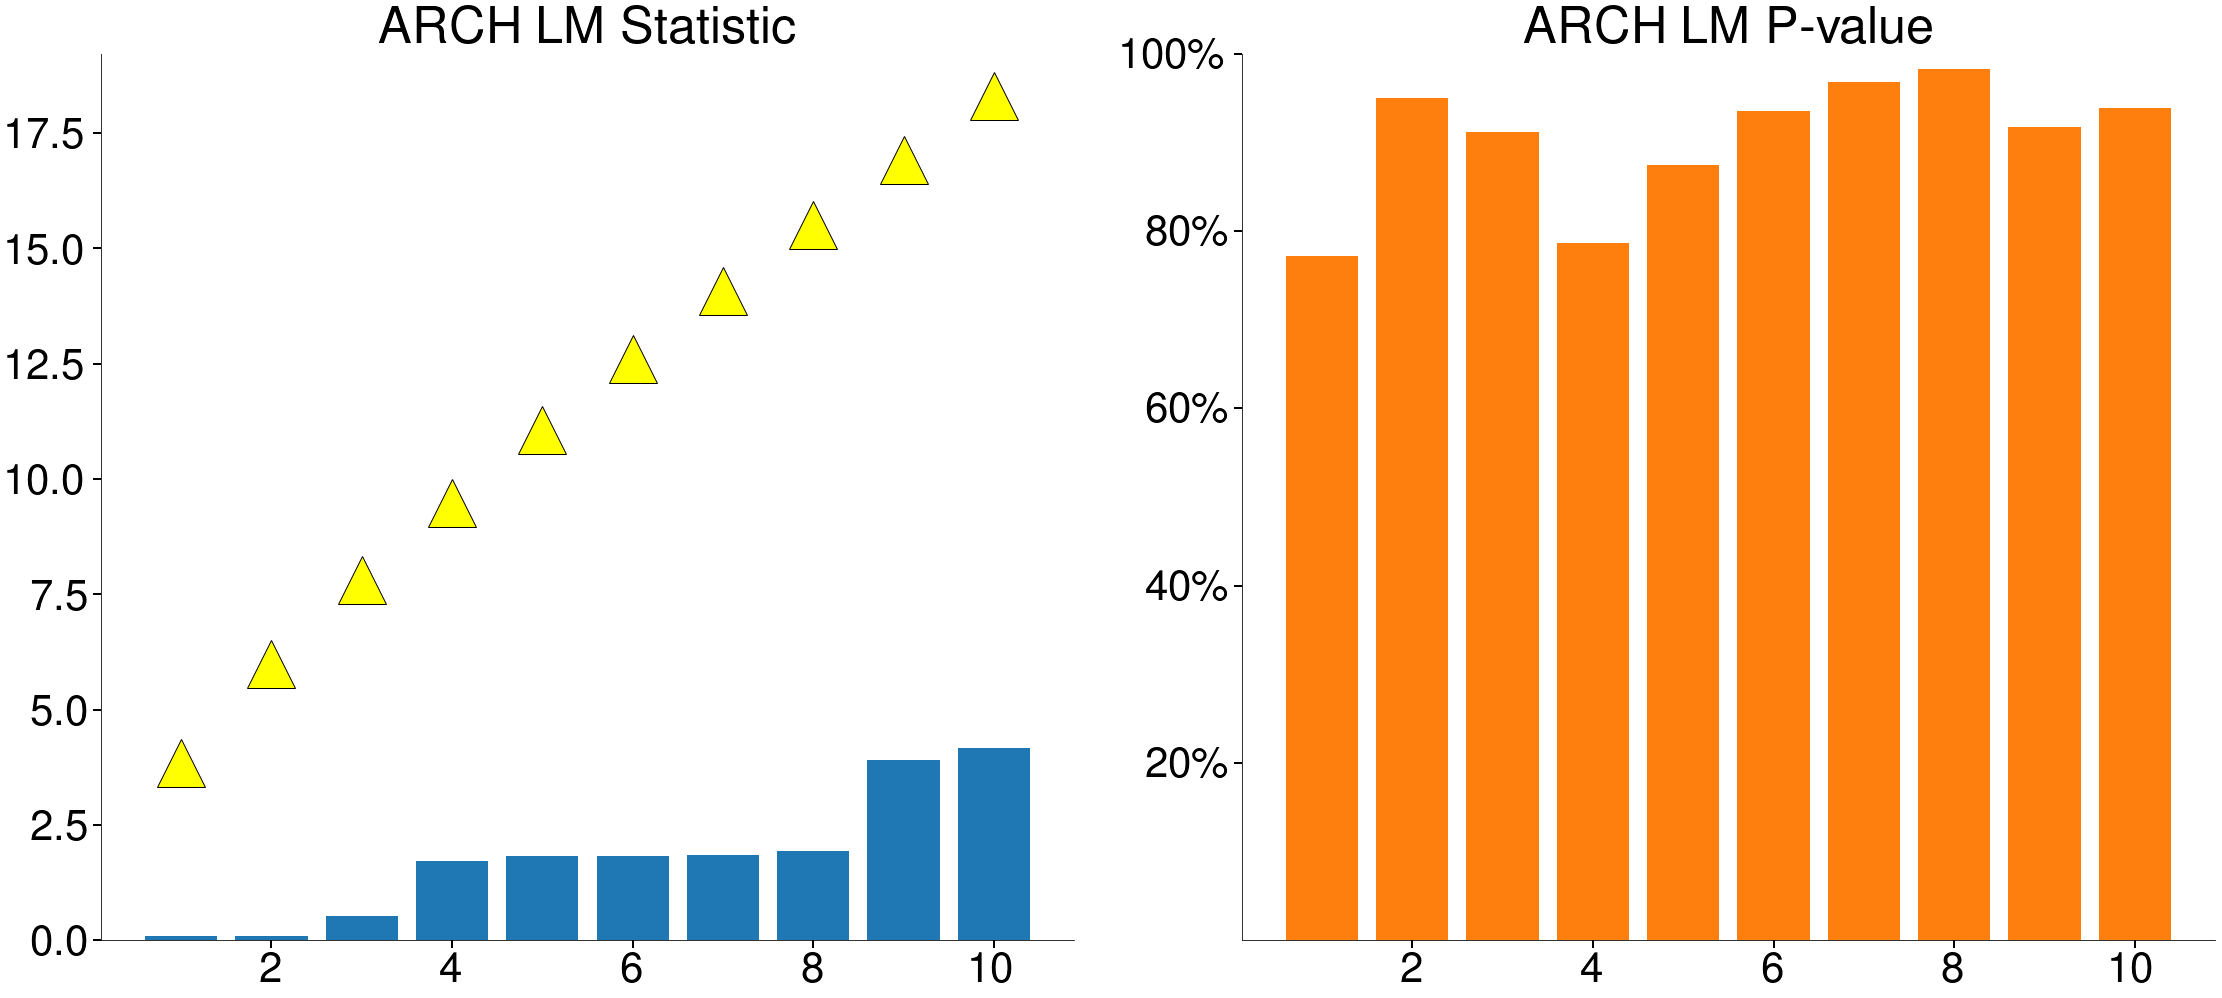

In [56]:
arch_lm(egarch102.std_resid, 10)

# Alternative Distributional Assumptions

* Have assumed $e_t \stackrel{iid}{\sim} N(0,1)$
* Can relax this assumption
* Common alternatives:
  * Student's $t$
  * Generalized Error Distribution
  * Hansen's Skew $t$

# Baseline Normal

In [57]:
normal = arch_model(sp500, o=1, vol="egarch").fit(disp="off")
summary(normal, mean=False)

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - EGARCH Model Results                     
==============================================================================
Mean Model:             Constant Mean   Log-Likelihood:               -13681.8
Vol Model:                     EGARCH   AIC:                           27373.6
Distribution:                  Normal   BIC:                           27409.8
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      2.8410e-03  2.112e-03      1.345      0.179 [-1.299e-03,6.981e-03]
alpha[1]       0.1587  1.692e-02      9.380  6.584e-21      [  0.126,  0.192]
gamma[1]      -0.1040  1.256e-02     -8.280  1.229e-16   [ -0.129,-7.935e-02]
beta[1]        0.9757  4.241e-03    230.054      0.000      [  0.967,  0.984]
=============================================================================
"""

# Standardized Students's $t$

* Student's $t$ normalized to always have variance 1
* $\nu$ controls tail thickness


In [58]:
studt = arch_model(sp500, o=1, vol="egarch", dist="t").fit(disp="off")
summary(studt, mean=False)

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - EGARCH Model Results                        
====================================================================================
Mean Model:                   Constant Mean   Log-Likelihood:               -13408.6
Vol Model:                           EGARCH   AIC:                           26829.2
Distribution:      Standardized Student's t   BIC:                           26872.7
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      1.8400e-03  1.820e-03      1.011      0.312 [-1.728e-03,5.407e-03]
alpha[1]       0.1489  1.025e-02     14.524  8.578e-48      [  0.129,  0.169]
gamma[1]      -0.1040  8.646e-03    -12.027  2.562e-33   [ -0.121,-8.704e-02]
beta[1]        0.9825  2.586e-03    379.953      0.000      [  0.977,  0.988]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             6.4774      0.436     14.865  5.545e-50 [  5.623,  7.331]
========================================================================
"""

# Generalized Error Distribution

* Nests the normal when $\nu=2$
* Heavy tailed for $\nu<2$

In [59]:
ged = arch_model(sp500, o=1, vol="egarch", dist="ged").fit(disp="off")
summary(ged, mean=False)

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Constant Mean - EGARCH Model Results                           
==========================================================================================
Mean Model:                         Constant Mean   Log-Likelihood:               -13426.3
Vol Model:                                 EGARCH   AIC:                           26864.6
Distribution:      Generalized Error Distribution   BIC:                           26908.0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      1.3248e-03  1.841e-03      0.720      0.472 [-2.284e-03,4.933e-03]
alpha[1]       0.1514  1.178e-02     12.848  8.804e-38      [  0.128,  0.174]
gamma[1]      -0.1025  9.533e-03    -10.752  5.810e-27   [ -0.121,-8.381e-02]
beta[1]        0.9805  2.975e-03    329.522      0.000      [  0.975,  0.986]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             1.3358  3.350e-02     39.879      0.000 [  1.270,  1.401]
========================================================================
"""

# Hansen's Skew $t$

* Extendeds the $t$ with a skewness parameter $\lambda$

In [60]:
skewt = arch_model(sp500, o=1, vol="egarch", dist="skewt").fit(disp="off")
summary(skewt, mean=False)

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Constant Mean - EGARCH Model Results                          
=========================================================================================
Mean Model:                        Constant Mean   Log-Likelihood:               -13394.4
Vol Model:                                EGARCH   AIC:                           26802.9
Distribution:      Standardized Skew Student's t   BIC:                           26853.6
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      3.1877e-03  1.928e-03      1.653  9.826e-02 [-5.911e-04,6.966e-03]
alpha[1]       0.1494  1.012e-02     14.757  2.755e-49      [  0.130,  0.169]
gamma[1]      -0.1058  8.618e-03    -12.271  1.296e-34   [ -0.123,-8.886e-02]
beta[1]        0.9815  2.622e-03    374.306      0.000      [  0.976,  0.987]
                                 Distribution                                 
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
nu             6.6500      0.452     14.718  4.950e-49       [  5.764,  7.536]
lambda        -0.0705  1.241e-02     -5.683  1.323e-08 [-9.487e-02,-4.621e-02]
==============================================================================
"""

# Comparing Volatility

In [61]:
names = ["Normal","Student's $t$","GED","Skew $t$"]
def compare_volatility(annualize=False, span=None):
    df = pd.concat([normal.conditional_volatility, studt.conditional_volatility, ged.conditional_volatility, skewt.conditional_volatility],1)
    df.columns = names
    if annualize:
        df *= np.sqrt(252)
    if span is not None:
        df = df.loc[span]
    plot(df)

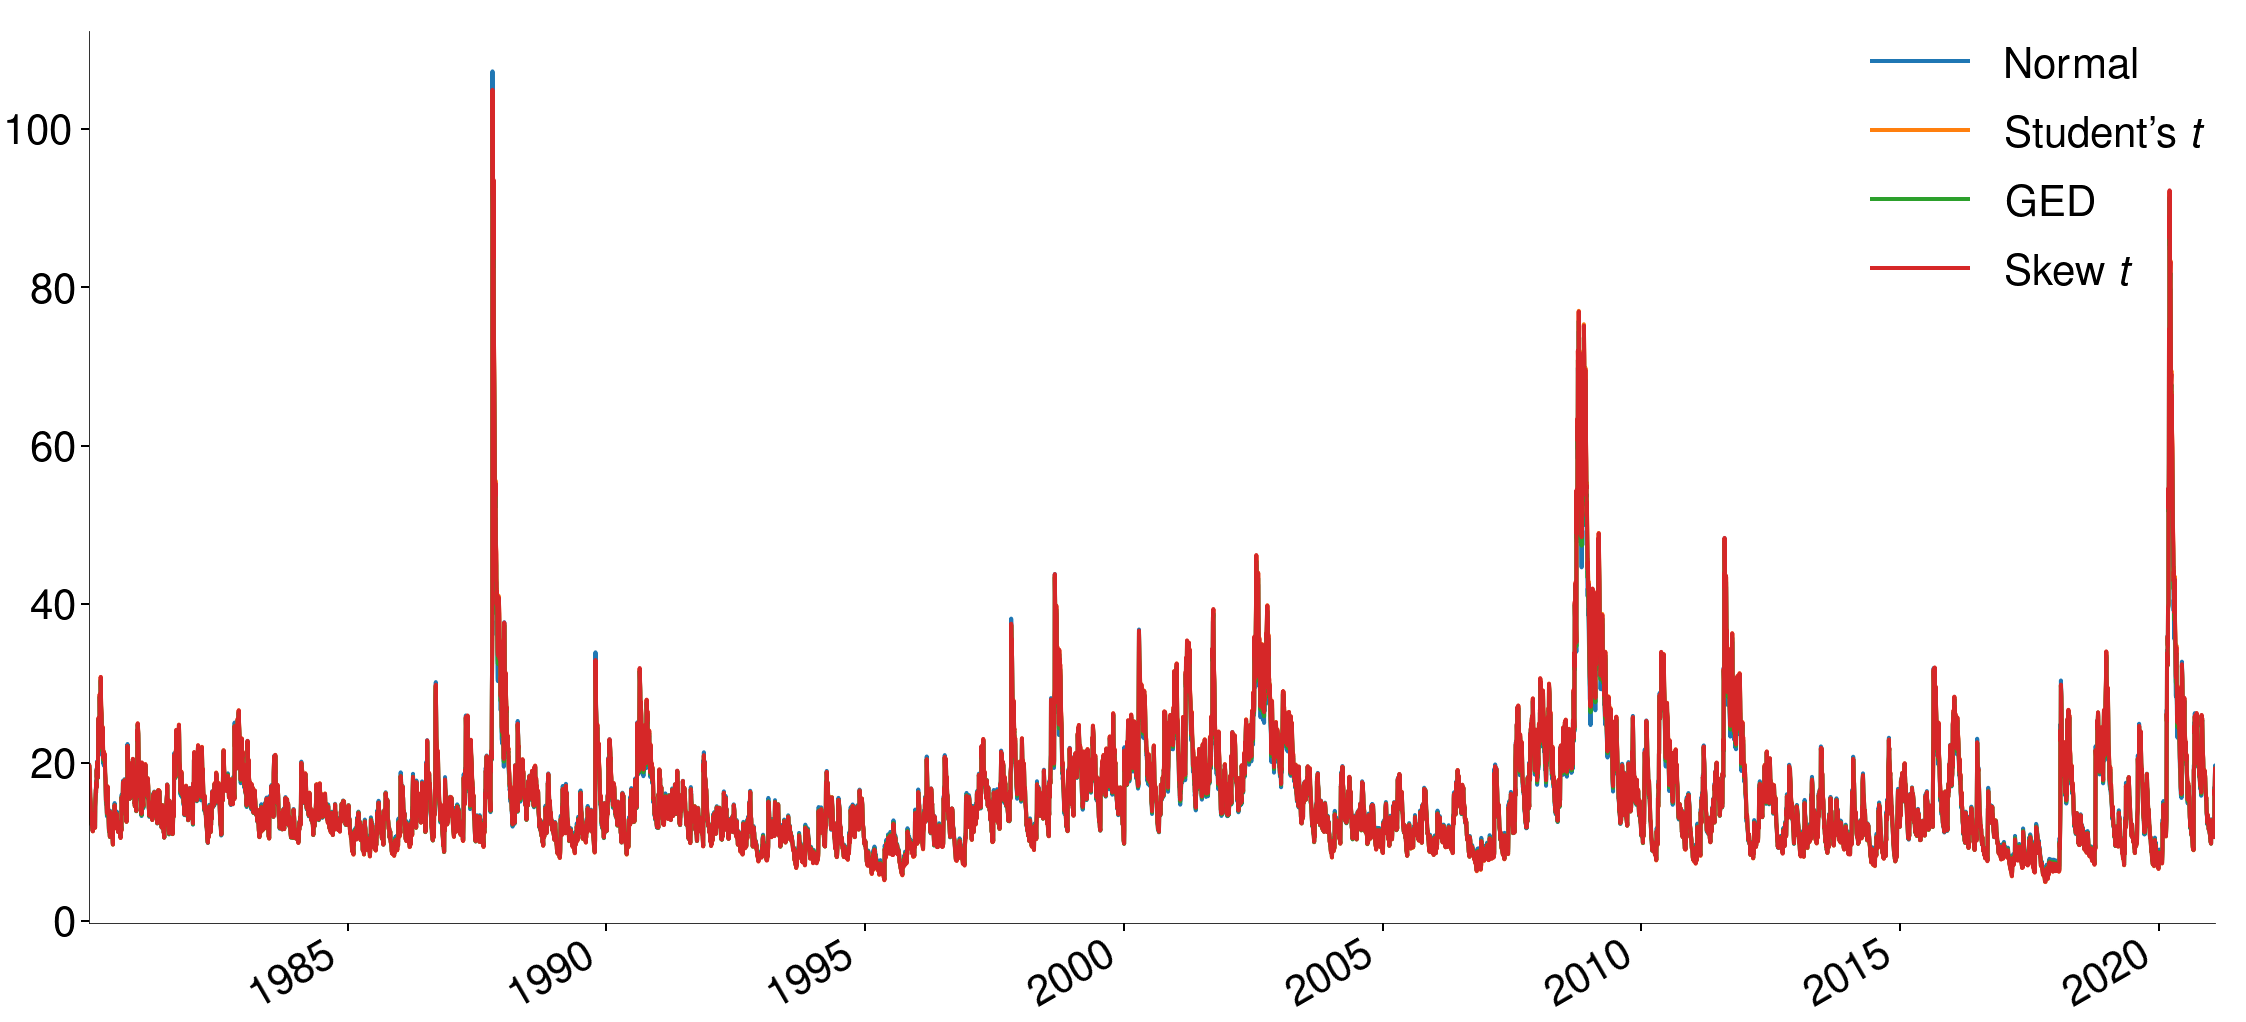

In [62]:
compare_volatility(annualize=True)

# Comparing Volatility in 2020

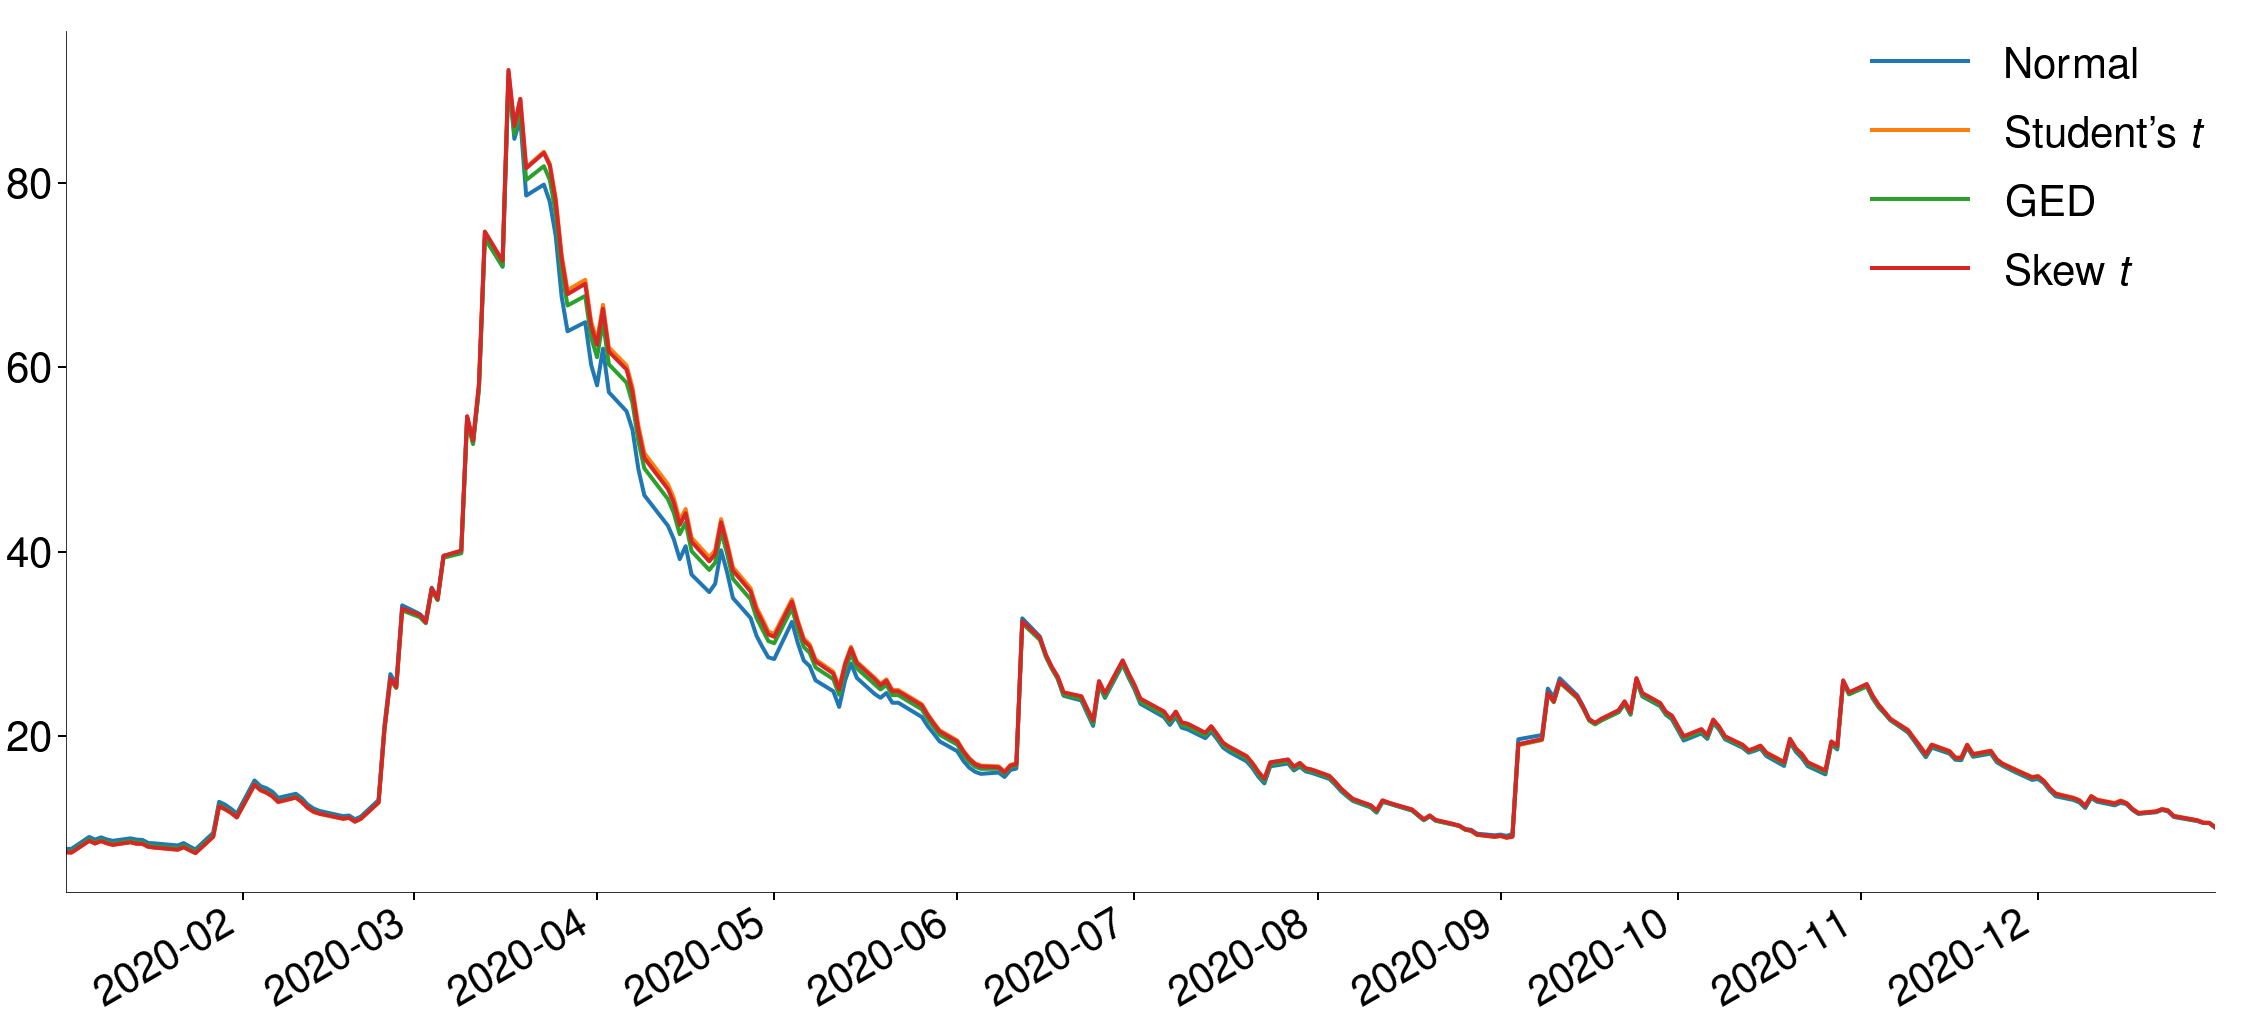

In [63]:
compare_volatility(annualize=True, span="2020")

In [64]:
from statsmodels.nonparametric.kde import KDEUnivariate
vals = [normal.model.distribution.simulate(None)(1000000),
studt.model.distribution.simulate(studt.params.iloc[-1])(1000000),
ged.model.distribution.simulate(ged.params.iloc[-1])(1000000),
skewt.model.distribution.simulate(skewt.params.iloc[-2:])(1000000)]

res = {}
for v, n in zip(vals, names):
    kde = KDEUnivariate(v)
    kde.fit(bw=0.1)
    res[n] = (kde.support, kde.density)

In [65]:
def compare_dist(tails=False):
    fig,ax = plt.subplots(1,1)
    for key in res:
        ax.plot(res[key][0], res[key][1], label=key)
    if tails:
        ax.set_xlim(-3,-2)
        lim = 0
        for key in res:
            x = res[key][0]
            y = res[key][1]
            lim = max(y[x<=-2].max(), lim)
        ax.set_ylim(0, 1.1*lim)
    else:
        ax.set_xlim(-3,3)
        ax.set_ylim(0, ax.get_ylim()[1])
    ax.legend(frameon=False)
    sns.despine()
    fig.tight_layout(pad=1.0)

# Comparing the estimated distributions

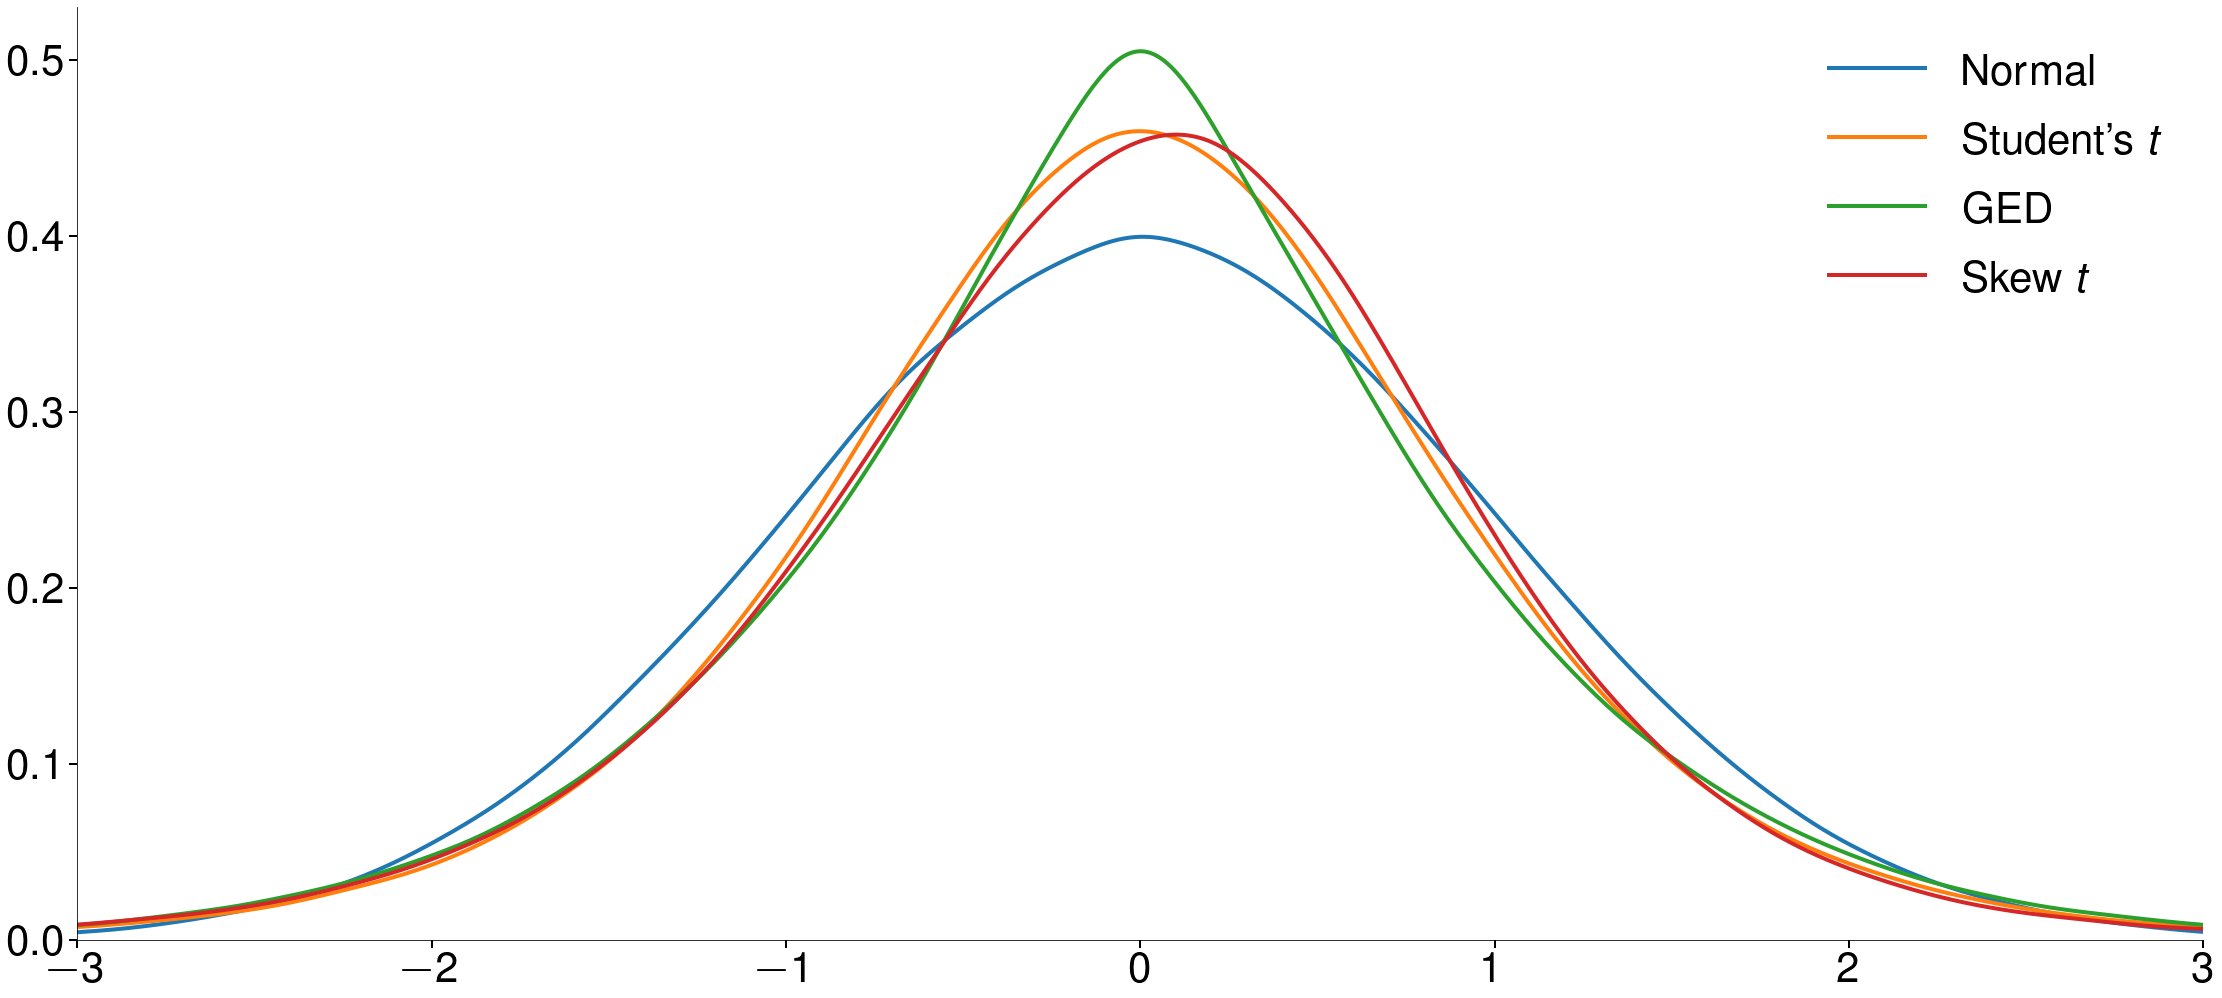

In [66]:
compare_dist()

# Comparing the Tails

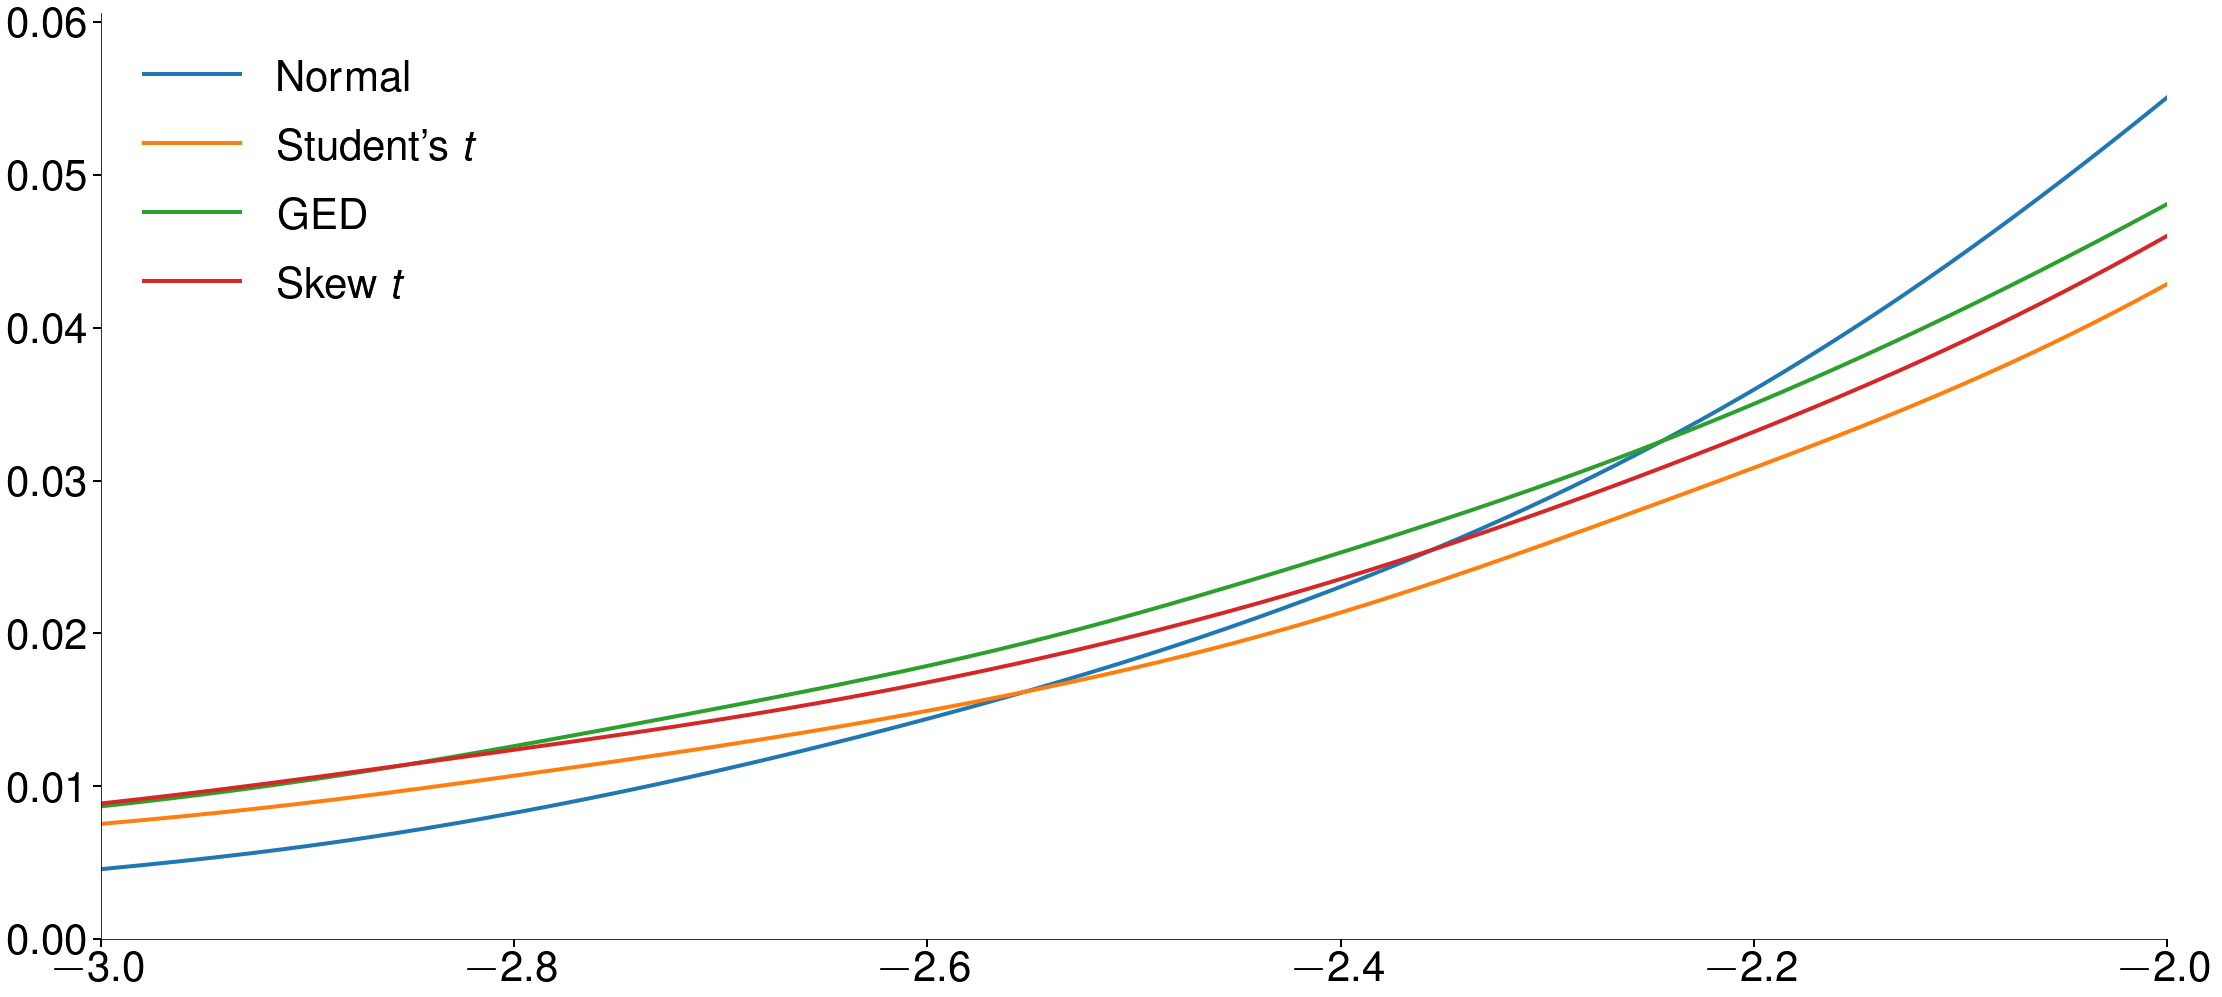

In [67]:
compare_dist(tails=True)

# Next Week

## Univariate Volatility Modeling

* Forecasting
* Forecast Evaluation
* Realized Variance